# Masterthesis: Descriptive analysis Team data

In [1]:
# Filename preprocessed data
#loaded_filename = 'teamdata2017_preprocessed'
#saved_filename = 'teamdata2017_standardized'
#loaded_filename = 'teamdata2018_preprocessed'
#saved_filename = 'teamdata2018_standardized'
loaded_filename = 'teamdata2019_preprocessed'
saved_filename = 'teamdata2019_standardized'

## 0. Load libraries and define functions

In [2]:
# Functions
import numpy as np
import os
import pickle
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from datetime import datetime
from collections import Counter
from numpy.random import choice
from scipy import stats
import operator
import itertools
import statistics

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

In [3]:
cm.get_cmap(name='tab20b')

In [4]:
### Function used to return a summary for categorical variables
def SummaryCategoricalVar(list_of_values, title, threshold = 20, top = 10):
    """
    param: list_of_values (list): A list of categorical values from which we like to obtain the distribution
    param: title (string): The title for the visualization
    param: threshold (int): The maximal number of categories that should be visualized
    param: top (int): The top k values that should be returned in the written summary when the number of categories is above the threshold
    """
    # Count the number of occurrances in the list
    cnt = Counter(list_of_values)
    sorted_cnt = sorted(cnt.items(), key=operator.itemgetter(1))[::-1]
    
    # Show the percentage dictionary if to many categories to represent
    print("-"* 100, "\nOverview of variable: ", title, "\n", "-"*100)
    print("Total categories:", len(cnt), "\n")
    if len(cnt) > threshold:
        if len(cnt) < top*2:
            for key, value in sorted_cnt:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
        else:
            print("The 10 with the highest percentage data available:\n")
            for key, value in sorted_cnt[:top]:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
            print("\nThe 10 with the lowest percentage data available:\n")
            for key, value in sorted_cnt[len(cnt) - top:]:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
                
    # Visualization of labelled data distribution
    else:
        plt.barh(range(1, len(sorted_cnt)+1), 
                 list(map(lambda x: (x/len(list_of_values)*100), [score for label, score in sorted_cnt])), 
                 tick_label = list([label for label, score in sorted_cnt]),
                 color = 'cornflowerblue', 
                 edgecolor = 'steelblue')
        plt.ylabel('Label')
        plt.xlabel('Percentage observations in dataset')
        plt.title(title)
        plt.show()    
        plt.savefig('Barplot_' + title + '.png')

In [5]:
### Function used to return a summary for numeric variables
def SummaryNumericVar(list_of_values, title):
    """
    param: list_of_values (list): A list of categorical values from which we like to obtain the distribution
    param: title (string): The title for the visualization
    """
    
    # Title varibale
    print("="* 100, "\nOverview of variable: ", title, "\n", "="*100)

    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(x = list_of_values, bins='auto', color= '#0504aa', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.ylim(top=np.ceil(n.max() / 10) * 10 if n.max() % 10 else n.max() + 10)
    plt.show()
    plt.savefig('Frequency_' + title + '.png')

    # Print summary statistics
    print("-"*20, "\nSummary statistics:\n", "-"*20)
    print("Minimum value:", min(list_of_values))
    print("Mean:", round(statistics.mean(list_of_values), 4))
    print("Standard deviation:", round(statistics.stdev(list_of_values), 4))
    print("Median:", round(statistics.median(list_of_values), 4))
    print("Maximal value:", max(list_of_values))

    # Plot boxplot
    plt.boxplot(list_of_values, 0, 'grey', 0)
    plt.xlabel('Value')
    plt.title(title)
    plt.show()
    plt.savefig('Boxplot_' + title + '.png')

    # Present outliers
    print("-"*20, "\nOutlier detection:\n", "-"*20)
    print("List of outliers:", {round(value,2) for z_score, value in zip(np.abs(stats.zscore(list_of_values)), list_of_values) if z_score > 3})

    # Check for normally distributed
    stats.probplot(list_of_values, dist="norm", plot= plt)
    plt.show()
    plt.savefig('Probabilityplot_' + title + '.png')

    # Statistics to check normality
    print("-"*20, "\nCheck for normal distribution:\n", "-"*20)
    print("Skewedness:", round(stats.skew(list_of_values), 4))
    print("Kurtosis:", round(stats.kurtosis(list_of_values), 4))

In [6]:
### Function used to draw a random sample from the discrete distribution of probabilities representing the input list
def RandomSampleProbDist(list_of_values, draws = 1):
    """
    :param: list_of_values (list): A list of categorical values representing the observations in the dataset
    :param: draws (int): The number of samples desired to be returned
    :return: (array) An array capturing the sampled categories
    """
    # Only the non-missing values are considered in the sampling procedure
    non_missing_list = list_of_values.dropna()
    # Sample from the discrete probability distribution representing the categorical variable
    return choice(list(Counter(non_missing_list)), 
                  draws, 
                  p = list(map(lambda x: x/len(non_missing_list), 
                               Counter(non_missing_list).values())))

In [7]:
### Function used for a boxcox transformation of input features
def feature_transformer(feature, featurename):
    """
    Visualizes the input feature before and after being boxcox transformed. Furthermore the transformed data,
    based on the optimal lambda estimated with the boxcox method is returned in a standardized fashion (zero mean
    and a variance of one)
    """
    # Boxcox transformation
    transformed_feature, optimizer = stats.boxcox(feature)
    standardized_feature, standardized_transformed_feature = preprocessing.scale(feature), preprocessing.scale(transformed_feature)
    # Visualization
    print("Feature: ", featurename)
    plt.figure()
    sns.kdeplot(standardized_feature, shade=True, label=featurename )
    sns.kdeplot(standardized_transformed_feature, shade=True, label= "Transformed " + featurename)
    plt.savefig('Transformed_' + featurename + '.png')
    print("The optimal value for lambda: ", optimizer)
    # Return transformed and standardized data
    return standardized_transformed_feature, optimizer

## 1. Load data

In [8]:
# Load pickle
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + loaded_filename + '.pickle', 'rb') as f:
    data_preparation = pickle.load(f)

##### Global summary data

In [9]:
# Visualization of the dataframe
data_preparation

gameid league  split game  \
22                                          240067    LCK    2.0    1   
23                                          240067    LCK    2.0    1   
34                                          240080    LCK    2.0    2   
35                                          240080    LCK    2.0    2   
46                                          240081    LCK    2.0    3   
47                                          240081    LCK    2.0    3   
58                                          240086    LCK    2.0    1   
59                                          240086    LCK    2.0    1   
70                                          240103    LCK    2.0    2   
71                                          240103    LCK    2.0    2   
82                                          240140    LCK    2.0    1   
83                                          240140    LCK    2.0    1   
94                                          240141    LCK    2.0    2   
95                                          240141    LCK    2.0    2   
130                                         240162    LCK    2.0    2   
131                                         240162    LCK    2.0    2   
166                                     1002100030  EULCS    2.0    1   
167                                     1002100030  EULCS    2.0    1   
178                                     1002100035  EULCS    2.0    2   
179                                     1002100035  EULCS    2.0    2   
214                                         250221    LCK    2.0    2   
215                                         250221    LCK    2.0    2   
226                                         250224    LCK    2.0    3   
227                                         250224    LCK    2.0    3   
238                                         250228    LCK    2.0    1   
239                                         250228    LCK    2.0    1   
250                                         250245    LCK    2.0    2   
251                                         250245    LCK    2.0    2   
262                                     1002100037  EULCS    2.0    1   
263                                     1002100037  EULCS    2.0    1   
...                                            ...    ...    ...  ...   
10510                   2019-2111LNG EsportsSuning    LPL    6.0    1   
10511                   2019-2111LNG EsportsSuning    LPL    6.0    1   
10522                   2019-2112SuningLNG Esports    LPL    6.0    2   
10523                   2019-2112SuningLNG Esports    LPL    6.0    2   
10534  2019-2111Bilibili GamingRoyal Never Give Up    LPL    6.0    1   
10535  2019-2111Bilibili GamingRoyal Never Give Up    LPL    6.0    1   
10546  2019-2112Bilibili GamingRoyal Never Give Up    LPL    6.0    2   
10547  2019-2112Bilibili GamingRoyal Never Give Up    LPL    6.0    2   
10558       2019-2111Rogue WarriorsInvictus Gaming    LPL    6.0    1   
10559       2019-2111Rogue WarriorsInvictus Gaming    LPL    6.0    1   
10570       2019-2112Rogue WarriorsInvictus Gaming    LPL    6.0    2   
10571       2019-2112Rogue WarriorsInvictus Gaming    LPL    6.0    2   
10582           2019-2111Rogue WarriorsVici Gaming    LPL    6.0    1   
10583           2019-2111Rogue WarriorsVici Gaming    LPL    6.0    1   
10594           2019-2112Vici GamingRogue Warriors    LPL    6.0    2   
10595           2019-2112Vici GamingRogue Warriors    LPL    6.0    2   
10606           2019-2113Vici GamingRogue Warriors    LPL    6.0    3   
10607           2019-2113Vici GamingRogue Warriors    LPL    6.0    3   
10618          2019-2111Funplus PhoenixTop Esports    LPL    6.0    1   
10619          2019-2111Funplus PhoenixTop Esports    LPL    6.0    1   
10630          2019-2112Funplus PhoenixTop Esports    LPL    6.0    2   
10631          2019-2112Funplus PhoenixTop Esports    LPL    6.0    2   
10642                      2019-2111OMGTop Esports    LPL    6.0    1   
10643                      20

In [10]:
# Short intermediate summary
print("The final dataset captures information from", len(data_preparation.columns), "features.")
print("In total, there are", len(data_preparation), "observations present in the dataframe, capturing the information from",
      len(set(data_preparation.gameid)), "games.")

The final dataset captures information from 76 features.
In total, there are 15514 observations present in the dataframe, capturing the information from 7757 games.


##### Extract categorical/ numerical feature list

In [11]:
# Initialization
categorical_variables, numerical_variables = [], []

# Extract categorical and numeric variables
for col, col_type in zip(data_preparation.columns, data_preparation.dtypes):
    if str(col_type) == 'object':
        categorical_variables.append(col)
    else:
        numerical_variables.append(col)

## 2. Univariate analysis of the data
In a first phase all the variables are investigated in a univariate analysis. A distinction is made here between categorical and numerical variables. 

In [12]:
# Create new dataset to capture final preprocssed dataframe (used for analysis)
preprocessed_data = data_preparation.copy()
os.chdir('./Univariate_analysis/')

In [13]:
# Check
os.getcwd()

'/home/je32910/MasterThesis_ComputationalStatistics/Univariate_analysis'

### 2.1 Analysis of categorical variables
The following aspect will be analysed here:
* Balanced classes

Furthermore one-hot encoding will be considered to transform these variables to an appropriate format ready for analysis.

##### Exploration characteristics categorical features

---------------------------------------------------------------------------------------------------- 
Overview of variable:  gameid 
 ----------------------------------------------------------------------------------------------------
Total categories: 7757 

The 10 with the highest percentage data available:

2019-2112Victory FiveTeam WE : 0.0129 %
2019-2111Victory FiveTeam WE : 0.0129 %
2019-2112Top EsportsOMG : 0.0129 %
2019-2111OMGTop Esports : 0.0129 %
2019-2112Funplus PhoenixTop Esports : 0.0129 %
2019-2111Funplus PhoenixTop Esports : 0.0129 %
2019-2113Vici GamingRogue Warriors : 0.0129 %
2019-2112Vici GamingRogue Warriors : 0.0129 %
2019-2111Rogue WarriorsVici Gaming : 0.0129 %
2019-2112Rogue WarriorsInvictus Gaming : 0.0129 %

The 10 with the lowest percentage data available:

1002100035 : 0.0129 %
1002100030 : 0.0129 %
240162 : 0.0129 %
240141 : 0.0129 %
240140 : 0.0129 %
240103 : 0.0129 %
240086 : 0.0129 %
240081 : 0.0129 %
240080 : 0.0129 %
240067 : 0.0129 %
----------------

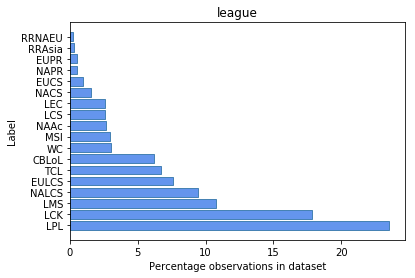

---------------------------------------------------------------------------------------------------- 
Overview of variable:  game 
 ----------------------------------------------------------------------------------------------------
Total categories: 27 

The 10 with the highest percentage data available:

1 : 39.4611 %
2 : 39.3709 %
3 : 15.2636 %
4 : 2.9135 %
5 : 1.547 %
6 : 0.477 %
T : 0.4254 %
8 : 0.0902 %
7 : 0.0773 %
2.6 : 0.0258 %

The 10 with the lowest percentage data available:

1.3 : 0.0258 %
1.2 : 0.0258 %
1.1 : 0.0258 %
2.1 : 0.0129 %
3.6 : 0.0129 %
3.5 : 0.0129 %
3.4 : 0.0129 %
3.3 : 0.0129 %
3.2 : 0.0129 %
3.1 : 0.0129 %
---------------------------------------------------------------------------------------------------- 
Overview of variable:  side 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



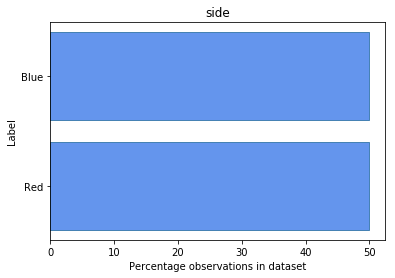

---------------------------------------------------------------------------------------------------- 
Overview of variable:  ban1 
 ----------------------------------------------------------------------------------------------------
Total categories: 129 

The 10 with the highest percentage data available:

Aatrox : 4.8601 %
Camille : 4.3767 %
LeBlanc : 4.2478 %
Zac : 3.6741 %
Zoe : 3.2616 %
Jayce : 3.0618 %
Kalista : 2.978 %
Ryze : 2.9006 %
Taliyah : 2.6234 %
Galio : 2.617 %

The 10 with the lowest percentage data available:

Miss Fortune : 0.0258 %
Warwick : 0.0258 %
Volibear : 0.0193 %
Illaoi : 0.0193 %
Pantheon : 0.0129 %
Veigar : 0.0129 %
Jinx : 0.0064 %
Xerath : 0.0064 %
Nami : 0.0064 %
Vi : 0.0064 %
---------------------------------------------------------------------------------------------------- 
Overview of variable:  ban2 
 ----------------------------------------------------------------------------------------------------
Total categories: 131 

The 10 with the highest per

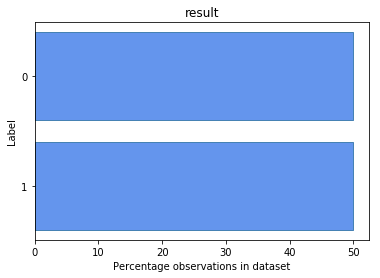

---------------------------------------------------------------------------------------------------- 
Overview of variable:  fb 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



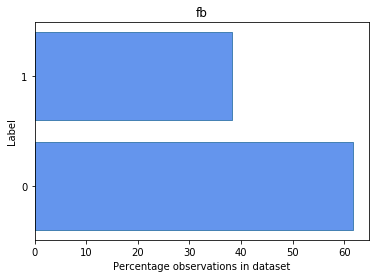

---------------------------------------------------------------------------------------------------- 
Overview of variable:  fbassist 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



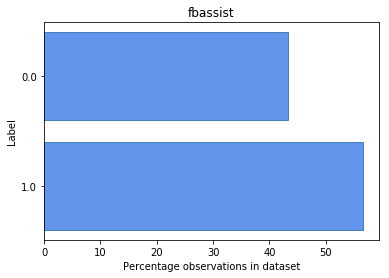

---------------------------------------------------------------------------------------------------- 
Overview of variable:  fbvictim 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



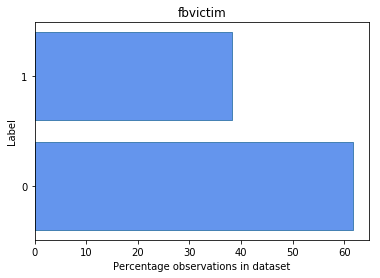

---------------------------------------------------------------------------------------------------- 
Overview of variable:  fd 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



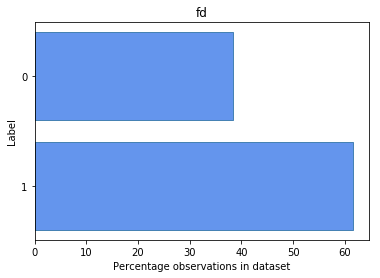

---------------------------------------------------------------------------------------------------- 
Overview of variable:  herald 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



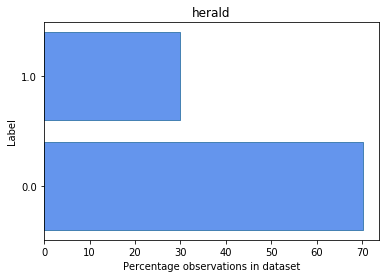

---------------------------------------------------------------------------------------------------- 
Overview of variable:  ft 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



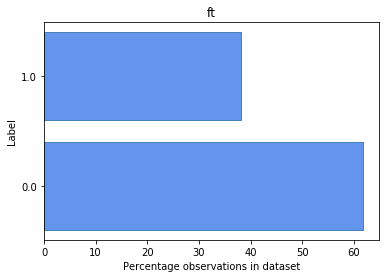

---------------------------------------------------------------------------------------------------- 
Overview of variable:  firstmidouter 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



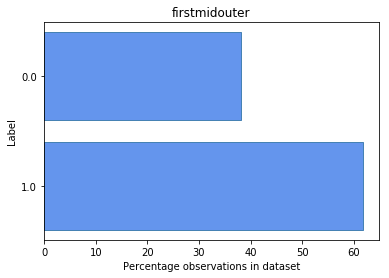

---------------------------------------------------------------------------------------------------- 
Overview of variable:  firsttothreetowers 
 ----------------------------------------------------------------------------------------------------
Total categories: 5 



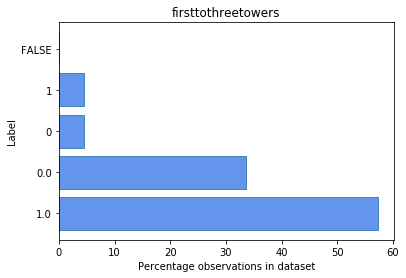

---------------------------------------------------------------------------------------------------- 
Overview of variable:  fbaron 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



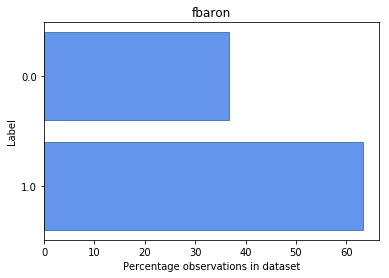

---------------------------------------------------------------------------------------------------- 
Overview of variable:  Year 
 ----------------------------------------------------------------------------------------------------
Total categories: 3 



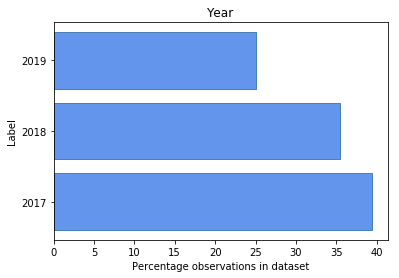

---------------------------------------------------------------------------------------------------- 
Overview of variable:  team 
 ----------------------------------------------------------------------------------------------------
Total categories: 151 

The 10 with the highest percentage data available:

sk telecom t1 : 2.2238 %
royal never give up : 2.1207 %
invictus gaming : 2.0884 %
team we : 2.0111 %
edward gaming : 1.9917 %
afreeca freecs : 1.966 %
kt rolster : 1.966 %
team liquid : 1.8306 %
cloud9 : 1.8113 %
flash wolves : 1.6952 %

The 10 with the lowest percentage data available:

17 academy : 0.058 %
infinity esports : 0.0516 %
young generation : 0.0451 %
mega esports : 0.0387 %
bombers : 0.0387 %
pentagram : 0.0387 %
rainbow7 : 0.0387 %
virtus.pro : 0.0387 %
oyunhizmetleri : 0.0258 %
besiktas : 0.0193 %
---------------------------------------------------------------------------------------------------- 
Overview of variable:  culture 
 -------------------------------------

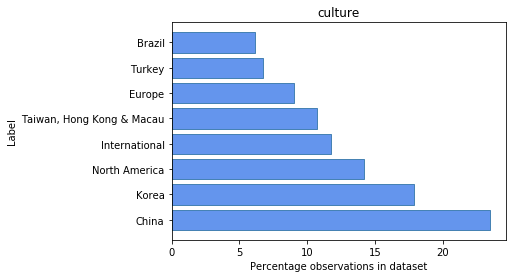

<Figure size 432x288 with 0 Axes>

In [14]:
# Loop through all categorical variables and visualize data
for cat_variable in categorical_variables:
    SummaryCategoricalVar(preprocessed_data[cat_variable], cat_variable)

In [15]:
# Most banned champion
most_banned = list(itertools.chain(preprocessed_data['ban1'], preprocessed_data['ban2'], preprocessed_data['ban3'],
                                   preprocessed_data['ban4'], preprocessed_data['ban5']))
SummaryCategoricalVar(most_banned, "Total times banned as champion")

---------------------------------------------------------------------------------------------------- 
Overview of variable:  Total times banned as champion 
 ----------------------------------------------------------------------------------------------------
Total categories: 142 

The 10 with the highest percentage data available:

Camille : 3.4794 %
LeBlanc : 3.3608 %
Jayce : 2.4236 %
Ryze : 2.412 %
Taliyah : 2.4094 %
Galio : 2.4094 %
Tahm Kench : 2.1658 %
Aatrox : 2.1297 %
Zoe : 2.0794 %
Varus : 1.9428 %

The 10 with the lowest percentage data available:

Xerath : 0.0142 %
Vi : 0.0103 %
Nasus : 0.0077 %
Cho'Gath : 0.0064 %
Pantheon : 0.0064 %
Amumu : 0.0039 %
Diana : 0.0039 %
RekSai : 0.0026 %
Kaisa : 0.0013 %
Garen : 0.0013 %


##### Encoding

In [16]:
# Encode categorical features in numeric ones
for col in categorical_variables:
    try:
        preprocessed_data['Encoded_' + col] = [int(x) for x in list(preprocessed_data[col])]
    except:
        try: 
            preprocessed_data['Encoded_' + col] = [float(x) for x in list(preprocessed_data[col])]
        except:
            mapping_dict = dict(zip(list(set(preprocessed_data[col])), list(range(len(set(preprocessed_data[col]))))))
            preprocessed_data['Encoded_' + col] = [mapping_dict[x] for x in preprocessed_data[col]]

##### Remove irrelevant features for further analysis

In [17]:
# Drop irrelevant features
catvar_before_encoding = [col[len('Encoded_'):] for col in preprocessed_data.columns if 'Encoded_' in col]
catvar_before_encoding.remove('team')
preprocessed_data = preprocessed_data.drop(labels=catvar_before_encoding, axis=1)
preprocessed_data = preprocessed_data.drop(labels = ['Encoded_gameid', 'Encoded_team'], axis=1)

In [18]:
# Add one-hot-encoded features to numerical feature list
for cat in catvar_before_encoding:
    numerical_variables.append('Encoded_' + cat)
numerical_variables.remove('Encoded_gameid')

### 2.2 Analysis of numerical variables
The following aspects will be analysed here:
* Visualisation data (boxplot, histogram)
* Minimal and maximal values 
* Outliers
* Transformation/ normalization of the data
* Near zero variance indicator (before and after removal outliers)
* Skewness: A measure of lack of symmetry. The skewness for a normal distribution is zero and any symmertric data should have a skewness near zero. Negative values for skewness indicate the data to be skewed left while, positive values imply the data to be skewed right. In case the data is multi-modal, the sign of the skewness metric might be affected.
* Kurtosis: A measure indicating whether the data are heavy-tailed or light-tailed relative to a normal distribution. In case the kurtosis is high the data is distributed with heavy tails (many outliers), while data with low kurtosis tends to have light tails. The kurtosis for a standard normal distribution is three. The scipy package used to calculate the kurtosis here uses the formula for "excess kurtosis" in which the deviation from the normal condition is considered (kurtosis - 3).

##### Exploration characteristics numerical features

Overview of variable:  split 


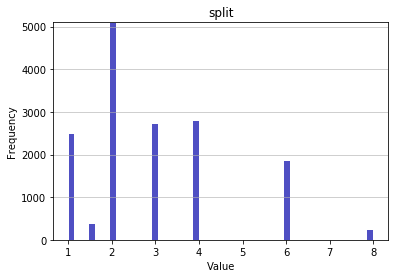

-------------------- 
Summary statistics:
 --------------------
Minimum value: 1.0
Mean: 2.9288
Standard deviation: 1.6276
Median: 2.0
Maximal value: 8.0


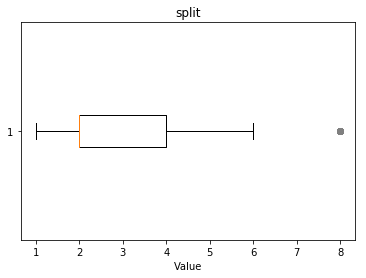

-------------------- 
Outlier detection:
 --------------------
List of outliers: {8.0}


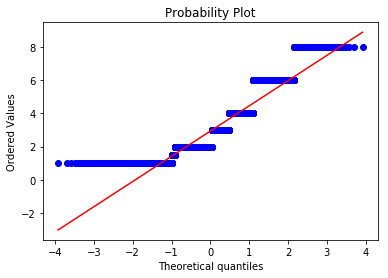

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.9708
Kurtosis: 0.351
Overview of variable:  patchno 


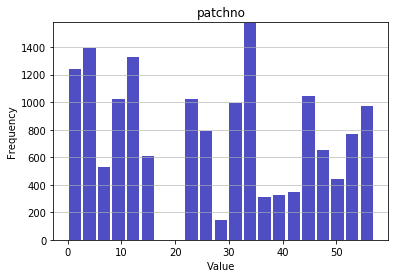

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 26.4727
Standard deviation: 17.8431
Median: 26.0
Maximal value: 57.0


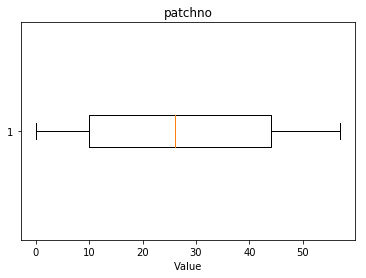

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


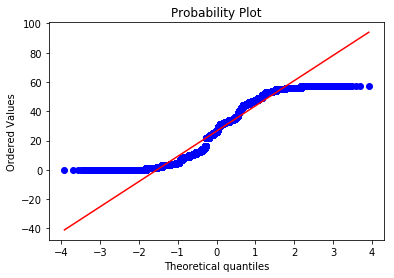

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1081
Kurtosis: -1.3024
Overview of variable:  gamelength 


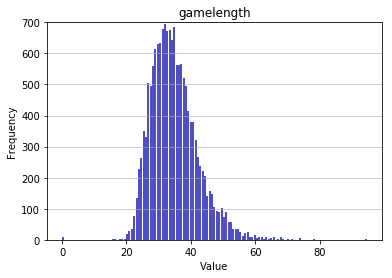

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 34.8241
Standard deviation: 7.332
Median: 33.9
Maximal value: 94.66666666666667


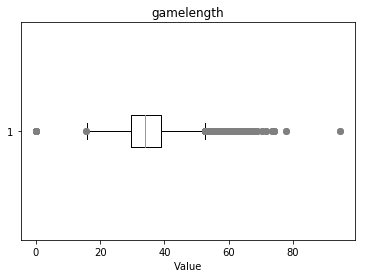

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.0, 63.35, 62.15, 57.68, 57.75, 57.55, 57.5, 57.2, 57.95, 57.43, 58.05, 58.83, 58.2, 58.98, 57.18, 59.9, 59.82, 59.97, 59.85, 58.08, 60.63, 60.13, 60.95, 64.55, 63.25, 61.12, 61.82, 61.15, 60.32, 58.25, 56.97, 57.22, 58.72, 58.87, 58.28, 57.77, 57.37, 63.13, 60.65, 65.7, 65.9, 67.65, 67.58, 62.23, 61.57, 62.07, 63.2, 65.82, 65.38, 70.25, 64.72, 77.95, 66.83, 66.98, 71.63, 62.65, 64.43, 74.03, 57.65, 67.9, 68.15, 68.92, 62.22, 94.67, 63.52, 65.15, 59.58, 73.5, 64.95, 57.57, 74.08, 57.3}


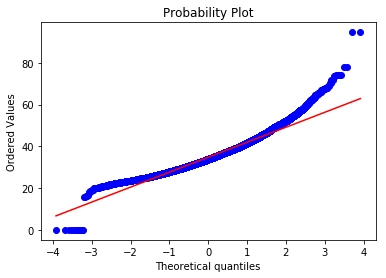

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.9042
Kurtosis: 2.2745
Overview of variable:  k 


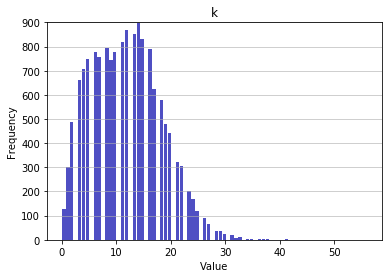

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 11.7474
Standard deviation: 6.4427
Median: 12.0
Maximal value: 56.0


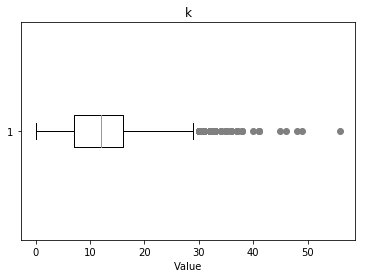

-------------------- 
Outlier detection:
 --------------------
List of outliers: {32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 40.0, 41.0, 45.0, 46.0, 48.0, 49.0, 56.0}


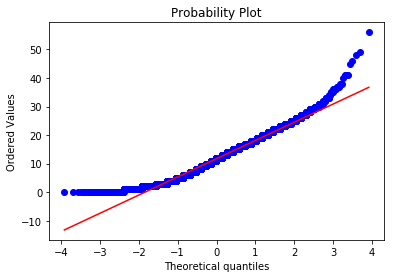

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4417
Kurtosis: 0.1293
Overview of variable:  d 


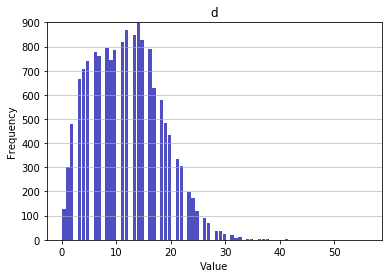

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 11.7667
Standard deviation: 6.4472
Median: 12.0
Maximal value: 56.0


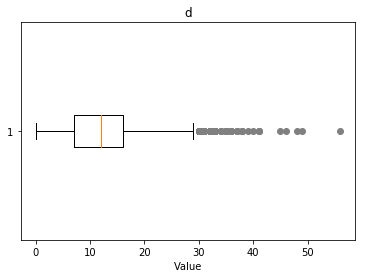

-------------------- 
Outlier detection:
 --------------------
List of outliers: {32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 45.0, 46.0, 48.0, 49.0, 56.0}


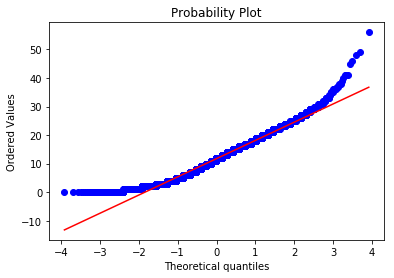

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4426
Kurtosis: 0.1322
Overview of variable:  a 


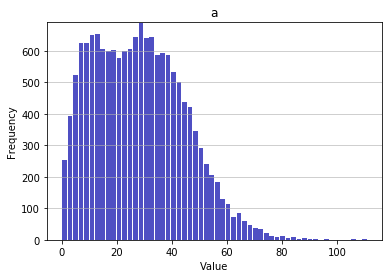

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 27.7583
Standard deviation: 16.5358
Median: 27.0
Maximal value: 111.0


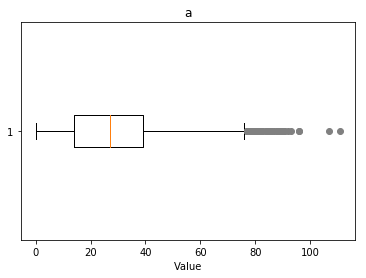

-------------------- 
Outlier detection:
 --------------------
List of outliers: {96.0, 83.0, 107.0, 78.0, 79.0, 80.0, 81.0, 82.0, 111.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0}


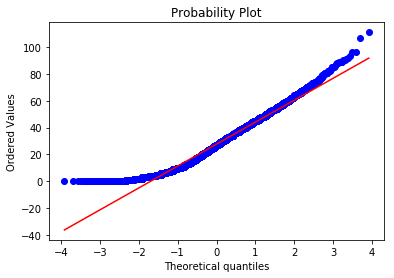

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4516
Kurtosis: -0.2182
Overview of variable:  teamkills 


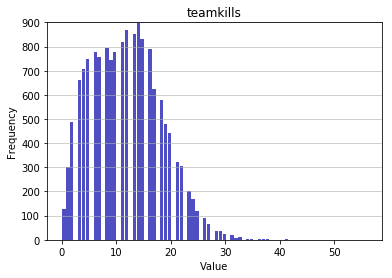

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 11.7474
Standard deviation: 6.4427
Median: 12.0
Maximal value: 56.0


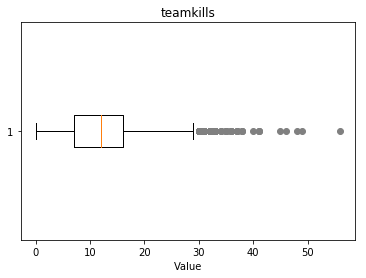

-------------------- 
Outlier detection:
 --------------------
List of outliers: {32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 40.0, 41.0, 45.0, 46.0, 48.0, 49.0, 56.0}


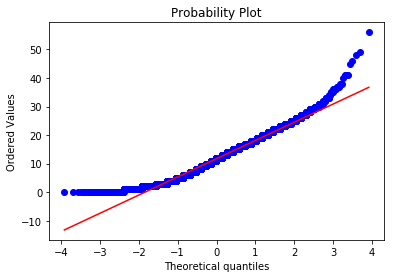

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4417
Kurtosis: 0.1293
Overview of variable:  fbtime 


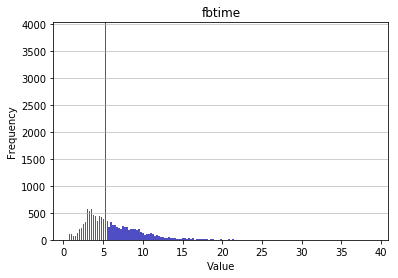

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.6477833333333333
Mean: 6.0293
Standard deviation: 3.2086
Median: 5.3225
Maximal value: 38.99143333333333


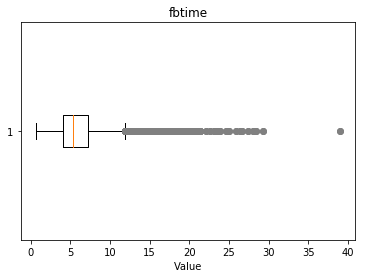

-------------------- 
Outlier detection:
 --------------------
List of outliers: {18.53, 15.76, 16.31, 16.01, 16.33, 18.45, 19.58, 19.18, 20.64, 18.63, 18.47, 16.2, 17.89, 19.02, 27.42, 29.3, 21.35, 26.35, 28.37, 25.04, 25.86, 26.67, 28.06, 38.99, 16.82, 16.95, 16.83, 17.07, 17.2, 15.86, 15.79, 15.89, 15.93, 16.71, 16.43, 16.39, 16.75, 16.36, 17.0, 17.21, 17.82, 17.03, 17.57, 18.11, 18.0, 17.6, 18.72, 18.1, 19.75, 18.07, 19.9, 18.14, 18.75, 20.32, 20.93, 16.6, 19.43, 21.33, 21.0, 16.73, 16.23, 22.65, 23.64, 23.15, 23.86, 23.21, 23.75, 24.65, 16.24, 15.87, 15.94, 16.05, 16.93, 17.55, 17.68, 17.18, 16.21, 15.84, 15.95, 16.09, 16.3, 16.76, 16.84, 16.56, 16.13, 17.8, 17.81, 17.69, 16.98, 16.34, 18.37, 17.23, 18.51, 18.13, 18.69, 18.62, 18.81, 18.01, 18.88, 19.84, 20.99, 20.38, 20.84, 20.8, 21.3, 21.23, 22.06, 23.44, 23.49, 16.87, 15.67, 15.78, 15.88, 16.41, 16.29, 17.28, 17.04}


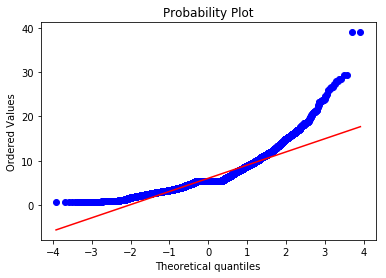

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.8423
Kurtosis: 6.2242
Overview of variable:  kpm 


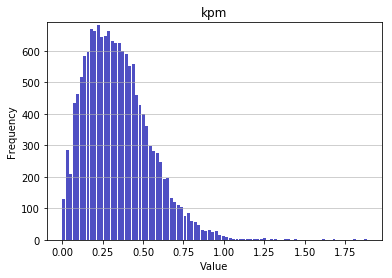

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3433
Standard deviation: 0.1986
Median: 0.3192
Maximal value: 1.882845188284519


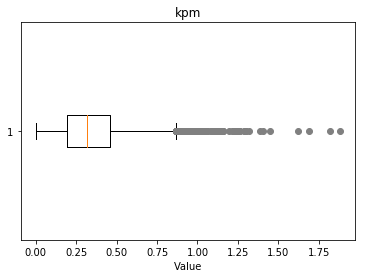

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.99, 1.12, 0.94, 1.25, 1.04, 0.95, 1.01, 0.96, 1.03, 1.09, 1.26, 1.0, 1.08, 1.69, 1.02, 1.45, 1.11, 1.2, 1.13, 1.38, 1.29, 1.62, 1.88, 1.21, 0.97, 1.05, 1.3, 1.14, 0.98, 1.23, 1.15, 1.06, 1.24, 1.16, 1.32, 1.07, 1.82, 1.41}


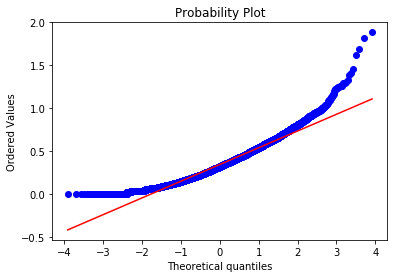

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8474
Kurtosis: 1.3508
Overview of variable:  ckpm 


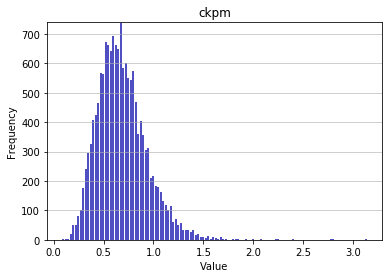

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.08412197686645637
Mean: 0.6866
Standard deviation: 0.2487
Median: 0.6597
Maximal value: 3.1380753138075317


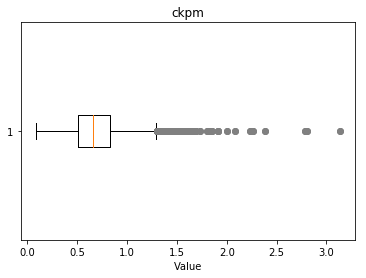

-------------------- 
Outlier detection:
 --------------------
List of outliers: {1.66, 1.57, 1.55, 1.47, 1.68, 1.45, 1.49, 1.6, 1.48, 1.81, 2.23, 1.67, 2.0, 2.26, 2.08, 1.43, 1.59, 1.51, 1.44, 1.52, 1.85, 2.78, 1.7, 1.61, 1.53, 1.63, 1.46, 1.54, 2.8, 1.64, 1.56, 2.39, 3.14, 1.82, 1.91, 1.74, 1.92}


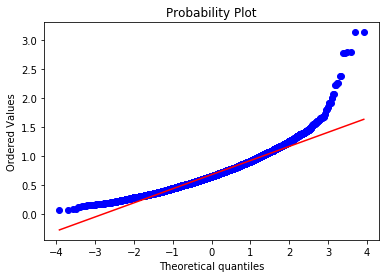

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.0619
Kurtosis: 3.8639
Overview of variable:  fdtime 


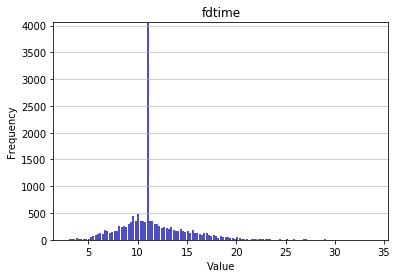

-------------------- 
Summary statistics:
 --------------------
Minimum value: 2.9805333333333333
Mean: 11.5684
Standard deviation: 3.3375
Median: 11.1125
Maximal value: 33.89945


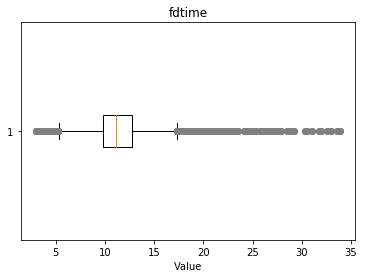

-------------------- 
Outlier detection:
 --------------------
List of outliers: {21.69, 22.8, 23.28, 22.24, 25.2, 26.95, 26.51, 26.98, 26.01, 27.5, 27.9, 27.12, 27.04, 30.51, 28.91, 27.24, 29.06, 32.99, 31.71, 33.55, 32.57, 33.78, 22.0, 21.97, 21.75, 22.28, 22.33, 22.29, 22.07, 22.85, 22.03, 23.03, 23.22, 23.11, 22.21, 22.68, 24.85, 24.42, 24.53, 23.42, 24.46, 25.07, 25.86, 25.25, 25.15, 23.53, 28.96, 28.46, 29.08, 23.04, 31.9, 31.04, 33.9, 22.86, 22.65, 21.74, 21.73, 22.87, 22.38, 22.51, 22.99, 22.49, 23.09, 23.44, 23.45, 23.02, 22.02, 24.44, 24.51, 24.12, 23.24, 23.16, 25.27, 25.84, 25.24, 25.8, 25.94, 26.48, 26.76, 26.77, 22.67, 22.92, 29.24, 30.34, 22.43}


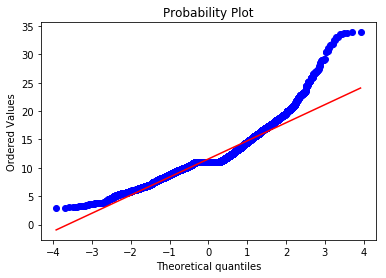

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.2424
Kurtosis: 3.8861
Overview of variable:  teamdragkills 


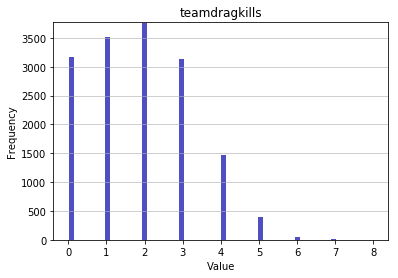

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 1.8497
Standard deviation: 1.3789
Median: 2.0
Maximal value: 8.0


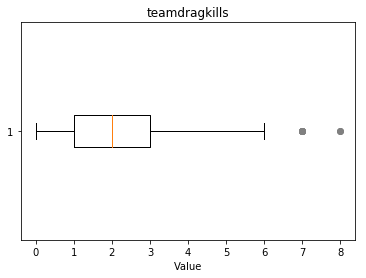

-------------------- 
Outlier detection:
 --------------------
List of outliers: {8.0, 6.0, 7.0}


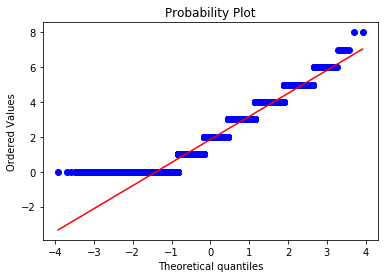

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3602
Kurtosis: -0.5457
Overview of variable:  elementals 


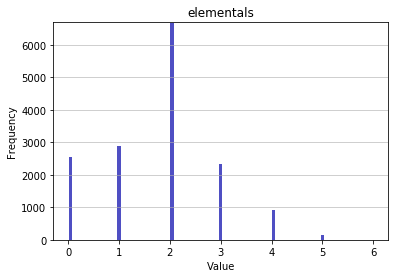

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 1.7884
Standard deviation: 1.1328
Median: 2.0
Maximal value: 6.0


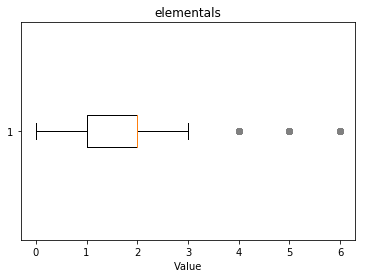

-------------------- 
Outlier detection:
 --------------------
List of outliers: {6.0}


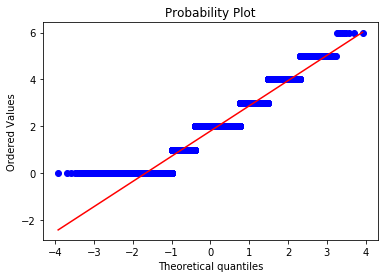

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.178
Kurtosis: -0.1247
Overview of variable:  firedrakes 


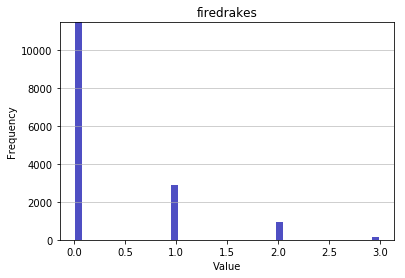

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3433
Standard deviation: 0.6423
Median: 0.0
Maximal value: 3.0


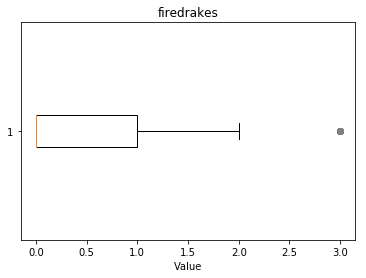

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.0}


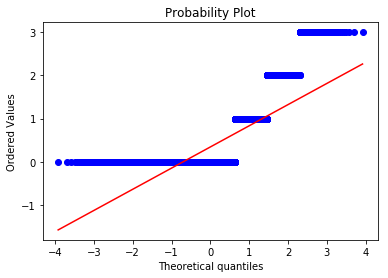

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.8985
Kurtosis: 3.1078
Overview of variable:  waterdrakes 


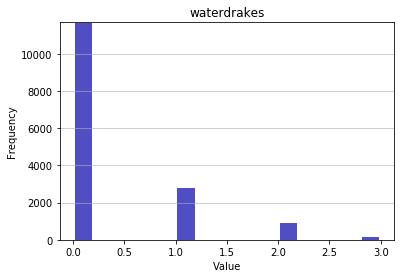

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.327
Standard deviation: 0.6336
Median: 0.0
Maximal value: 3.0


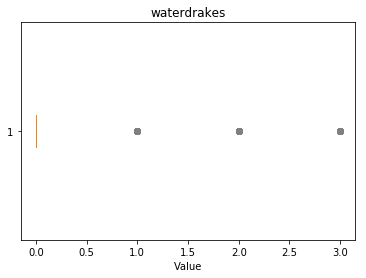

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.0}


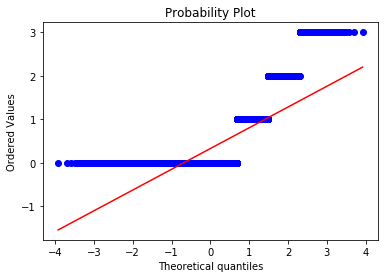

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.993
Kurtosis: 3.5283
Overview of variable:  earthdrakes 


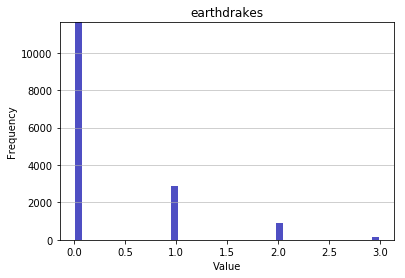

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3244
Standard deviation: 0.6197
Median: 0.0
Maximal value: 3.0


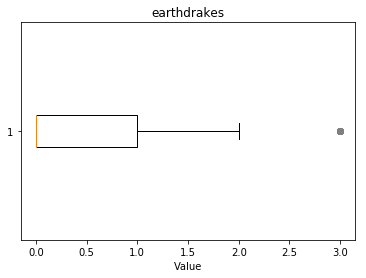

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.0}


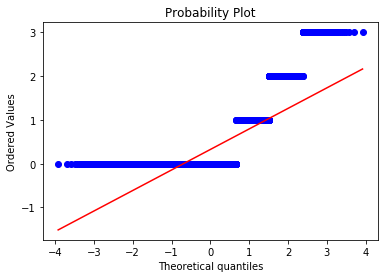

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.9472
Kurtosis: 3.3541
Overview of variable:  airdrakes 


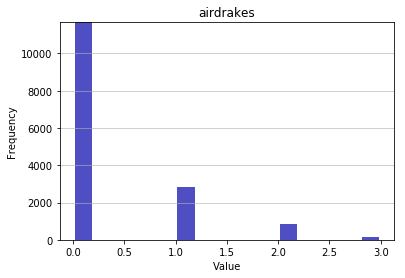

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3225
Standard deviation: 0.6219
Median: 0.0
Maximal value: 3.0


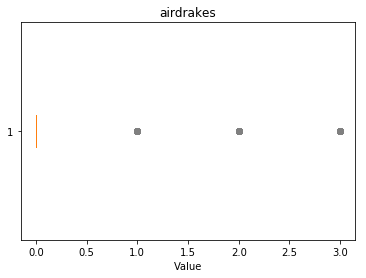

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.0}


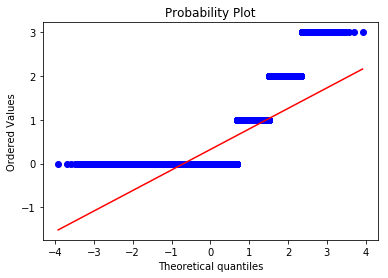

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.9808
Kurtosis: 3.5169
Overview of variable:  elders 


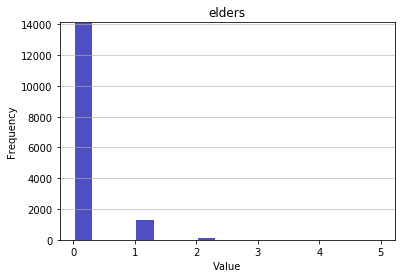

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.0996
Standard deviation: 0.3346
Median: 0.0
Maximal value: 5.0


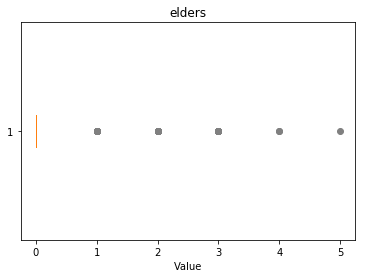

-------------------- 
Outlier detection:
 --------------------
List of outliers: {2.0, 3.0, 4.0, 5.0}


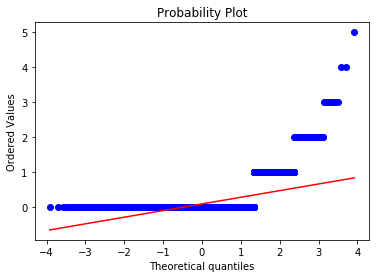

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 3.8134
Kurtosis: 18.3617
Overview of variable:  heraldtime 


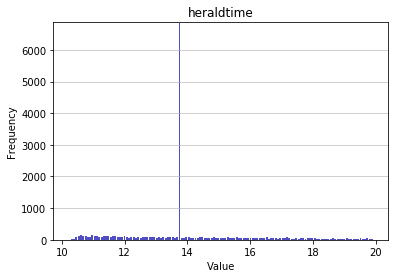

-------------------- 
Summary statistics:
 --------------------
Minimum value: 10.202416666666666
Mean: 13.9611
Standard deviation: 1.975
Median: 13.7258
Maximal value: 19.918566666666667


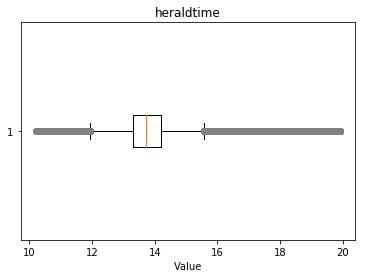

-------------------- 
Outlier detection:
 --------------------
List of outliers: {19.9, 19.92, 19.89}


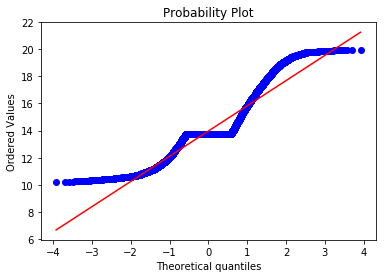

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8382
Kurtosis: 0.8866
Overview of variable:  fttime 


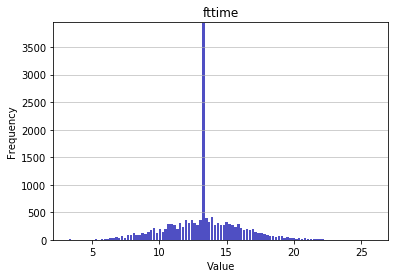

-------------------- 
Summary statistics:
 --------------------
Minimum value: 3.2423333333333333
Mean: 13.2723
Standard deviation: 2.6497
Median: 13.2991
Maximal value: 25.8949


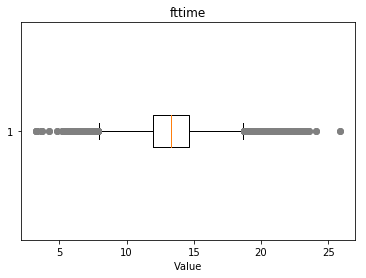

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.24, 4.21, 5.21, 5.24, 3.27, 3.73, 3.65, 4.84, 3.3, 21.99, 21.61, 23.46, 23.55, 23.07, 21.6, 21.32, 22.5, 21.87, 21.96, 22.07, 24.09, 25.89, 21.88, 21.82, 21.95, 21.89, 22.08, 21.97, 21.47, 21.58, 21.44, 21.74, 21.56, 21.35, 22.1, 22.77, 22.86, 22.88, 21.31, 21.73, 23.27, 22.41, 23.53, 23.34, 21.8}


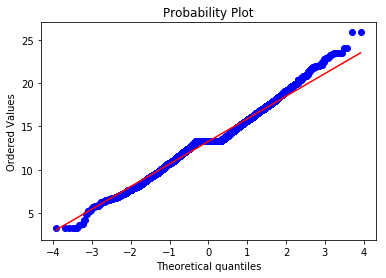

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1152
Kurtosis: 0.8703
Overview of variable:  teamtowerkills 


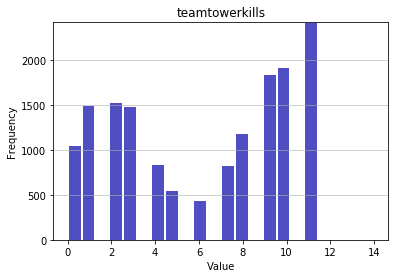

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 6.1253
Standard deviation: 3.845
Median: 7.0
Maximal value: 14.0


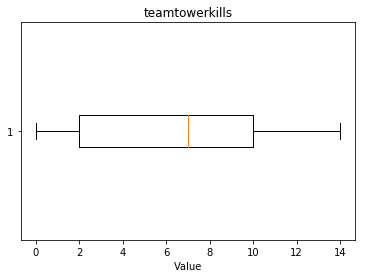

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


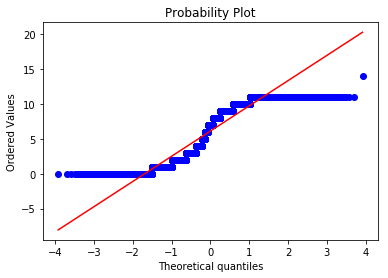

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.1797
Kurtosis: -1.513
Overview of variable:  fbarontime 


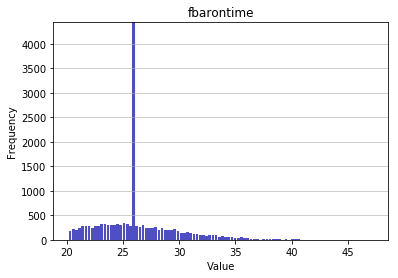

-------------------- 
Summary statistics:
 --------------------
Minimum value: 20.161783333333332
Mean: 26.334
Standard deviation: 3.5747
Median: 25.8742
Maximal value: 47.2605


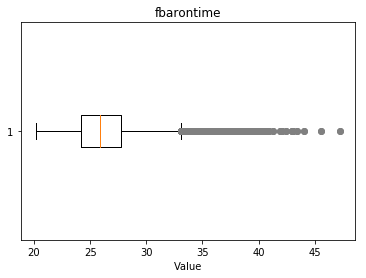

-------------------- 
Outlier detection:
 --------------------
List of outliers: {38.28, 37.55, 37.68, 38.34, 39.36, 38.78, 38.84, 38.49, 40.72, 38.07, 38.35, 38.1, 39.97, 40.71, 40.52, 42.95, 42.93, 45.55, 47.26, 37.82, 39.05, 37.58, 38.08, 37.09, 40.56, 39.33, 37.62, 37.63, 37.88, 39.61, 37.37, 37.93, 37.52, 37.95, 37.45, 38.3, 38.83, 38.36, 38.18, 38.74, 39.69, 39.86, 39.49, 38.87, 39.42, 40.18, 40.37, 40.77, 40.32, 39.43, 40.09, 40.27, 40.67, 40.41, 41.25, 38.38, 41.91, 38.13, 42.01, 42.45, 42.09, 37.65, 43.08, 43.42, 37.9, 44.07, 37.91, 38.65, 37.92, 39.4, 38.67, 37.19, 38.44, 39.18, 37.71, 40.93, 37.06, 39.95, 39.45, 38.47, 37.54, 37.75, 38.26, 37.27, 39.0, 37.53, 39.51, 37.79}


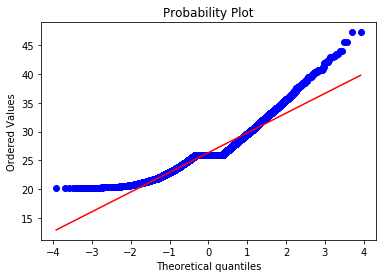

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.0678
Kurtosis: 1.8979
Overview of variable:  teambaronkills 


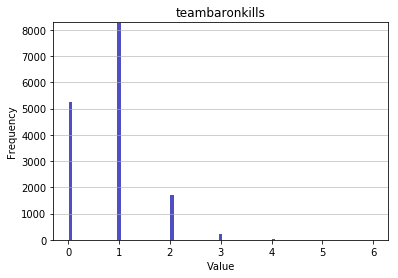

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.8077
Standard deviation: 0.7026
Median: 1.0
Maximal value: 6.0


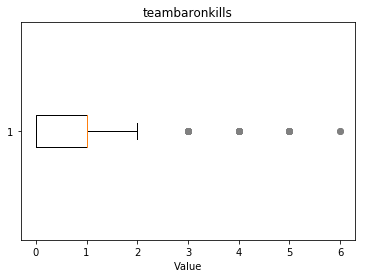

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.0, 4.0, 5.0, 6.0}


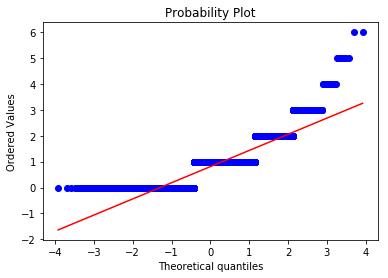

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7567
Kurtosis: 1.4334
Overview of variable:  dmgtochamps 


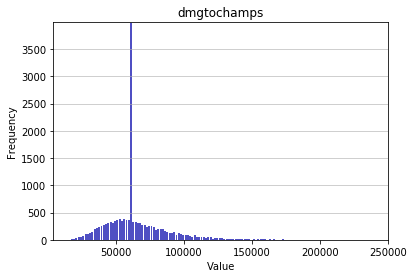

-------------------- 
Summary statistics:
 --------------------
Minimum value: 14879.0
Mean: 64960.2482
Standard deviation: 23452.0077
Median: 61472.0
Maximal value: 239076.0


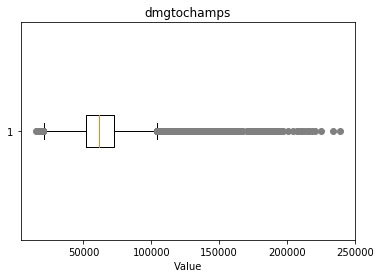

-------------------- 
Outlier detection:
 --------------------
List of outliers: {152069.0, 143880.0, 186381.0, 148498.0, 186899.0, 215570.0, 146450.0, 136223.0, 173088.0, 148515.0, 138788.0, 165924.0, 141347.0, 136231.0, 225320.0, 154153.0, 146474.0, 190000.0, 135729.0, 209973.0, 155189.0, 171575.0, 144953.0, 138811.0, 137276.0, 136255.0, 136767.0, 136261.0, 144976.0, 180306.0, 152660.0, 189528.0, 181337.0, 143961.0, 136286.0, 153694.0, 139361.0, 147554.0, 164962.0, 157284.0, 207464.0, 149100.0, 172656.0, 173685.0, 147063.0, 142456.0, 173687.0, 145530.0, 146553.0, 140926.0, 158337.0, 177282.0, 136839.0, 174216.0, 191113.0, 188040.0, 163465.0, 160910.0, 145041.0, 150674.0, 148632.0, 173209.0, 135321.0, 170649.0, 196761.0, 155293.0, 144542.0, 136858.0, 179872.0, 192673.0, 143008.0, 137889.0, 143013.0, 147622.0, 208039.0, 190119.0, 138919.0, 151210.0, 159916.0, 174257.0, 176306.0, 185525.0, 156341.0, 220344.0, 142013.0, 136383.0, 153279.0, 165057.0, 139457.0, 140483.0, 154308.0, 156865.0

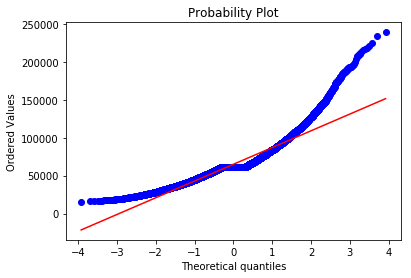

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.5746
Kurtosis: 4.86
Overview of variable:  dmgtochampsperminute 


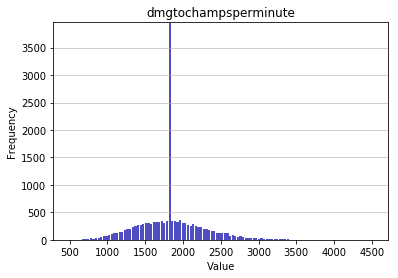

-------------------- 
Summary statistics:
 --------------------
Minimum value: 484.6111869031378
Mean: 1838.1988
Standard deviation: 426.2759
Median: 1821.5865
Maximal value: 4517.736549165121


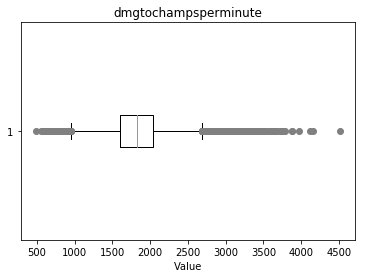

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3587.16, 3589.58, 3601.34, 4122.03, 548.28, 3631.59, 3121.77, 3121.47, 3121.87, 3124.37, 3636.02, 3124.52, 3127.6, 3124.85, 3131.28, 3134.41, 3136.99, 4161.35, 3140.78, 3140.45, 3142.05, 3144.45, 3145.96, 3146.7, 3147.55, 3146.27, 3662.97, 3158.04, 3161.14, 3674.42, 3169.45, 3170.87, 3176.44, 3177.67, 3178.18, 3178.06, 3183.1, 3186.58, 3186.19, 3193.68, 3197.3, 3200.13, 3202.46, 3205.42, 3718.88, 3212.15, 3213.78, 3214.29, 3220.51, 3220.13, 3223.75, 3225.26, 3225.35, 3229.3, 3231.74, 3232.61, 3232.9, 3231.05, 3235.61, 3753.4, 3242.43, 3242.98, 3759.69, 3760.67, 3250.37, 3252.61, 3263.13, 3266.84, 3267.0, 3780.57, 3269.03, 3279.15, 3292.61, 3293.82, 3295.62, 3308.04, 3320.65, 3323.51, 3323.09, 3325.61, 3334.33, 3336.77, 3338.36, 3338.76, 3345.81, 3345.45, 3353.06, 3359.71, 3363.57, 3876.62, 3365.19, 3882.92, 3372.45, 3373.83, 3374.58, 3375.87, 3383.64, 3390.11, 3392.57, 3400.26, 3413.27, 3414.21, 3425.08, 

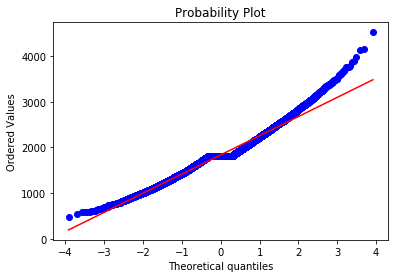

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4845
Kurtosis: 1.2897
Overview of variable:  wards 


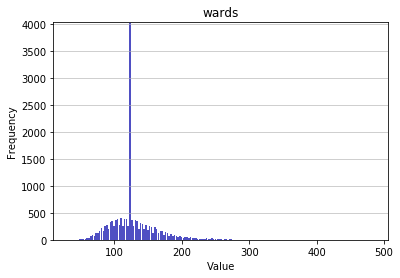

-------------------- 
Summary statistics:
 --------------------
Minimum value: 32.0
Mean: 128.8516
Standard deviation: 35.5988
Median: 124.0
Maximal value: 484.0


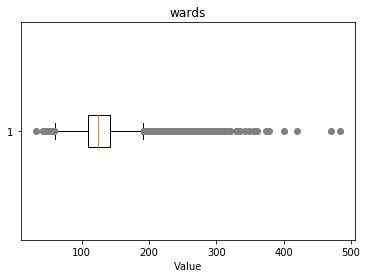

-------------------- 
Outlier detection:
 --------------------
List of outliers: {256.0, 257.0, 258.0, 259.0, 260.0, 261.0, 262.0, 263.0, 264.0, 265.0, 266.0, 267.0, 268.0, 269.0, 270.0, 271.0, 400.0, 273.0, 274.0, 275.0, 272.0, 279.0, 282.0, 284.0, 285.0, 287.0, 288.0, 289.0, 290.0, 291.0, 420.0, 295.0, 378.0, 298.0, 300.0, 301.0, 302.0, 303.0, 304.0, 308.0, 309.0, 310.0, 312.0, 314.0, 315.0, 321.0, 330.0, 334.0, 335.0, 343.0, 471.0, 374.0, 349.0, 354.0, 484.0, 358.0, 361.0, 236.0, 237.0, 238.0, 239.0, 240.0, 241.0, 242.0, 243.0, 244.0, 245.0, 246.0, 247.0, 248.0, 249.0, 250.0, 251.0, 252.0, 253.0, 254.0, 255.0}


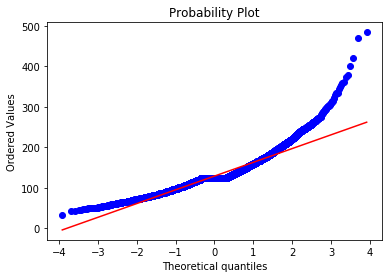

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.3851
Kurtosis: 4.7505
Overview of variable:  wpm 


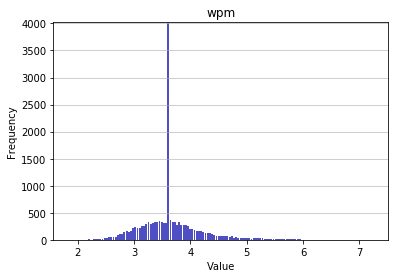

-------------------- 
Summary statistics:
 --------------------
Minimum value: 1.8391959798994977
Mean: 3.6532
Standard deviation: 0.551
Median: 3.6013
Maximal value: 7.245101959216314


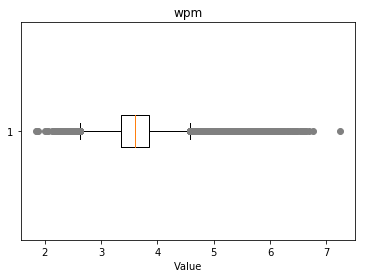

-------------------- 
Outlier detection:
 --------------------
List of outliers: {1.88, 1.84, 2.0, 1.86, 5.53, 5.75, 5.5, 5.78, 6.64, 5.93, 6.59, 6.57, 5.66, 5.43, 6.1, 7.25, 5.32, 5.57, 5.82, 6.43, 6.07, 6.0, 6.25, 6.32, 5.84, 5.59, 5.61, 5.54, 5.36, 5.86, 5.72, 6.04, 6.36, 5.97, 5.47, 5.79, 6.54, 5.76, 5.33, 5.4, 5.65, 5.83, 6.4, 6.76, 5.58, 5.9, 5.51, 5.91, 5.62, 5.87, 5.44, 5.94, 5.55, 6.3, 6.12, 6.19, 5.8, 6.44, 5.98, 5.52, 5.77, 5.34, 5.41, 6.09, 6.16, 6.02, 6.48, 5.48, 5.81, 5.31, 5.56, 5.88, 5.38, 5.45, 6.2, 5.63, 5.95, 5.7, 6.63, 6.06, 6.7, 5.99, 5.6, 5.49, 5.35, 5.85, 6.24, 5.92, 5.67, 5.42, 5.74, 6.17, 5.71, 5.64, 5.96, 5.89, 5.39, 6.03, 6.46, 6.53, 5.46, 6.14}


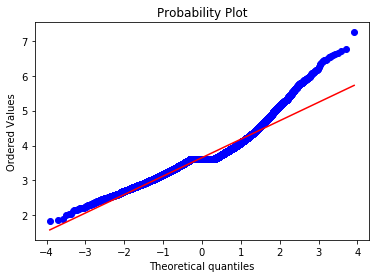

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.1135
Kurtosis: 3.0418
Overview of variable:  wardshare 


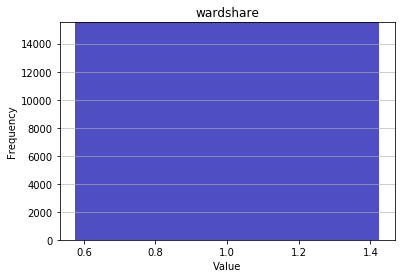

-------------------- 
Summary statistics:
 --------------------
Minimum value: 1.0
Mean: 1.0
Standard deviation: 0.0
Median: 1.0
Maximal value: 1.0


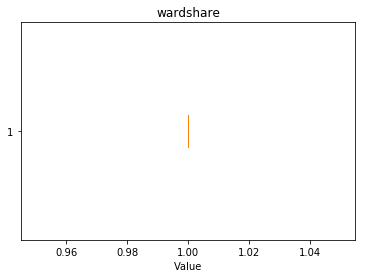

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


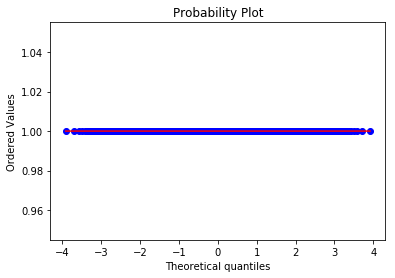

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -3.0
Overview of variable:  wardkills 


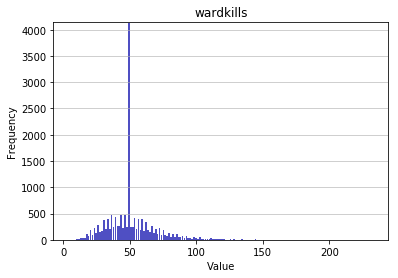

-------------------- 
Summary statistics:
 --------------------
Minimum value: 4.0
Mean: 51.1577
Standard deviation: 18.9769
Median: 49.0
Maximal value: 233.0


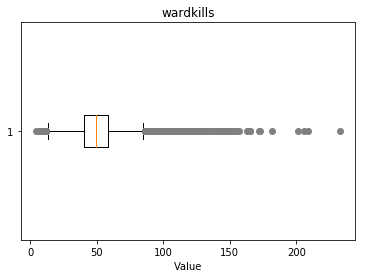

-------------------- 
Outlier detection:
 --------------------
List of outliers: {128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 140.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 149.0, 150.0, 152.0, 153.0, 154.0, 155.0, 157.0, 163.0, 164.0, 165.0, 172.0, 173.0, 182.0, 201.0, 206.0, 209.0, 233.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0}


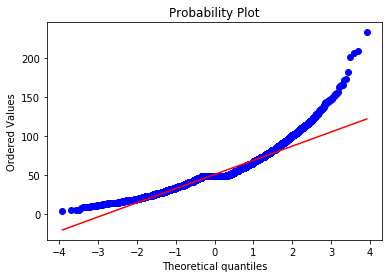

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.3458
Kurtosis: 4.4197
Overview of variable:  wcpm 


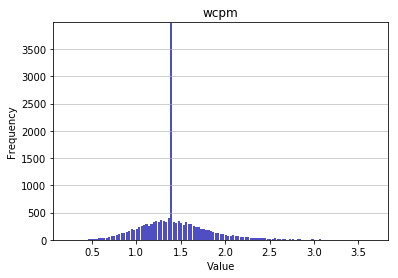

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.23715415019762845
Mean: 1.4314
Standard deviation: 0.3679
Median: 1.3988
Maximal value: 3.6673773987206824


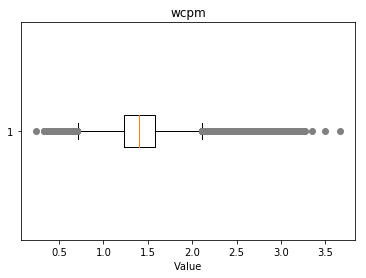

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.24, 2.91, 2.57, 2.55, 3.67, 2.69, 3.17, 2.81, 2.85, 2.93, 3.21, 2.84, 2.75, 2.59, 2.58, 2.74, 3.16, 3.0, 3.25, 2.66, 3.08, 3.01, 3.24, 3.5, 2.67, 3.26, 2.92, 2.78, 3.09, 2.99, 2.71, 2.82, 2.95, 2.61, 2.68, 2.77, 2.86, 2.6, 3.02, 3.1, 3.11, 3.03, 3.27, 3.35, 2.89, 2.63, 2.62, 2.7, 2.88, 2.54, 2.79, 3.05, 2.96, 2.8, 2.87, 2.76, 3.12, 2.72, 2.83, 2.73, 2.65, 2.97, 2.9, 2.56, 3.15, 3.07, 3.06, 2.98, 2.64, 0.32}


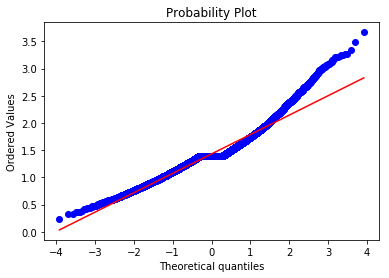

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8837
Kurtosis: 2.3032
Overview of variable:  visionwards 


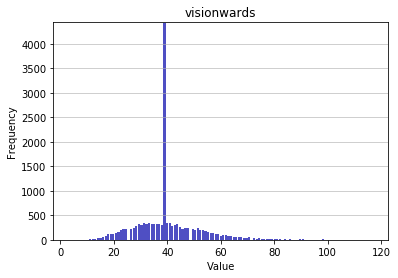

-------------------- 
Summary statistics:
 --------------------
Minimum value: 3.0
Mean: 40.1546
Standard deviation: 12.3124
Median: 39.0
Maximal value: 117.0


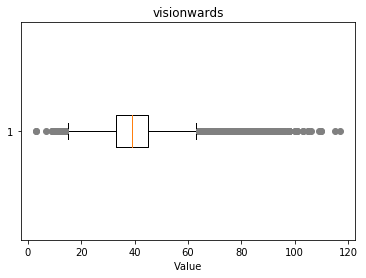

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 100.0, 101.0, 103.0, 105.0, 106.0, 109.0, 110.0, 115.0, 117.0}


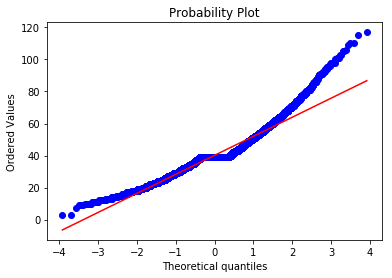

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.9521
Kurtosis: 2.3781
Overview of variable:  visionwardbuys 


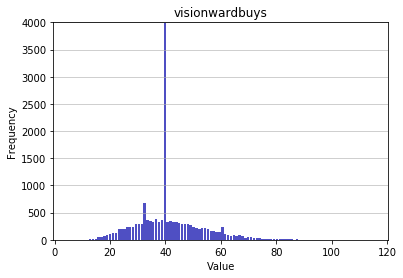

-------------------- 
Summary statistics:
 --------------------
Minimum value: 5.0
Mean: 41.2439
Standard deviation: 11.8182
Median: 40.0
Maximal value: 115.0


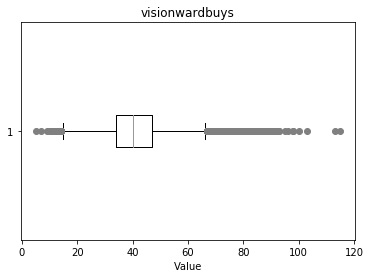

-------------------- 
Outlier detection:
 --------------------
List of outliers: {5.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 95.0, 96.0, 98.0, 100.0, 103.0, 113.0, 115.0}


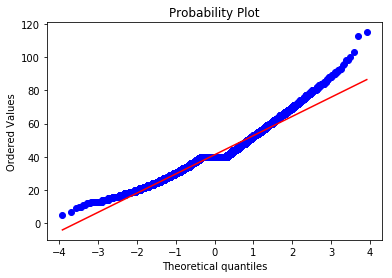

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7058
Kurtosis: 1.3173
Overview of variable:  visiblewardclearrate 


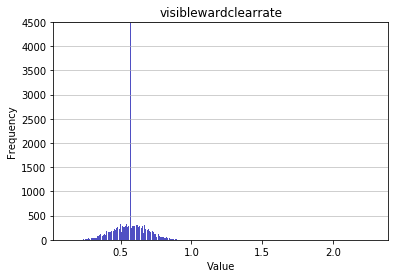

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.13333333333333333
Mean: 0.5692
Standard deviation: 0.1106
Median: 0.5714
Maximal value: 2.282051282051282


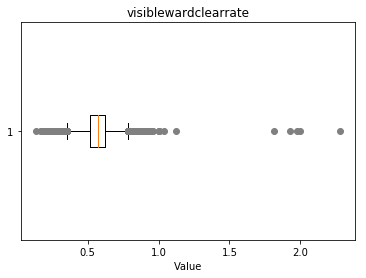

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.93, 1.0, 0.92, 0.94, 0.2, 0.9, 0.19, 1.04, 1.81, 1.12, 1.98, 2.28, 2.0, 1.93, 0.95, 0.23, 0.96, 0.17, 0.22, 0.21, 0.13, 0.24, 0.91}


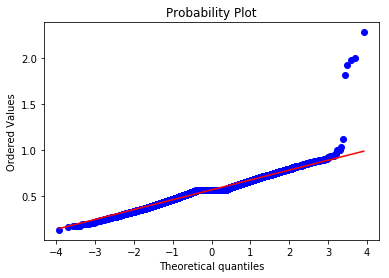

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.6557
Kurtosis: 10.1315
Overview of variable:  invisiblewardclearrate 


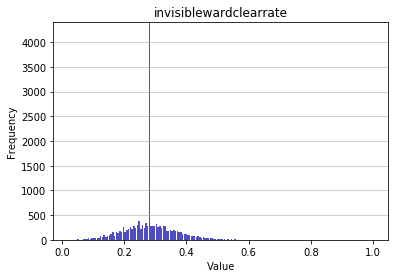

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.02127659574468085
Mean: 0.2822
Standard deviation: 0.075
Median: 0.2798
Maximal value: 1.0


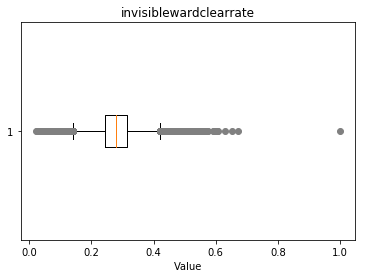

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.05, 0.55, 0.51, 0.6, 0.54, 0.67, 0.52, 0.59, 0.53, 0.56, 0.63, 0.61, 0.65, 0.57, 1.0, 0.03, 0.04, 0.02, 0.58, 0.06}


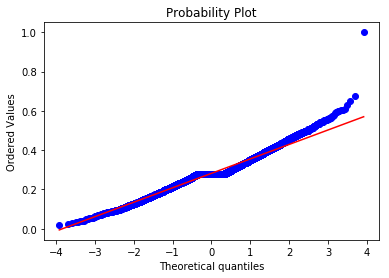

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3621
Kurtosis: 1.6594
Overview of variable:  totalgold 


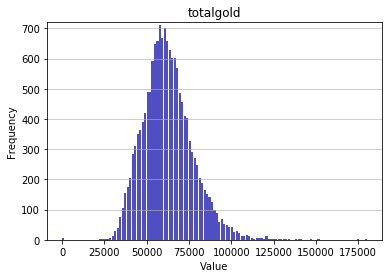

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 62443.786
Standard deviation: 14664.6785
Median: 61198.0
Maximal value: 180057.0


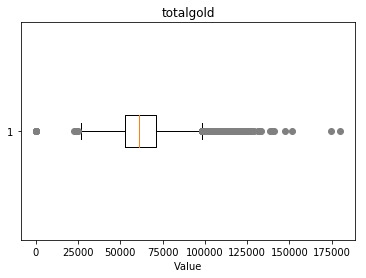

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.0, 115202.0, 115719.0, 108045.0, 118800.0, 113680.0, 115216.0, 120851.0, 112660.0, 109600.0, 112162.0, 110114.0, 117800.0, 140842.0, 117808.0, 108603.0, 108100.0, 109138.0, 138324.0, 111200.0, 129121.0, 121443.0, 111206.0, 110700.0, 110701.0, 116336.0, 133237.0, 112246.0, 113271.0, 108672.0, 122500.0, 131205.0, 109705.0, 121487.0, 113300.0, 112276.0, 107178.0, 116908.0, 109743.0, 107700.0, 109750.0, 126135.0, 108216.0, 125625.0, 110266.0, 109248.0, 121538.0, 115908.0, 118984.0, 123595.0, 106700.0, 111821.0, 114382.0, 120533.0, 115418.0, 106723.0, 132329.0, 120590.0, 139556.0, 109356.0, 110382.0, 119601.0, 108850.0, 121146.0, 151354.0, 147262.0, 107335.0, 107336.0, 108362.0, 116558.0, 109903.0, 120145.0, 180057.0, 110430.0, 110435.0, 108900.0, 107876.0, 117613.0, 107374.0, 117614.0, 106869.0, 108408.0, 108411.0, 112509.0, 109962.0, 120203.0, 115091.0, 127385.0, 115616.0, 122273.0, 107457.0, 116176.0, 121

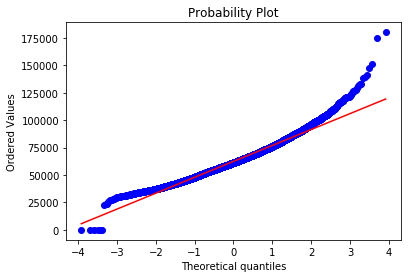

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.6631
Kurtosis: 1.4759
Overview of variable:  earnedgpm 


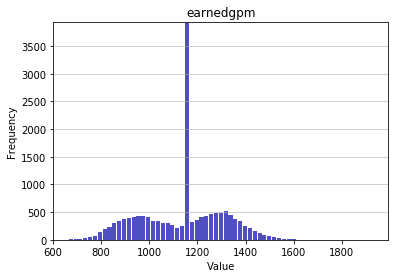

-------------------- 
Summary statistics:
 --------------------
Minimum value: 663.4919748778785
Mean: 1138.7123
Standard deviation: 171.4964
Median: 1151.289
Maximal value: 1931.5423983943804


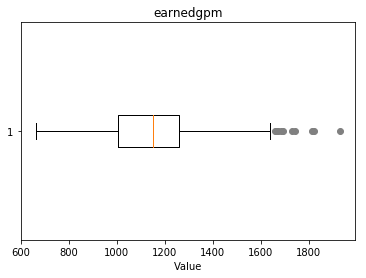

-------------------- 
Outlier detection:
 --------------------
List of outliers: {1824.14, 1729.82, 1666.73, 1671.6, 1931.54, 1743.77, 1684.0, 1816.2, 1658.03, 1691.99}


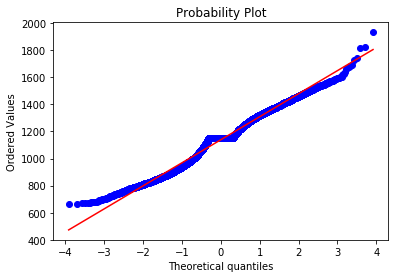

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0959
Kurtosis: -0.4127
Overview of variable:  goldspent 


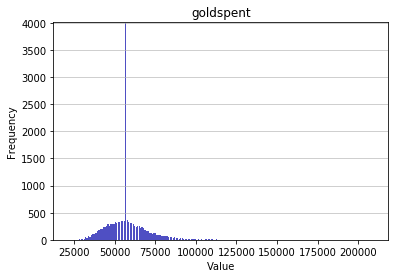

-------------------- 
Summary statistics:
 --------------------
Minimum value: 21710.0
Mean: 57627.5029
Standard deviation: 12375.9254
Median: 56500.0
Maximal value: 209091.0


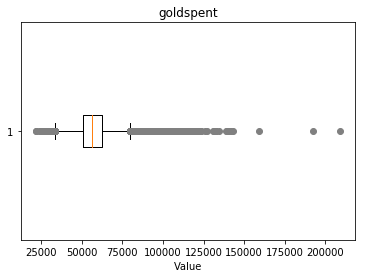

-------------------- 
Outlier detection:
 --------------------
List of outliers: {105985.0, 109575.0, 95758.0, 98835.0, 119320.0, 101913.0, 117275.0, 98845.0, 139805.0, 108580.0, 94758.0, 96808.0, 94763.0, 127023.0, 107060.0, 94782.0, 101440.0, 95808.0, 99393.0, 96325.0, 115270.0, 106053.0, 96840.0, 95305.0, 98890.0, 94795.0, 99403.0, 105545.0, 132680.0, 100435.0, 98900.0, 115285.0, 131667.0, 119383.0, 95316.0, 95320.0, 109660.0, 95333.0, 192101.0, 102395.0, 97893.0, 122985.0, 113770.0, 103020.0, 109678.0, 104558.0, 110198.0, 112759.0, 98425.0, 98943.0, 118915.0, 103050.0, 134796.0, 97933.0, 115858.0, 96408.0, 111260.0, 95900.0, 101538.0, 97445.0, 98475.0, 99500.0, 99499.0, 95410.0, 101043.0, 118450.0, 104626.0, 96950.0, 117435.0, 107709.0, 209091.0, 95428.0, 95945.0, 94925.0, 108760.0, 95965.0, 99550.0, 112863.0, 95458.0, 94950.0, 112358.0, 115430.0, 106217.0, 158958.0, 96495.0, 109806.0, 138993.0, 97525.0, 139513.0, 125690.0, 123131.0, 99068.0, 97023.0, 111876.0, 119566.0, 103695.0, 

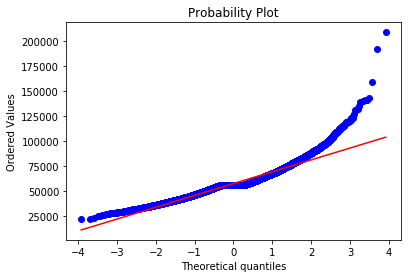

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.3104
Kurtosis: 5.8707
Overview of variable:  gspd 


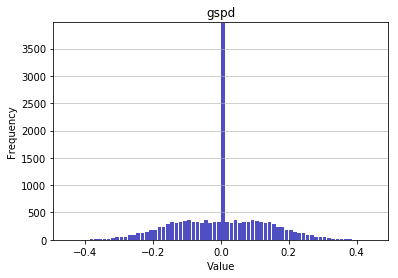

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.44961423351416446
Mean: 0.0
Standard deviation: 0.1278
Median: 0.0
Maximal value: 0.44961423351416446


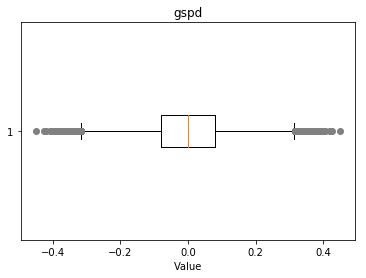

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.39, -0.39, 0.38, -0.41, -0.38, 0.41, -0.42, 0.42, -0.4, 0.4, -0.43, -0.45, 0.43, 0.45}


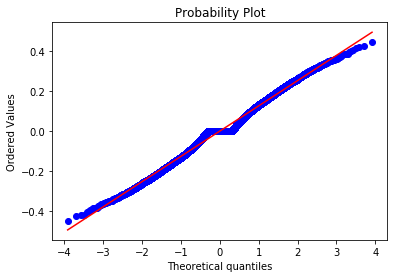

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 0.1166
Overview of variable:  minionkills 


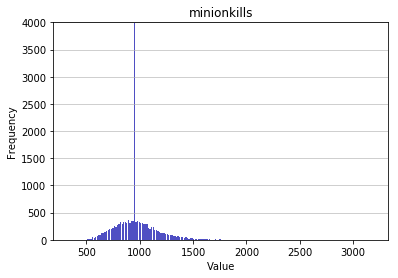

-------------------- 
Summary statistics:
 --------------------
Minimum value: 332.0
Mean: 965.0269
Standard deviation: 191.2456
Median: 949.5
Maximal value: 3188.0


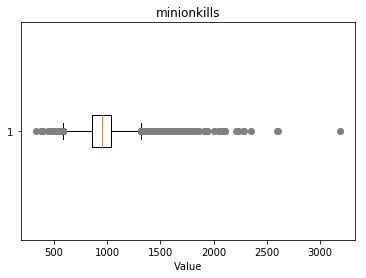

-------------------- 
Outlier detection:
 --------------------
List of outliers: {1539.0, 1541.0, 1544.0, 1545.0, 1546.0, 1547.0, 1548.0, 1549.0, 1550.0, 1552.0, 1553.0, 1554.0, 1556.0, 2069.0, 1558.0, 1557.0, 1560.0, 1561.0, 1559.0, 1563.0, 1564.0, 1565.0, 1567.0, 1568.0, 1569.0, 1570.0, 2082.0, 2596.0, 1573.0, 1575.0, 1576.0, 1577.0, 2602.0, 1584.0, 1586.0, 1587.0, 1588.0, 1589.0, 1590.0, 1591.0, 1593.0, 1594.0, 1597.0, 2110.0, 1599.0, 2112.0, 1601.0, 1598.0, 1603.0, 1602.0, 1607.0, 1608.0, 1611.0, 1612.0, 1613.0, 1615.0, 1617.0, 1618.0, 1619.0, 1620.0, 1621.0, 1623.0, 1625.0, 1627.0, 1628.0, 1631.0, 1632.0, 1633.0, 1638.0, 1643.0, 1644.0, 1648.0, 1649.0, 1650.0, 3188.0, 1652.0, 1655.0, 1657.0, 1666.0, 1672.0, 1678.0, 1682.0, 1688.0, 1689.0, 1692.0, 2206.0, 1695.0, 1705.0, 1708.0, 1709.0, 1710.0, 1711.0, 1713.0, 2228.0, 2230.0, 1719.0, 1718.0, 1726.0, 1731.0, 1735.0, 1747.0, 1750.0, 1753.0, 1754.0, 1755.0, 1758.0, 1760.0, 1763.0, 1767.0, 2280.0, 1773.0, 1775.0, 2290.0, 1779.0, 1785.0

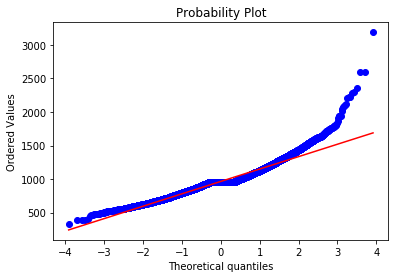

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.0898
Kurtosis: 4.4472
Overview of variable:  monsterkills 


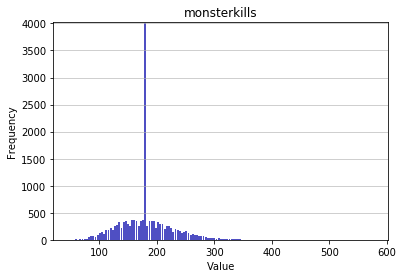

-------------------- 
Summary statistics:
 --------------------
Minimum value: 47.0
Mean: 182.8134
Standard deviation: 46.1706
Median: 180.0
Maximal value: 576.0


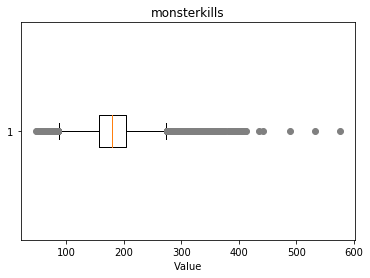

-------------------- 
Outlier detection:
 --------------------
List of outliers: {386.0, 387.0, 389.0, 392.0, 393.0, 394.0, 398.0, 400.0, 405.0, 533.0, 406.0, 409.0, 411.0, 412.0, 435.0, 442.0, 576.0, 322.0, 323.0, 324.0, 325.0, 326.0, 327.0, 328.0, 329.0, 330.0, 331.0, 332.0, 333.0, 334.0, 335.0, 336.0, 337.0, 338.0, 339.0, 340.0, 341.0, 342.0, 343.0, 344.0, 345.0, 347.0, 348.0, 349.0, 352.0, 353.0, 354.0, 356.0, 357.0, 488.0, 360.0, 362.0, 363.0, 366.0, 368.0, 370.0, 372.0, 373.0, 374.0, 375.0, 381.0, 383.0}


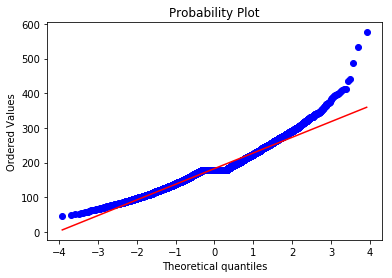

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7069
Kurtosis: 1.9925
Overview of variable:  monsterkillsownjungle 


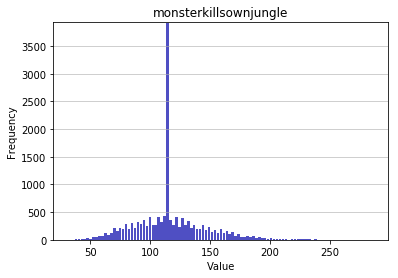

-------------------- 
Summary statistics:
 --------------------
Minimum value: 32.0
Mean: 117.0864
Standard deviation: 29.8523
Median: 115.0
Maximal value: 286.0


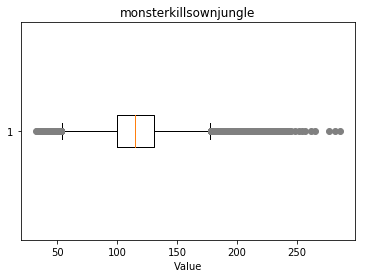

-------------------- 
Outlier detection:
 --------------------
List of outliers: {257.0, 262.0, 265.0, 277.0, 282.0, 286.0, 207.0, 208.0, 209.0, 210.0, 211.0, 212.0, 213.0, 214.0, 215.0, 216.0, 218.0, 219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 225.0, 226.0, 227.0, 228.0, 229.0, 230.0, 231.0, 232.0, 233.0, 234.0, 236.0, 237.0, 238.0, 239.0, 241.0, 243.0, 245.0, 248.0, 252.0, 254.0}


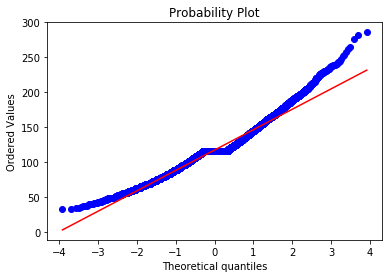

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.6238
Kurtosis: 1.2691
Overview of variable:  monsterkillsenemyjungle 


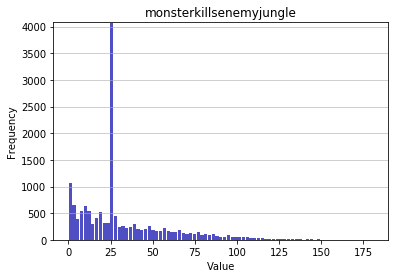

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 32.3633
Standard deviation: 26.7227
Median: 26.0
Maximal value: 181.0


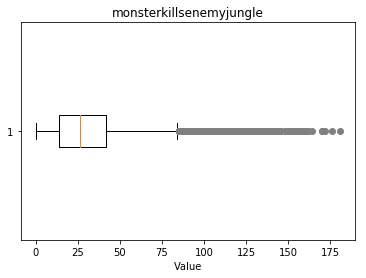

-------------------- 
Outlier detection:
 --------------------
List of outliers: {128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 148.0, 149.0, 150.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 162.0, 164.0, 170.0, 172.0, 176.0, 181.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0}


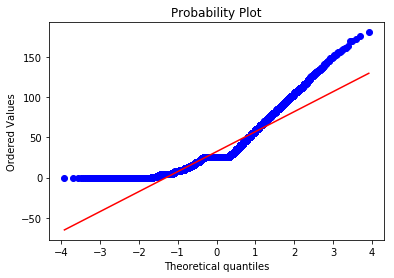

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.4236
Kurtosis: 2.1952
Overview of variable:  cspm 


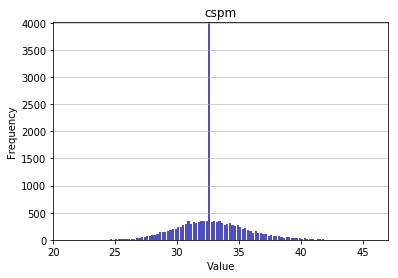

-------------------- 
Summary statistics:
 --------------------
Minimum value: 21.239288068556363
Mean: 32.8024
Standard deviation: 2.5682
Median: 32.6904
Maximal value: 45.850476668339184


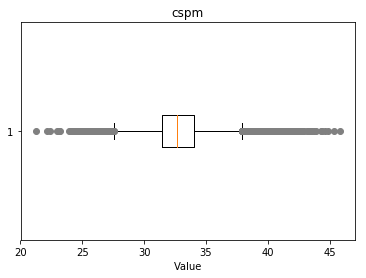

-------------------- 
Outlier detection:
 --------------------
List of outliers: {41.75, 21.24, 22.98, 23.9, 24.64, 25.07, 24.14, 24.22, 24.72, 24.93, 25.09, 24.68, 24.56, 24.76, 25.06, 41.26, 40.57, 40.51, 41.39, 40.64, 41.76, 41.01, 42.19, 42.56, 40.67, 41.7, 42.78, 43.56, 45.85, 45.38, 40.53, 42.51, 41.77, 40.79, 43.76, 40.55, 41.54, 41.55, 22.15, 22.4, 23.1, 24.83, 25.08, 40.84, 42.08, 40.6, 40.91, 40.54, 40.97, 40.8, 41.69, 41.51, 41.87, 41.97, 41.46, 42.82, 42.93, 41.9, 41.02, 41.03, 43.44, 42.32, 42.06, 42.43, 43.24, 44.64, 43.34, 43.14, 44.41, 44.91, 44.33, 41.36, 40.61, 41.59, 41.88, 41.38, 40.65, 41.16, 41.66, 40.93, 40.68, 40.69, 23.23, 24.37, 24.3, 24.06, 24.31, 24.73, 43.91, 24.44, 41.19, 40.95, 40.72, 41.71, 42.7, 41.48, 42.47, 40.86}


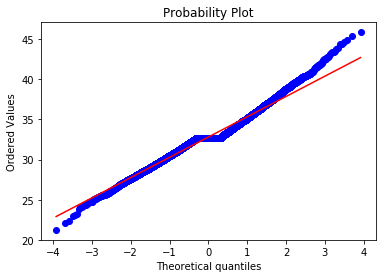

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3162
Kurtosis: 1.2216
Overview of variable:  goldat10 


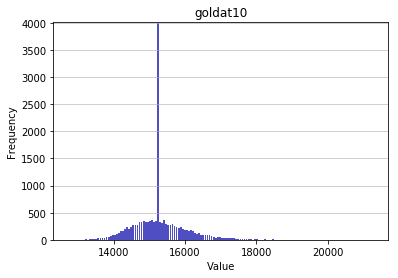

-------------------- 
Summary statistics:
 --------------------
Minimum value: 12737.0
Mean: 15294.5851
Standard deviation: 746.0531
Median: 15229.0
Maximal value: 21281.0


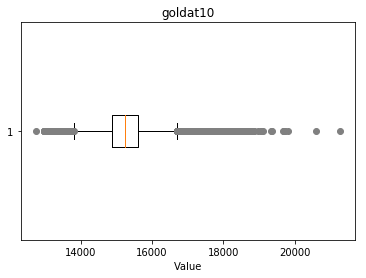

-------------------- 
Outlier detection:
 --------------------
List of outliers: {18453.0, 18965.0, 17941.0, 17944.0, 18457.0, 17947.0, 18470.0, 17975.0, 17977.0, 17978.0, 18496.0, 18497.0, 18498.0, 17991.0, 17996.0, 18515.0, 18003.0, 18006.0, 18018.0, 18023.0, 19050.0, 18033.0, 18548.0, 18038.0, 20599.0, 19068.0, 17540.0, 18564.0, 17542.0, 18058.0, 17554.0, 17555.0, 12957.0, 18077.0, 17565.0, 17568.0, 17570.0, 12962.0, 12965.0, 18086.0, 12966.0, 17573.0, 17579.0, 17581.0, 17582.0, 17585.0, 12979.0, 17587.0, 17589.0, 19129.0, 17593.0, 17595.0, 17596.0, 17594.0, 17598.0, 17599.0, 18111.0, 17607.0, 17608.0, 13008.0, 18644.0, 17620.0, 17621.0, 17623.0, 18136.0, 18650.0, 17627.0, 17628.0, 19678.0, 18656.0, 18144.0, 13028.0, 18148.0, 17640.0, 18155.0, 17645.0, 13040.0, 13042.0, 19701.0, 17654.0, 17653.0, 17655.0, 13050.0, 17660.0, 18175.0, 17666.0, 18690.0, 19716.0, 17669.0, 18182.0, 18694.0, 18696.0, 19720.0, 17679.0, 17682.0, 17697.0, 21281.0, 17704.0, 18219.0, 17707.0, 17709.0, 18222.0, 

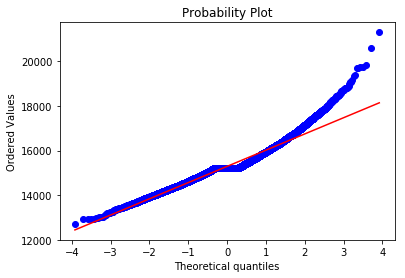

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8704
Kurtosis: 2.6583
Overview of variable:  gdat10 


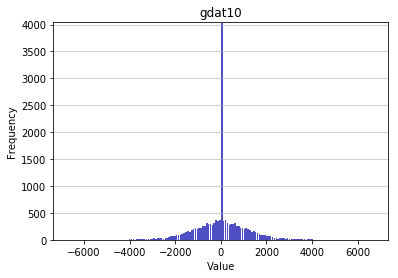

-------------------- 
Summary statistics:
 --------------------
Minimum value: -6674.0
Mean: 0.0
Standard deviation: 1123.8557
Median: 0.0
Maximal value: 6674.0


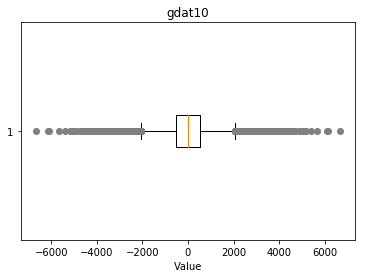

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4096.0, -4096.0, -4093.0, -4601.0, 3596.0, 5133.0, 3599.0, -3568.0, -4592.0, 6674.0, 5650.0, -4590.0, 4117.0, 6159.0, -3561.0, -3548.0, -3546.0, -5080.0, -3543.0, 3625.0, 5162.0, -4054.0, -3539.0, -4562.0, 3631.0, 3635.0, -6089.0, 4157.0, -4034.0, 4671.0, 3647.0, 3649.0, -4030.0, -3517.0, 3650.0, 3652.0, -4533.0, 3664.0, -5033.0, -3497.0, -3488.0, 4706.0, -3485.0, -3483.0, 3687.0, 4711.0, -4503.0, -3992.0, -5012.0, -3981.0, 3699.0, -3467.0, -3465.0, -3462.0, 3706.0, 4221.0, -3450.0, -3959.0, -3955.0, -4466.0, 4246.0, -3433.0, -3944.0, -3939.0, -3938.0, 3749.0, -3926.0, -4436.0, -4432.0, 3765.0, -3402.0, -3915.0, -3396.0, -3907.0, 3776.0, -3391.0, -3901.0, -4412.0, 3782.0, -3385.0, 3789.0, -3377.0, -3887.0, -3372.0, 3800.0, -3877.0, 3810.0, -3869.0, 4324.0, -3860.0, 3821.0, -4370.0, -5394.0, -3856.0, -3859.0, 3828.0, -3842.0, -4866.0, 3839.0, -3839.0, 4866.0, 3842.0, -3828.0, 3856.0, 4370.0, -3821.0, 3860.

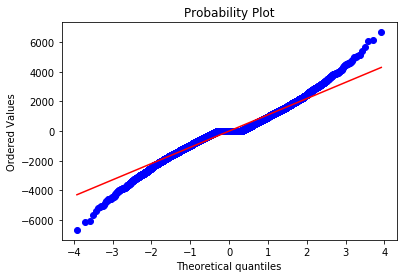

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 2.2988
Overview of variable:  goldat15 


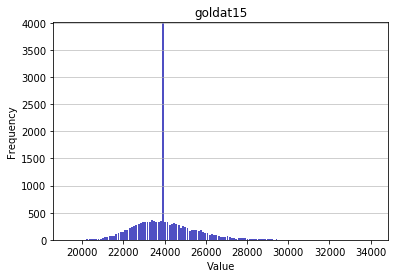

-------------------- 
Summary statistics:
 --------------------
Minimum value: 19336.0
Mean: 23998.3907
Standard deviation: 1381.1003
Median: 23874.5
Maximal value: 34121.0


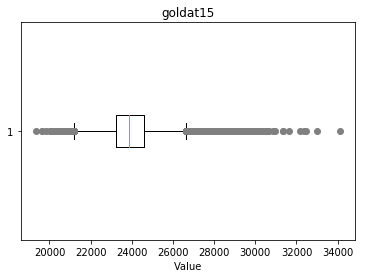

-------------------- 
Outlier detection:
 --------------------
List of outliers: {28160.0, 28161.0, 28163.0, 29190.0, 28679.0, 28680.0, 28169.0, 28681.0, 28173.0, 29198.0, 28174.0, 28178.0, 29716.0, 30228.0, 28181.0, 28693.0, 29209.0, 28698.0, 28699.0, 28185.0, 29215.0, 28193.0, 28197.0, 28210.0, 28211.0, 29749.0, 29237.0, 30263.0, 28728.0, 30268.0, 30279.0, 29256.0, 29258.0, 29772.0, 29261.0, 28756.0, 29270.0, 28760.0, 28761.0, 28255.0, 32356.0, 31333.0, 28776.0, 29801.0, 31338.0, 28272.0, 28275.0, 28285.0, 28286.0, 29312.0, 28291.0, 28804.0, 28806.0, 29831.0, 30344.0, 28297.0, 28298.0, 28301.0, 29838.0, 28817.0, 28818.0, 28307.0, 29844.0, 28309.0, 28315.0, 28316.0, 30880.0, 28834.0, 28325.0, 28842.0, 28332.0, 19633.0, 28339.0, 28340.0, 28341.0, 28342.0, 28345.0, 28869.0, 28873.0, 19657.0, 28365.0, 28369.0, 28884.0, 32476.0, 32997.0, 28390.0, 28395.0, 29421.0, 30960.0, 29426.0, 29429.0, 28408.0, 28411.0, 30463.0, 28417.0, 28930.0, 29442.0, 28934.0, 29464.0, 28443.0, 29474.0, 28453.0, 

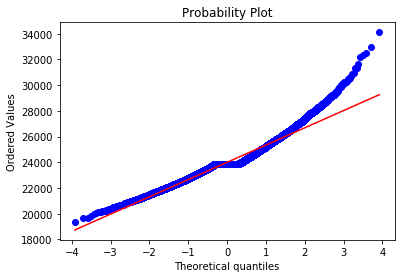

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8327
Kurtosis: 2.2181
Overview of variable:  gdat15 


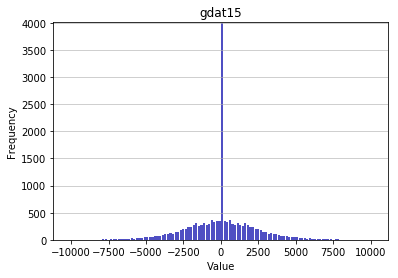

-------------------- 
Summary statistics:
 --------------------
Minimum value: -10178.0
Mean: 0.0
Standard deviation: 2242.4175
Median: 0.0
Maximal value: 10178.0


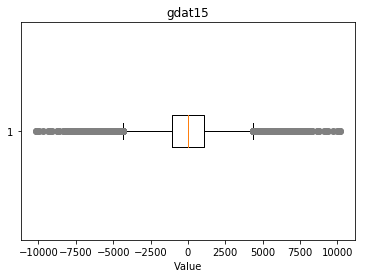

-------------------- 
Outlier detection:
 --------------------
List of outliers: {7169.0, -7675.0, -8697.0, 8716.0, -7668.0, -7154.0, 9233.0, -7662.0, -7150.0, -8168.0, 8741.0, 7213.0, 7217.0, -9678.0, -8141.0, -7116.0, -7627.0, -7110.0, -10178.0, -7613.0, 7754.0, -10163.0, 6736.0, 7249.0, 6741.0, 6745.0, 6749.0, 7261.0, -9120.0, 7776.0, -8602.0, -7064.0, 6760.0, 7787.0, -7058.0, 8304.0, 6769.0, 6776.0, -7046.0, 7292.0, -7039.0, -10108.0, 8326.0, 7305.0, 6794.0, -10097.0, 6801.0, -7021.0, -7015.0, 6810.0, -8035.0, 7327.0, 6816.0, 6825.0, -8021.0, 9388.0, -7507.0, 7343.0, 7344.0, 6831.0, 7860.0, -8010.0, -6984.0, 6842.0, 7868.0, 6846.0, 7875.0, 6855.0, 6862.0, 7380.0, 6871.0, -6950.0, 6878.0, 7390.0, -7455.0, -6940.0, -7449.0, -6936.0, 7402.0, 7924.0, 7415.0, 9976.0, 7417.0, -7417.0, -9976.0, -7415.0, -7924.0, -7402.0, 6936.0, 7449.0, 6940.0, 7455.0, -6878.0, -7390.0, 6950.0, -6871.0, -7380.0, -6862.0, -6855.0, -7875.0, -6846.0, -7868.0, -6842.0, 6984.0, 8010.0, -7860.0, -7344.0, -7343.

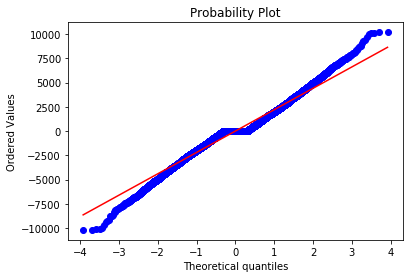

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.4796
Overview of variable:  xpat10 


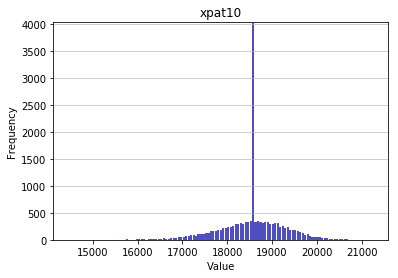

-------------------- 
Summary statistics:
 --------------------
Minimum value: 14456.0
Mean: 18542.5648
Standard deviation: 705.3473
Median: 18581.0
Maximal value: 21258.0


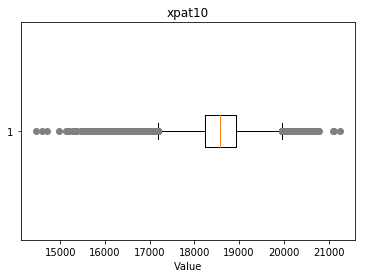

-------------------- 
Outlier detection:
 --------------------
List of outliers: {16384.0, 15873.0, 15367.0, 15880.0, 16393.0, 16394.0, 16397.0, 16399.0, 15890.0, 16413.0, 16415.0, 16419.0, 16420.0, 16425.0, 15915.0, 15918.0, 15924.0, 15939.0, 15957.0, 15960.0, 15962.0, 15973.0, 21094.0, 15976.0, 15982.0, 15472.0, 14966.0, 21111.0, 14456.0, 15483.0, 15999.0, 16004.0, 15495.0, 16008.0, 15496.0, 15501.0, 16016.0, 15508.0, 16029.0, 15519.0, 16031.0, 16050.0, 16051.0, 20664.0, 20669.0, 15559.0, 16078.0, 15568.0, 16083.0, 20693.0, 20699.0, 20702.0, 20707.0, 16100.0, 16101.0, 16106.0, 20715.0, 16113.0, 16116.0, 14590.0, 16134.0, 16135.0, 15626.0, 21258.0, 16144.0, 16145.0, 16148.0, 15128.0, 15641.0, 15644.0, 20767.0, 16162.0, 20784.0, 16182.0, 16191.0, 15169.0, 16201.0, 16206.0, 15695.0, 16216.0, 15715.0, 16227.0, 16231.0, 15208.0, 16235.0, 15724.0, 15727.0, 14704.0, 16241.0, 15730.0, 16240.0, 16248.0, 15737.0, 15741.0, 15743.0, 15745.0, 16258.0, 16259.0, 16261.0, 16263.0, 16264.0, 16266.0, 

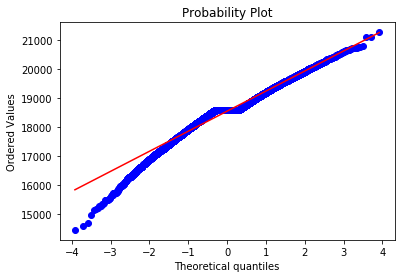

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.5513
Kurtosis: 1.6131
Overview of variable:  xpdat10 


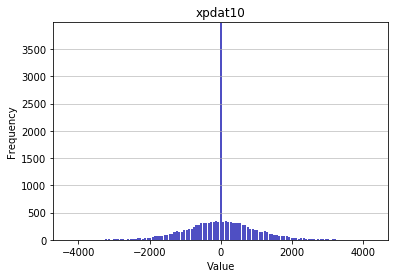

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4278.0
Mean: 0.0
Standard deviation: 888.8921
Median: 0.0
Maximal value: 4278.0


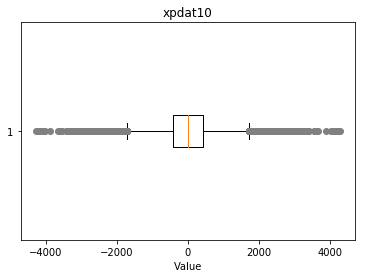

-------------------- 
Outlier detection:
 --------------------
List of outliers: {-3584.0, 3584.0, 3586.0, 3078.0, -4088.0, -3061.0, -3572.0, -3058.0, -3044.0, -3040.0, -3039.0, -3552.0, -3030.0, 3115.0, -3029.0, -3026.0, 4145.0, 3122.0, -3019.0, 3131.0, 3651.0, 4168.0, 3145.0, 3146.0, -2995.0, -4019.0, 3150.0, 3152.0, 3153.0, 3155.0, -2988.0, -2984.0, 3165.0, 3176.0, -2963.0, -2960.0, 4211.0, 3189.0, -2955.0, -2945.0, 2692.0, -2935.0, 3213.0, -2927.0, -2926.0, 3218.0, 2708.0, 2714.0, 2716.0, 3237.0, 2727.0, -3415.0, 2731.0, 3244.0, -2898.0, 3247.0, 2740.0, -2891.0, 4278.0, -2887.0, 2746.0, 3259.0, 2747.0, 2749.0, 2751.0, 3275.0, 2763.0, -2865.0, 2770.0, -2861.0, 2774.0, 2776.0, 2777.0, -2854.0, -2856.0, 2780.0, -2852.0, -2850.0, -3874.0, -3365.0, 2787.0, -2840.0, -3351.0, -2835.0, -3344.0, 2802.0, -3341.0, 3316.0, 2808.0, 2809.0, 2810.0, 3324.0, -2819.0, 2819.0, -3324.0, -2810.0, -2809.0, -2808.0, -3316.0, 3341.0, -2802.0, 3344.0, 2835.0, 3351.0, 2840.0, -2787.0, 2850.0, 3874.0, -2780

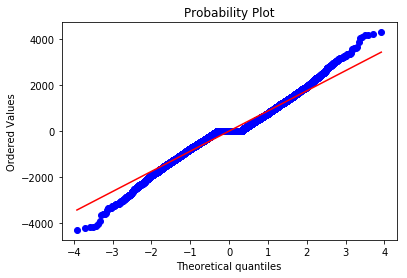

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.7073
Overview of variable:  csat10 


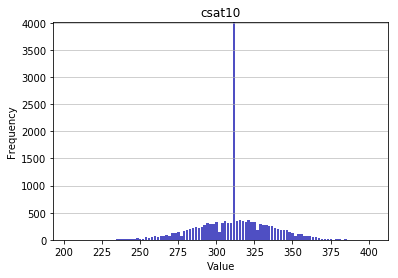

-------------------- 
Summary statistics:
 --------------------
Minimum value: 203.0
Mean: 311.6828
Standard deviation: 23.2477
Median: 312.0
Maximal value: 403.0


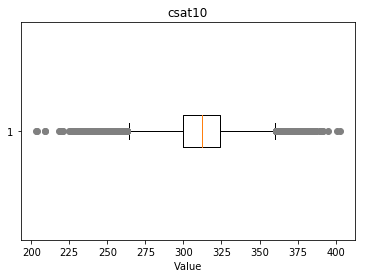

-------------------- 
Outlier detection:
 --------------------
List of outliers: {384.0, 385.0, 386.0, 387.0, 390.0, 391.0, 392.0, 395.0, 401.0, 403.0, 203.0, 204.0, 209.0, 218.0, 219.0, 220.0, 221.0, 225.0, 226.0, 227.0, 228.0, 229.0, 230.0, 231.0, 233.0, 234.0, 235.0, 236.0, 237.0, 238.0, 239.0, 240.0, 241.0, 382.0, 383.0}


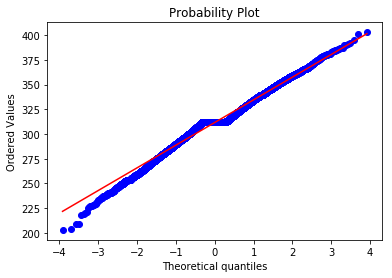

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.1905
Kurtosis: 0.7939
Overview of variable:  csdat10 


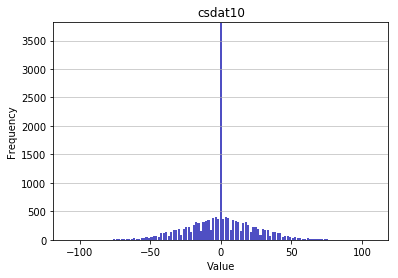

-------------------- 
Summary statistics:
 --------------------
Minimum value: -108.0
Mean: 0.0
Standard deviation: 23.0681
Median: 0.0
Maximal value: 108.0


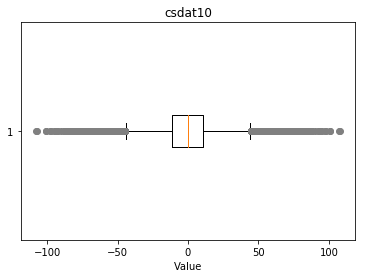

-------------------- 
Outlier detection:
 --------------------
List of outliers: {-108.0, -107.0, -101.0, -98.0, -97.0, -95.0, -94.0, -93.0, -92.0, -90.0, -88.0, -87.0, -85.0, -84.0, -83.0, -82.0, -81.0, -80.0, -79.0, -77.0, -76.0, -75.0, -74.0, -73.0, -72.0, -71.0, -70.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 87.0, 88.0, 90.0, 92.0, 93.0, 94.0, 95.0, 97.0, 98.0, 101.0, 107.0, 108.0}


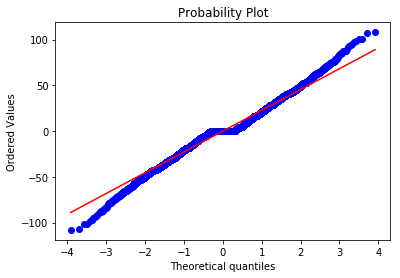

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.2442
Overview of variable:  csat15 


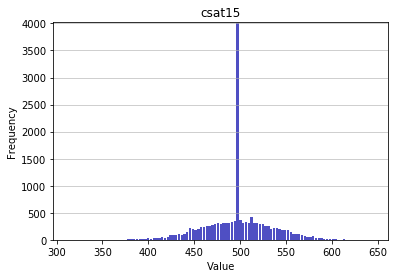

-------------------- 
Summary statistics:
 --------------------
Minimum value: 313.0
Mean: 497.0703
Standard deviation: 35.6044
Median: 497.0
Maximal value: 645.0


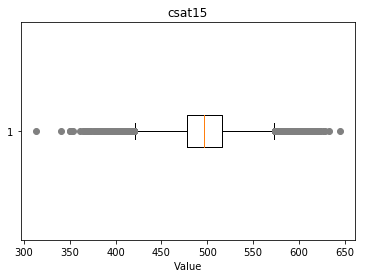

-------------------- 
Outlier detection:
 --------------------
List of outliers: {384.0, 385.0, 386.0, 387.0, 389.0, 390.0, 645.0, 615.0, 617.0, 351.0, 313.0, 371.0, 341.0, 373.0, 604.0, 350.0, 606.0, 608.0, 609.0, 354.0, 610.0, 612.0, 613.0, 611.0, 607.0, 616.0, 361.0, 618.0, 619.0, 620.0, 365.0, 366.0, 367.0, 368.0, 369.0, 370.0, 621.0, 372.0, 623.0, 622.0, 626.0, 376.0, 633.0, 378.0, 379.0, 380.0, 381.0, 629.0, 383.0}


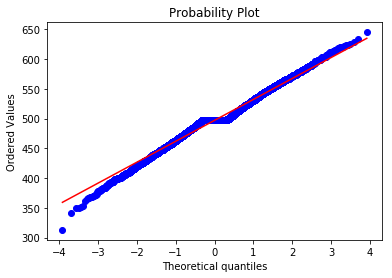

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0751
Kurtosis: 0.7938
Overview of variable:  csdat15 


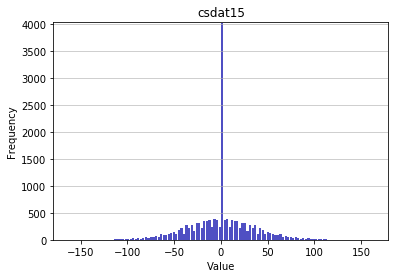

-------------------- 
Summary statistics:
 --------------------
Minimum value: -163.0
Mean: 0.0
Standard deviation: 33.7647
Median: 0.0
Maximal value: 163.0


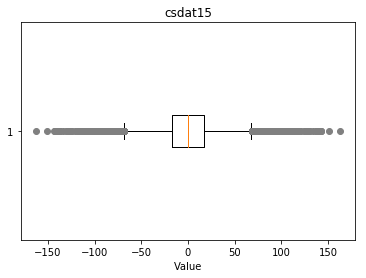

-------------------- 
Outlier detection:
 --------------------
List of outliers: {128.0, -128.0, 130.0, 129.0, -126.0, -124.0, -127.0, -121.0, -125.0, 137.0, -118.0, 139.0, 140.0, -117.0, -114.0, -119.0, -112.0, -111.0, -110.0, 143.0, -108.0, -107.0, -106.0, -105.0, -104.0, -103.0, 151.0, -109.0, -102.0, 131.0, -131.0, 134.0, 163.0, -151.0, -142.0, 138.0, -116.0, 113.0, -113.0, -138.0, 142.0, 119.0, -163.0, -134.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 127.0, 110.0, 111.0, 112.0, -143.0, 114.0, 109.0, -140.0, -139.0, 118.0, -137.0, 117.0, 121.0, 126.0, 116.0, 124.0, 125.0, -130.0, -129.0}


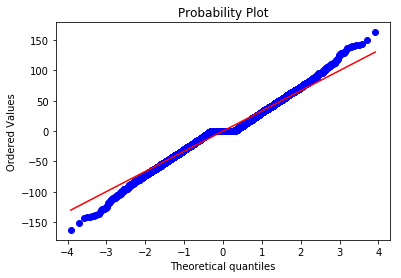

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.2804
Overview of variable:  datediff 


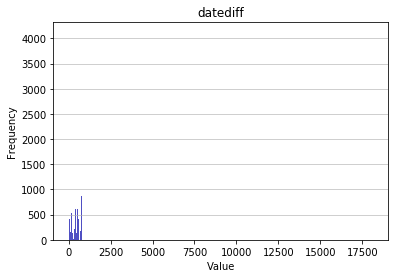

-------------------- 
Summary statistics:
 --------------------
Minimum value: 6.0
Mean: 542.3316
Standard deviation: 322.7057
Median: 546.0
Maximal value: 18132.0


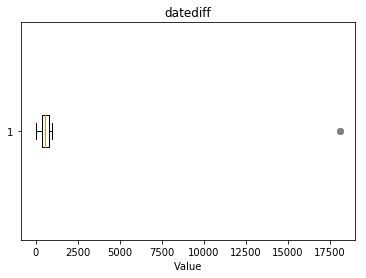

-------------------- 
Outlier detection:
 --------------------
List of outliers: {18132.0}


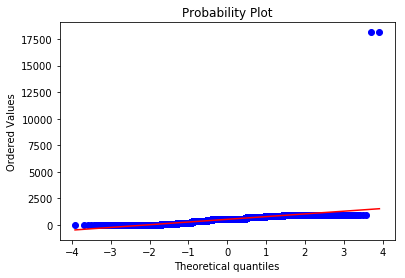

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 20.7027
Kurtosis: 1135.9647
Overview of variable:  Encoded_league 


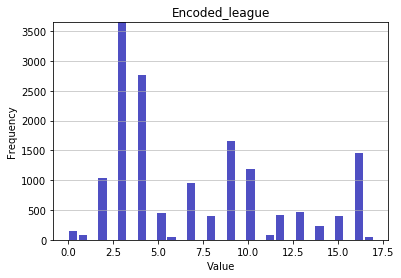

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 7.0245
Standard deviation: 4.5959
Median: 5.0
Maximal value: 17


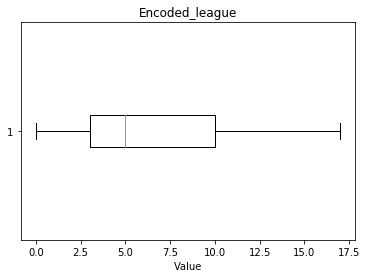

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


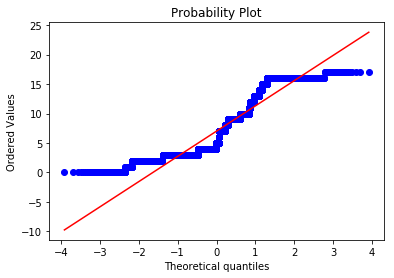

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7079
Kurtosis: -0.7738
Overview of variable:  Encoded_game 


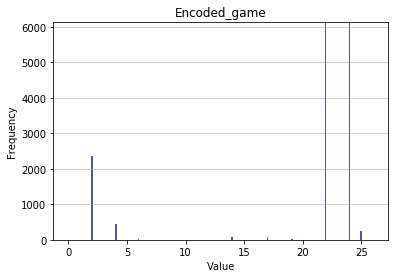

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 19.1484
Standard deviation: 8.0748
Median: 22.0
Maximal value: 26


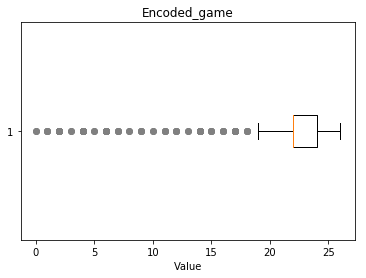

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


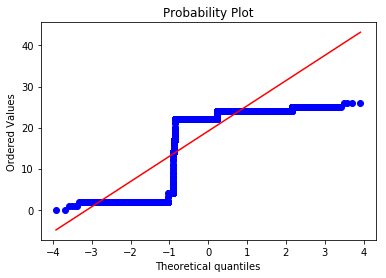

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -1.5591
Kurtosis: 0.5512
Overview of variable:  Encoded_side 


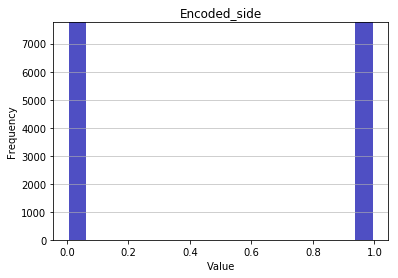

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 0.5
Standard deviation: 0.5
Median: 0.5
Maximal value: 1


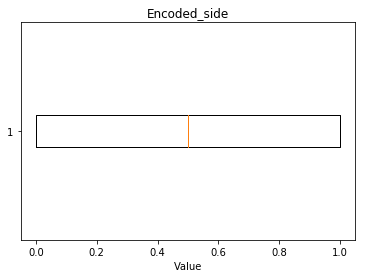

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


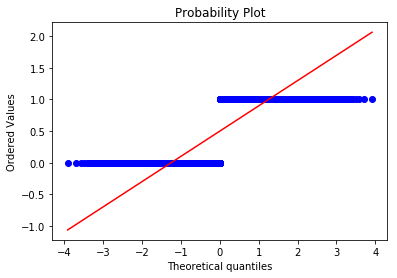

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -2.0
Overview of variable:  Encoded_ban1 


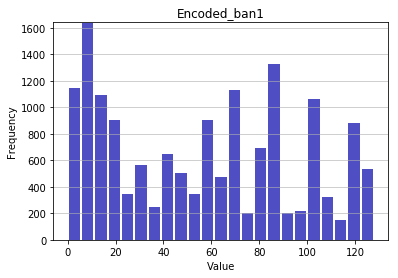

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 56.3418
Standard deviation: 38.6902
Median: 58.0
Maximal value: 128


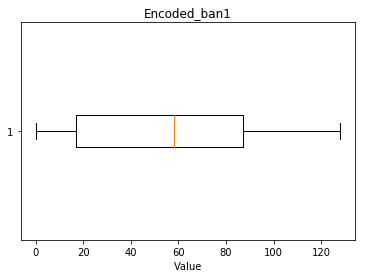

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


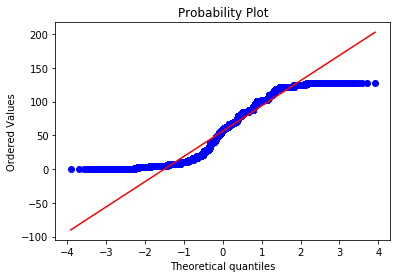

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1801
Kurtosis: -1.2391
Overview of variable:  Encoded_ban2 


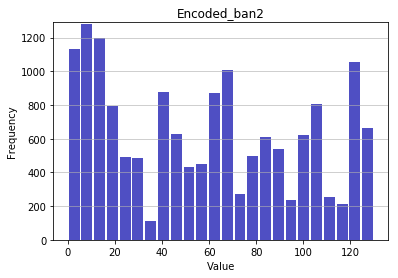

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 58.5228
Standard deviation: 40.1353
Median: 58.0
Maximal value: 130


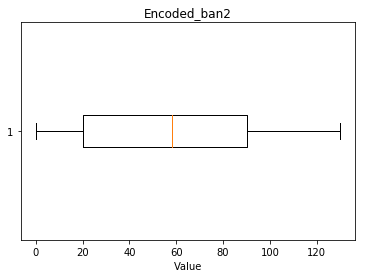

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


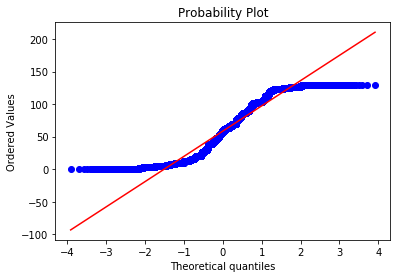

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2089
Kurtosis: -1.2396
Overview of variable:  Encoded_ban3 


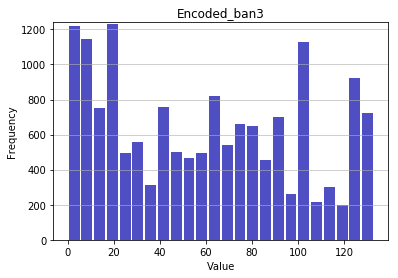

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 59.7586
Standard deviation: 40.7772
Median: 60.0
Maximal value: 133


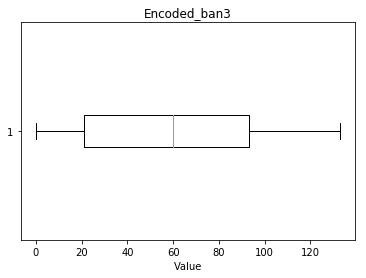

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


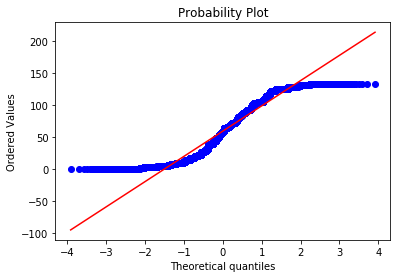

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1919
Kurtosis: -1.2459
Overview of variable:  Encoded_ban4 


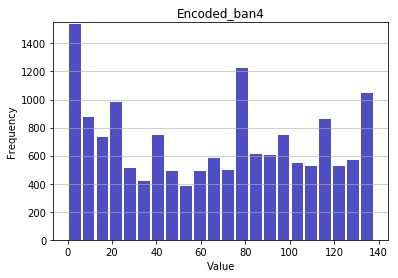

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 66.0631
Standard deviation: 43.1533
Median: 70.0
Maximal value: 138


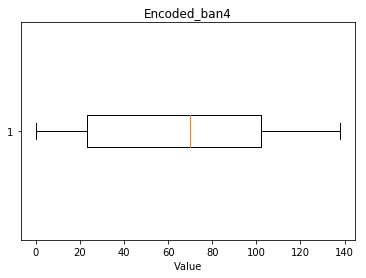

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


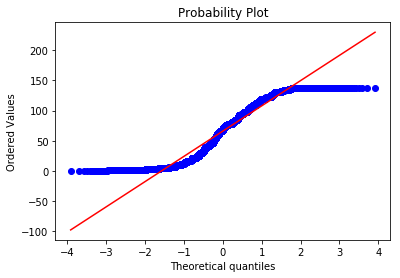

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0452
Kurtosis: -1.3025
Overview of variable:  Encoded_ban5 


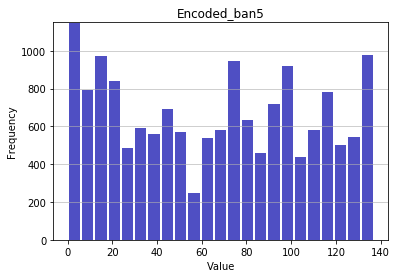

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 66.0745
Standard deviation: 42.3254
Median: 68.0
Maximal value: 137


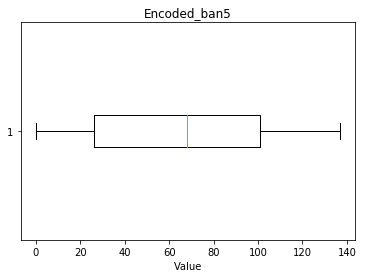

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


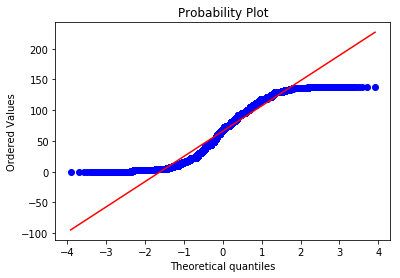

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0474
Kurtosis: -1.2918
Overview of variable:  Encoded_result 


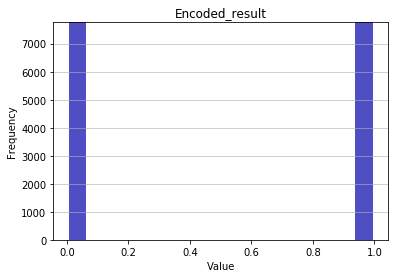

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 0.5
Standard deviation: 0.5
Median: 0.5
Maximal value: 1


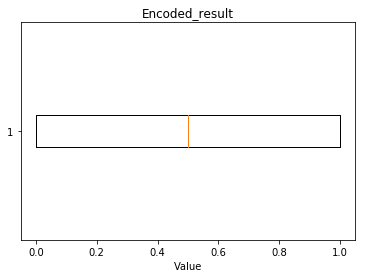

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


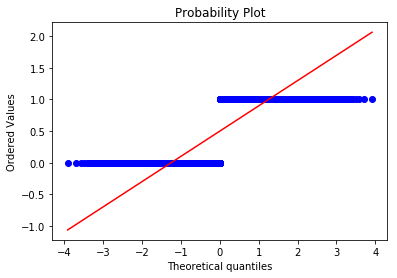

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -2.0
Overview of variable:  Encoded_fb 


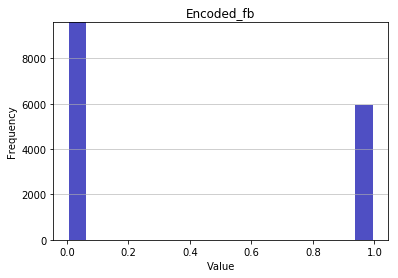

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 0.3822
Standard deviation: 0.4859
Median: 0.0
Maximal value: 1


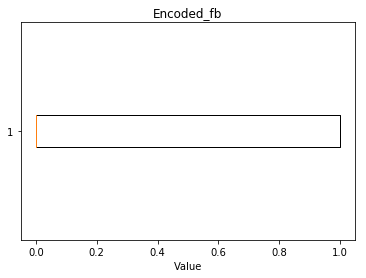

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


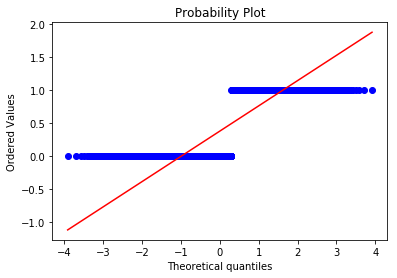

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.485
Kurtosis: -1.7648
Overview of variable:  Encoded_fbassist 


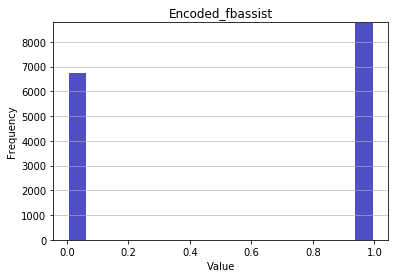

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.5662
Standard deviation: 0.4956
Median: 1.0
Maximal value: 1.0


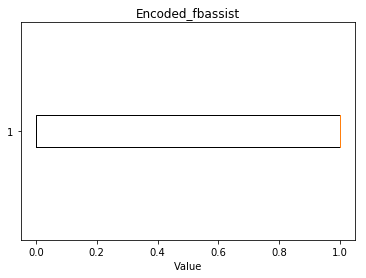

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


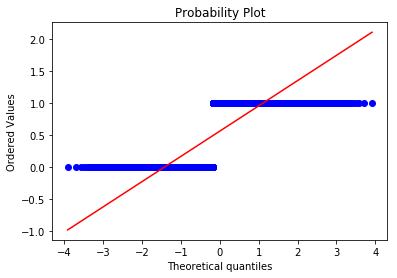

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.2671
Kurtosis: -1.9286
Overview of variable:  Encoded_fbvictim 


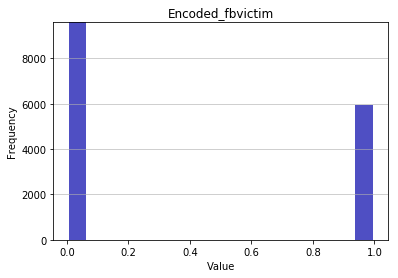

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 0.3822
Standard deviation: 0.4859
Median: 0.0
Maximal value: 1


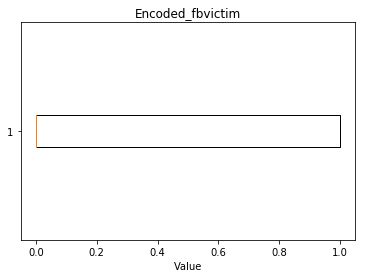

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


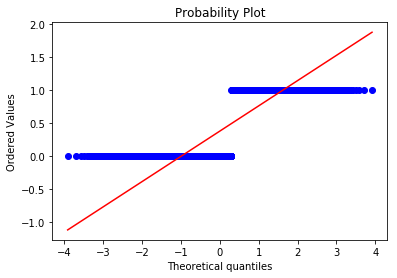

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.485
Kurtosis: -1.7648
Overview of variable:  Encoded_fd 


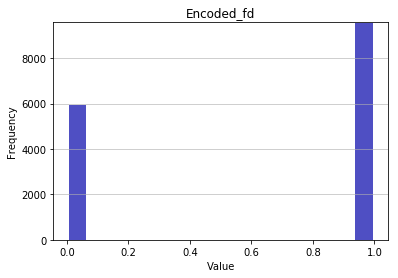

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 0.6169
Standard deviation: 0.4862
Median: 1.0
Maximal value: 1


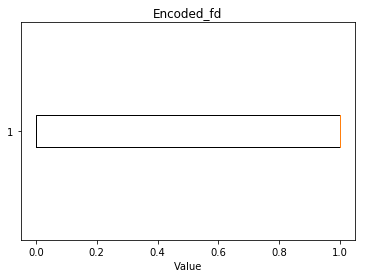

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


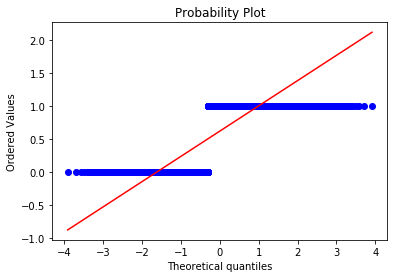

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.4808
Kurtosis: -1.7689
Overview of variable:  Encoded_herald 


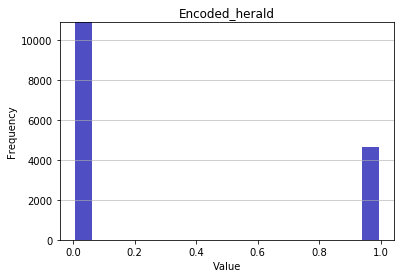

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.2983
Standard deviation: 0.4575
Median: 0.0
Maximal value: 1.0


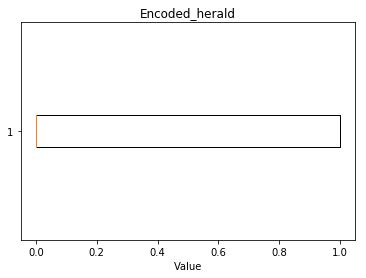

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


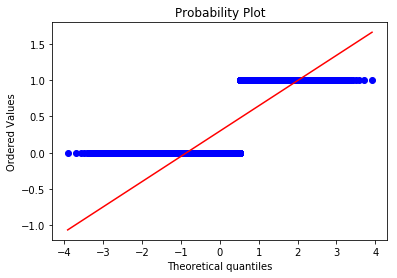

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8817
Kurtosis: -1.2227
Overview of variable:  Encoded_ft 


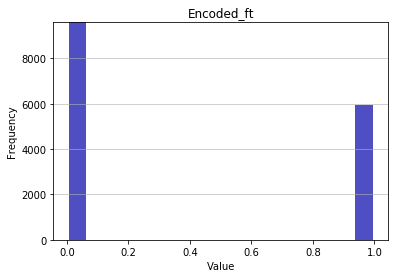

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3822
Standard deviation: 0.4859
Median: 0.0
Maximal value: 1.0


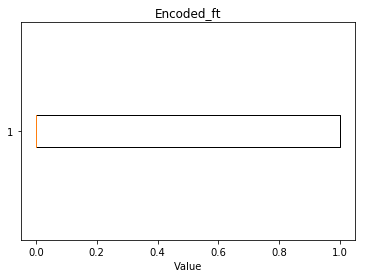

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


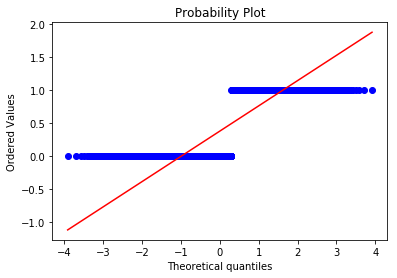

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.485
Kurtosis: -1.7648
Overview of variable:  Encoded_firstmidouter 


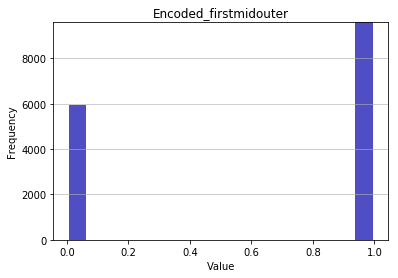

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.6178
Standard deviation: 0.4859
Median: 1.0
Maximal value: 1.0


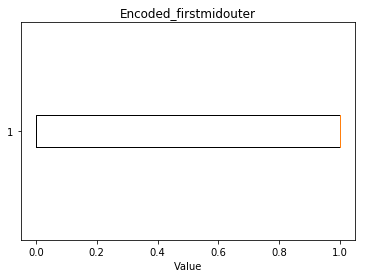

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


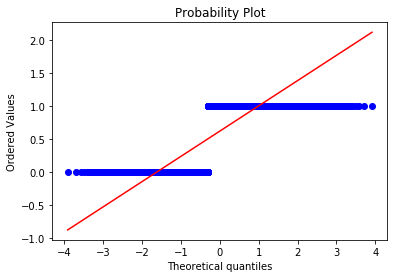

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.4847
Kurtosis: -1.7651
Overview of variable:  Encoded_firsttothreetowers 


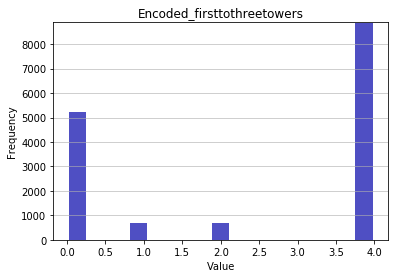

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 2.4263
Standard deviation: 1.8713
Median: 4.0
Maximal value: 4


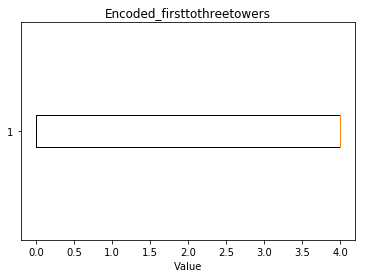

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


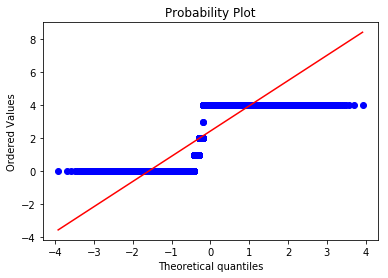

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.4144
Kurtosis: -1.746
Overview of variable:  Encoded_fbaron 


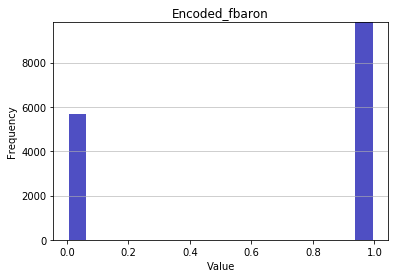

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.6328
Standard deviation: 0.482
Median: 1.0
Maximal value: 1.0


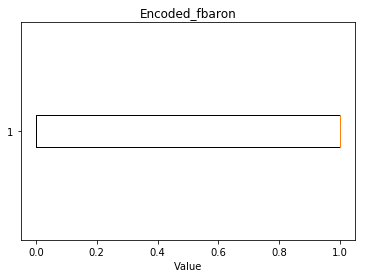

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


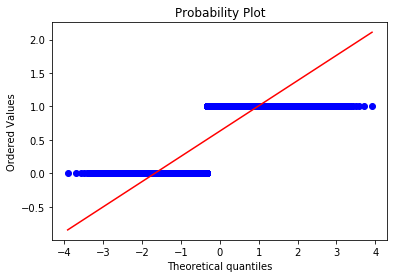

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.5512
Kurtosis: -1.6962
Overview of variable:  Encoded_Year 


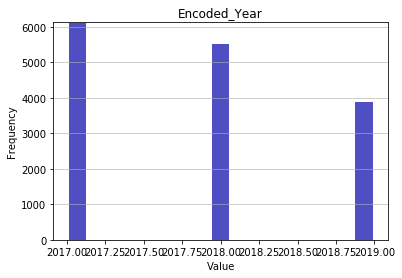

-------------------- 
Summary statistics:
 --------------------
Minimum value: 2017
Mean: 2017.8555
Standard deviation: 0.79
Median: 2018.0
Maximal value: 2019


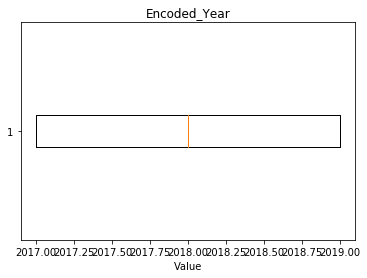

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


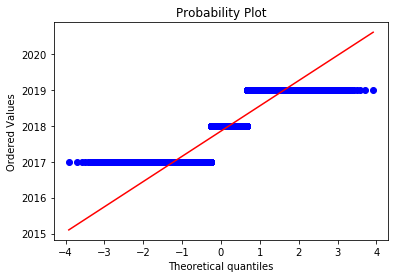

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2618
Kurtosis: -1.3544
Overview of variable:  Encoded_culture 


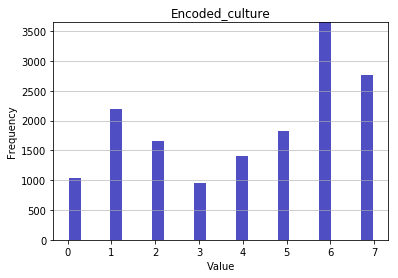

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 4.1538
Standard deviation: 2.3423
Median: 5.0
Maximal value: 7


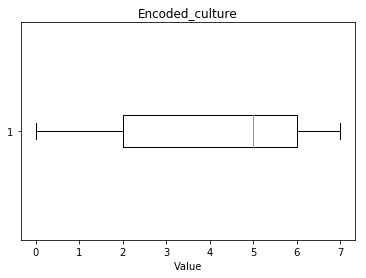

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


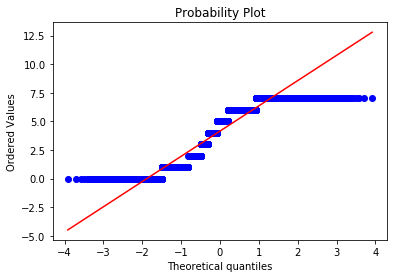

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.3703
Kurtosis: -1.3059


<Figure size 432x288 with 0 Axes>

In [19]:
# Loop through all numerical variables and visualize data
for num_variable in numerical_variables:
    SummaryNumericVar(preprocessed_data[num_variable].dropna(), num_variable)

##### Remove irrelevant features for further analysis
* Impossible column values are removed (gamelength of zero).
* Features with zero variance were removed (because of their redundancy in further analysis).
* Extreme outliers

In [20]:
# Remove redundant features
preprocessed_data = preprocessed_data.drop(['wardshare'], axis = 1)
preprocessed_data = preprocessed_data[preprocessed_data.gamelength > 0]
preprocessed_data = preprocessed_data[preprocessed_data.datediff != 17973.0]

In [21]:
# Remove dropped features from numerical feature list
numerical_variables.remove('wardshare')

##### Reduce the influence of outliers by applying a box-cox transformation on the data
Because ridge and lasso regression are both sensitive to outlying observations, it was decided to reduce the influence of the latter by applying a box-cox transformation on the numerical features, hence transforming them in a normal shape. We refrained from removing outliers because these could capture relevant information and transformation is assumed to reduce their influence. Different lambda values underlying the exponential transformation of the data are explored [-5, 5] and the optimal value, resulting in the best approximation of the normal curve, is selected.

Feature:  split
The optimal value for lambda:  0.05663910266878461
Feature:  gamelength
The optimal value for lambda:  -0.449231816010653
Feature:  fbtime
The optimal value for lambda:  0.1884748762272173
Feature:  ckpm
The optimal value for lambda:  0.290190896725153
Feature:  fdtime
The optimal value for lambda:  0.1717357286577763
Feature:  heraldtime
The optimal value for lambda:  -0.8441126957516737
Feature:  fttime
The optimal value for lambda:  0.9250042947713202
Feature:  fbarontime
The optimal value for lambda:  -1.3707229329474495
Feature:  dmgtochamps
The optimal value for lambda:  0.05531897651549346
Feature:  dmgtochampsperminute
The optimal value for lambda:  0.5607956272035342
Feature:  wards
The optimal value for lambda:  -0.06484971972253158
Feature:  wpm
The optimal value for lambda:  -0.5248505793361349
Feature:  wardkills
The optimal value for lambda:  0.2704595325343508
Feature:  wcpm
The optimal value for lambda:  0.32983591697066056
Feature:  visionwards
The opti

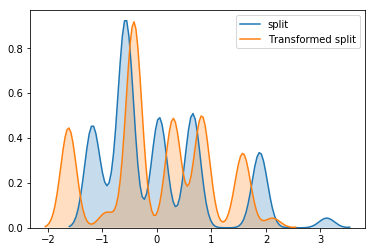

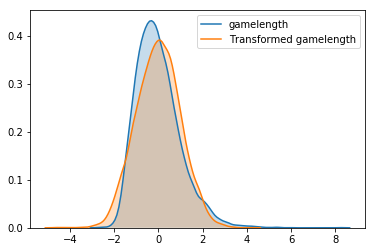

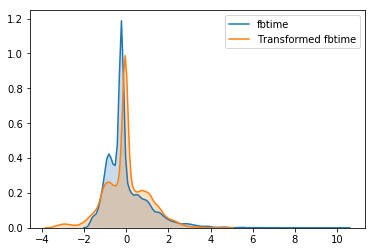

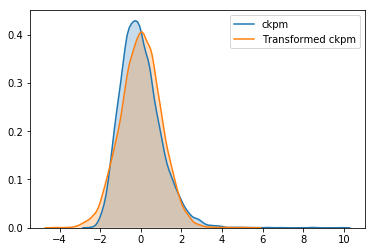

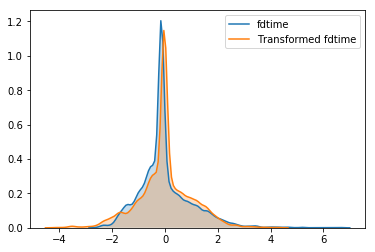

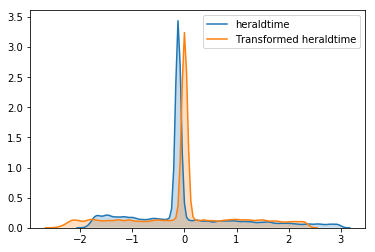

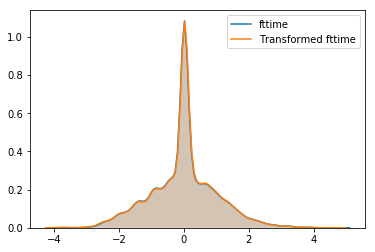

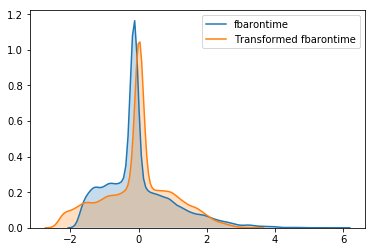

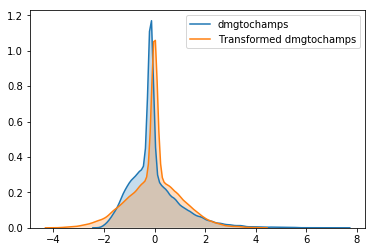

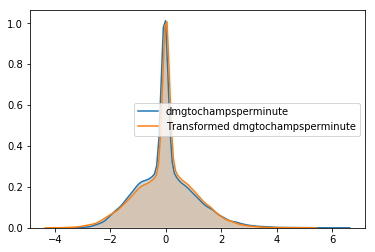

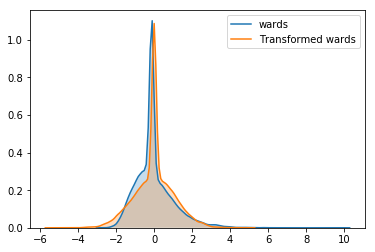

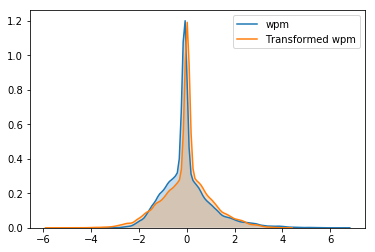

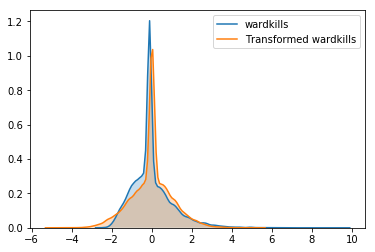

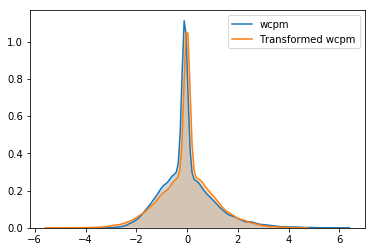

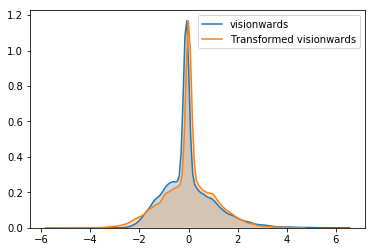

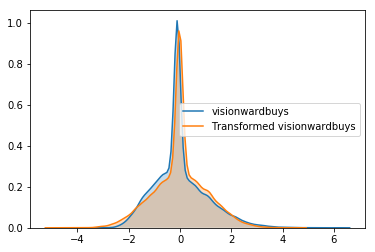

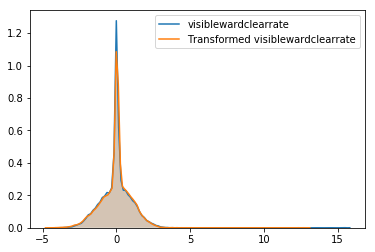

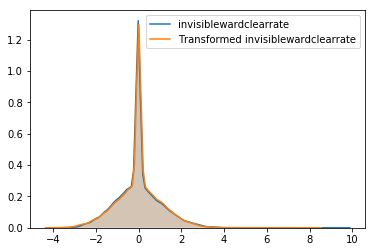

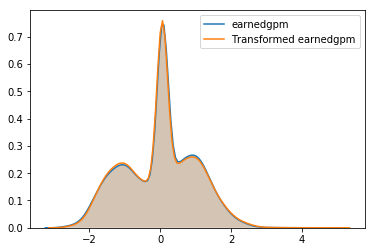

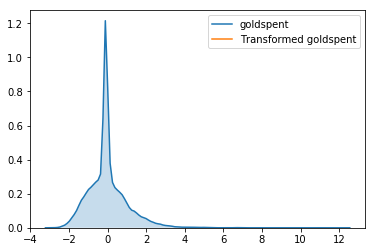

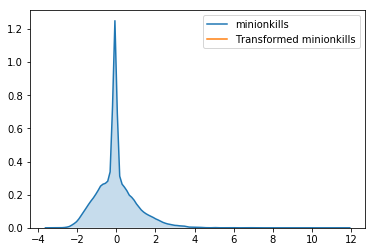

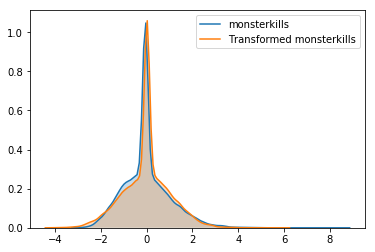

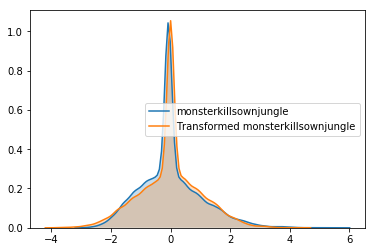

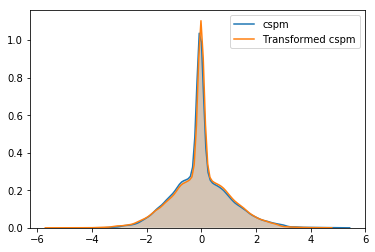

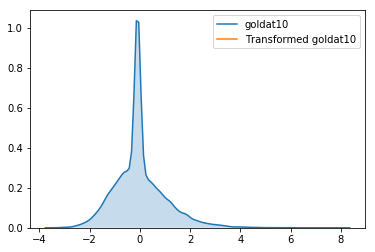

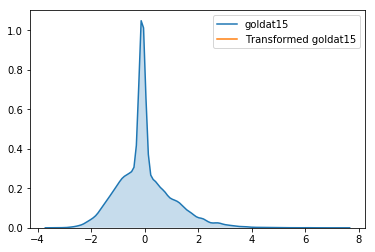

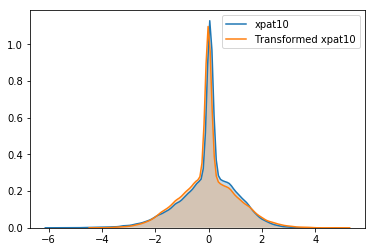

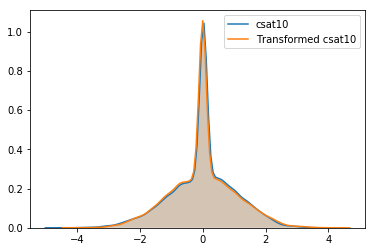

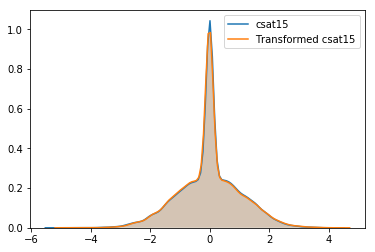

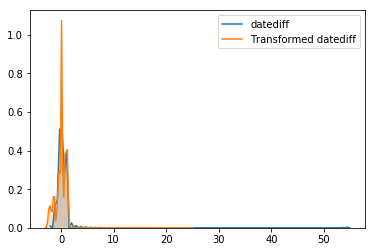

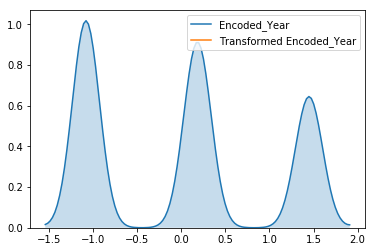

In [22]:
# Initialization
transformed_data_df, optimiser_dict = pd.DataFrame(), dict()

# Loop through the data and apply box cox transformation
for num_variable in numerical_variables:
    if all(preprocessed_data[num_variable] > 0):
        transformed_feature, optimiser = feature_transformer(preprocessed_data[num_variable], num_variable)
        if -5 <= optimiser <= 5:
            transformed_data_df[num_variable] = transformed_feature
            optimiser_dict[num_variable] = optimiser
        else:
            transformed_data_df[num_variable] = preprocessing.scale(preprocessed_data[num_variable])
            optimiser_dict[num_variable] = np.nan
    else:
        transformed_data_df[num_variable] = preprocessing.scale(preprocessed_data[num_variable])
    #transformed_data_df[num_variable], optimiser_dict[num_variable] = transformed_feature, optimiser if -5 <= optimiser <= 5 else preprocessing.scale(preprocessed_data[num_variable]), np.nan
    #if all(preprocessed_data[num_variable] > 0):
    #    transformed_data_df[num_variable], optimiser = feature_transformer(preprocessed_data[num_variable], num_variable)
    #    optimiser_dict[num_variable] = optimiser
    #else:
    #    transformed_data_df[num_variable] = preprocessing.scale(preprocessed_data[num_variable])
        
# Add team feature
transformed_data_df['team'] = list(preprocessed_data['team'])

Overview of variable:  split 


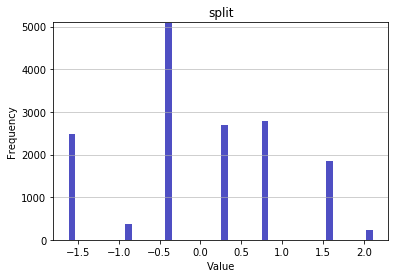

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.6205342332074981
Mean: 0.0
Standard deviation: 1.0
Median: -0.4226
Maximal value: 2.1190342980341774


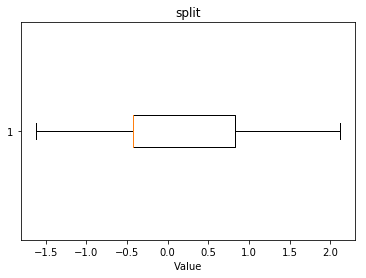

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


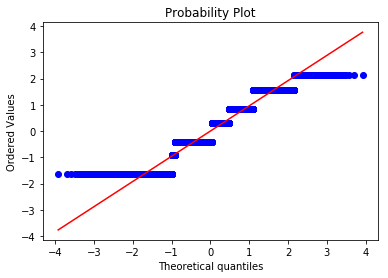

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0079
Kurtosis: -0.7451
Overview of variable:  patchno 


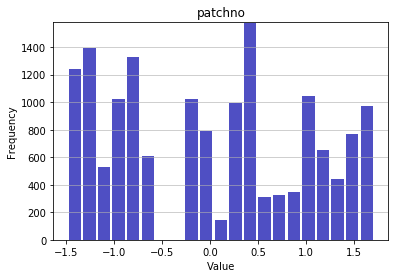

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.4837754057725085
Mean: 0.0
Standard deviation: 1.0
Median: -0.0265
Maximal value: 1.7109918228771959


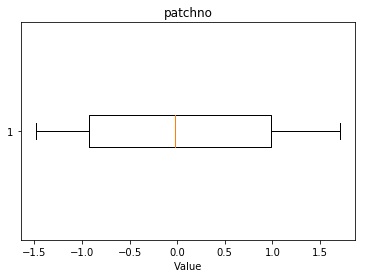

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


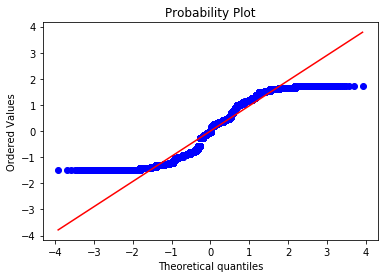

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.108
Kurtosis: -1.302
Overview of variable:  gamelength 


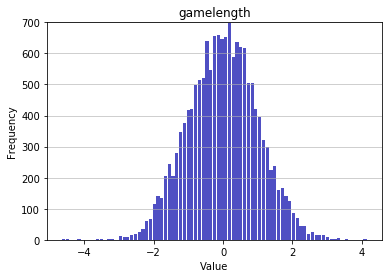

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.643892846097638
Mean: 0.0
Standard deviation: 1.0
Median: 0.0099
Maximal value: 4.146033642427847


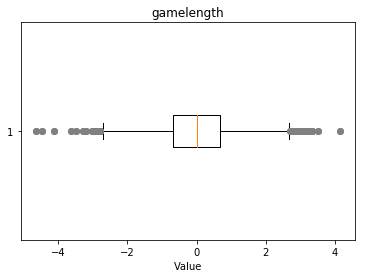

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.13, 3.02, 3.5, 4.15, 3.2, 3.32, 3.3, 3.06, 3.01, -4.64, -4.47, -3.02, -3.2, -3.48, -3.64, -3.29, -4.11, -3.01}


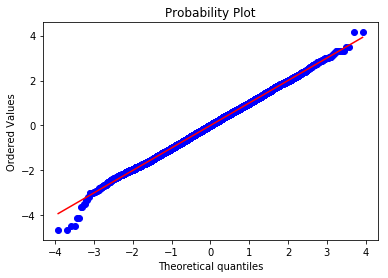

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0002
Kurtosis: 0.0121
Overview of variable:  k 


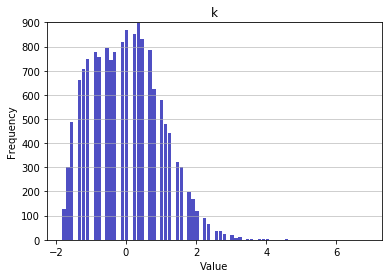

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.8233472021332353
Mean: 0.0
Standard deviation: 1.0
Median: 0.0394
Maximal value: 6.869367847285681


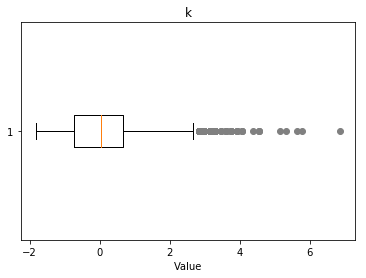

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.3, 3.14, 3.45, 3.76, 4.08, 3.92, 4.54, 3.61, 4.39, 5.16, 5.63, 5.32, 6.87, 5.78}


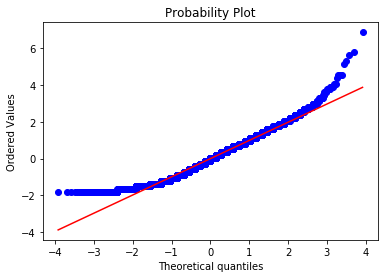

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4421
Kurtosis: 0.1305
Overview of variable:  d 


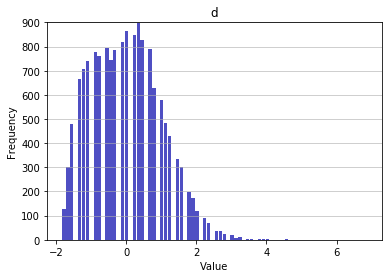

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.8250522200782968
Mean: 0.0
Standard deviation: 1.0
Median: 0.0364
Maximal value: 6.861529614239569


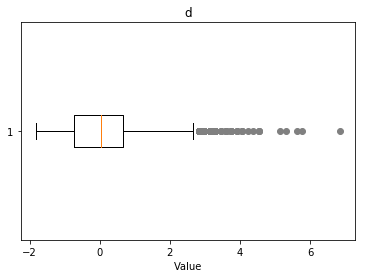

-------------------- 
Outlier detection:
 --------------------
List of outliers: {5.78, 3.29, 3.14, 3.45, 3.76, 4.22, 3.91, 4.53, 4.07, 3.6, 4.38, 5.16, 5.31, 6.86, 5.62}


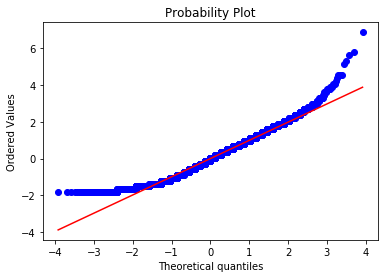

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.443
Kurtosis: 0.1335
Overview of variable:  a 


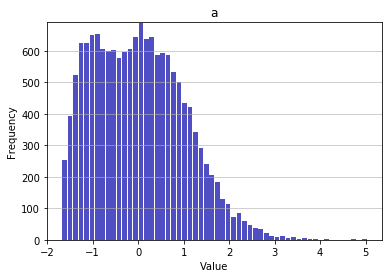

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.6786276108956228
Mean: -0.0
Standard deviation: 1.0
Median: -0.0458
Maximal value: 5.034057359826451


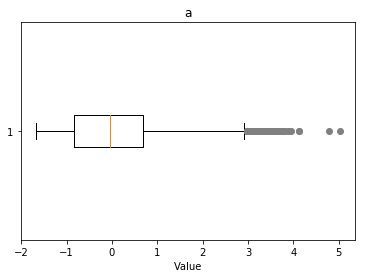

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.22, 3.89, 3.64, 3.82, 3.16, 3.7, 3.1, 3.46, 3.04, 3.28, 4.79, 5.03, 3.76, 3.52, 3.4, 3.58, 3.34, 4.13, 3.95}


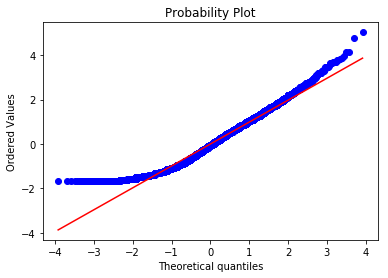

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4521
Kurtosis: -0.2176
Overview of variable:  teamkills 


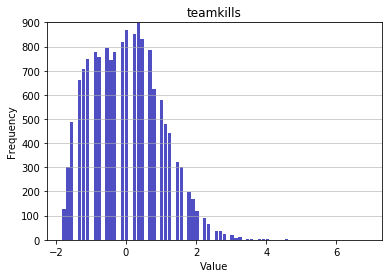

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.8233472021332353
Mean: 0.0
Standard deviation: 1.0
Median: 0.0394
Maximal value: 6.869367847285681


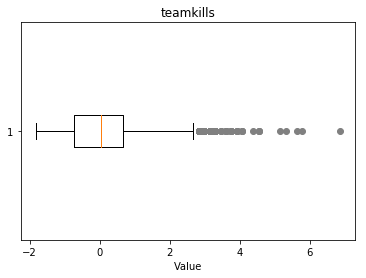

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.3, 3.14, 3.45, 3.76, 4.08, 3.92, 4.54, 3.61, 4.39, 5.16, 5.63, 5.32, 6.87, 5.78}


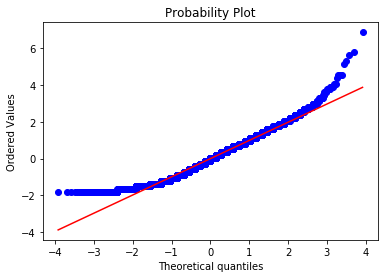

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4421
Kurtosis: 0.1305
Overview of variable:  fbtime 


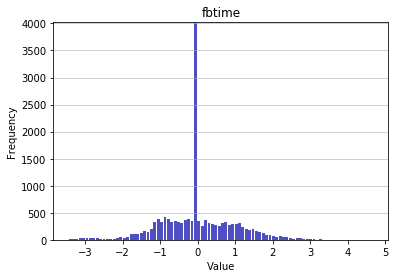

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.4441352256567423
Mean: 0.0
Standard deviation: 1.0
Median: -0.0435
Maximal value: 4.6838543755700055


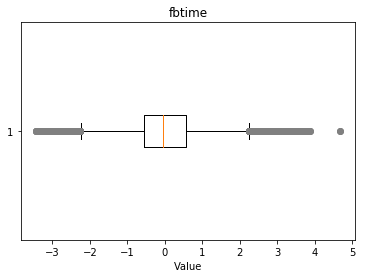

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.71, 3.89, 3.06, 3.61, 3.01, 3.8, 3.02, 3.47, 3.56, 3.32, 4.68, 3.0, -3.31, -3.07, -3.06, -3.4, -3.22, -3.14, -3.32, 3.34, 3.28, 3.27, -3.13, -3.05, -3.2, -3.29, -3.12, -3.21, 3.43, -3.38, 3.78, -3.37, 3.35, 3.05, -3.27, -3.44, -3.11, -3.36, -3.02, 3.3, 3.21, -3.35, -3.03, 3.15, -3.33, -3.16, -3.08, -3.26, -3.42, 3.64, -3.09, 3.31, -3.17, -3.24, -3.01}


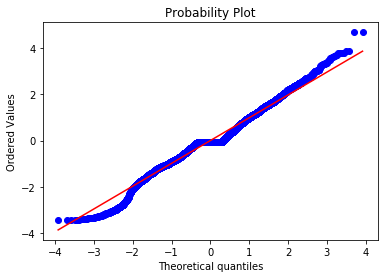

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0341
Kurtosis: 1.0245
Overview of variable:  kpm 


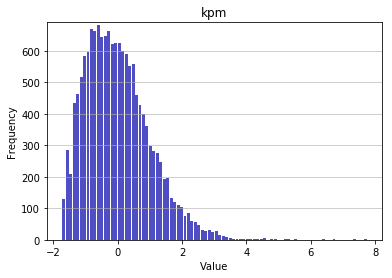

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.7276933667577992
Mean: 0.0
Standard deviation: 1.0
Median: -0.1212
Maximal value: 7.748074170597808


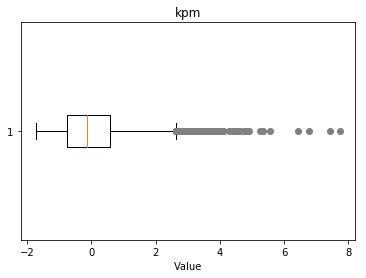

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.27, 3.91, 4.55, 3.01, 3.48, 3.05, 3.37, 3.04, 3.12, 3.09, 4.62, 5.24, 6.43, 3.74, 3.17, 3.0, 3.84, 3.42, 4.52, 4.77, 4.82, 4.48, 4.59, 5.57, 4.09, 4.08, 4.0, 4.1, 6.77, 3.63, 3.41, 3.59, 7.75, 7.42, 3.77, 3.18, 3.11, 3.28, 3.03, 3.52, 3.02, 3.1, 3.35, 3.14, 4.92, 3.3, 3.45, 3.13, 3.2, 3.29, 4.79, 4.44, 4.39, 4.11, 4.45, 3.5, 4.3, 4.78, 5.36, 3.54, 3.26, 3.76, 3.56, 3.06, 3.97, 3.07, 3.89, 3.15, 3.08, 3.98, 3.39, 3.22, 4.57, 3.36, 3.72}


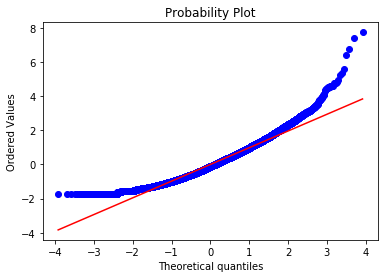

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8469
Kurtosis: 1.3478
Overview of variable:  ckpm 


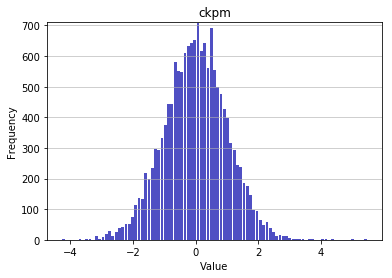

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.261393450334197
Mean: 0.0
Standard deviation: 1.0
Median: 0.0161
Maximal value: 5.458158138352835


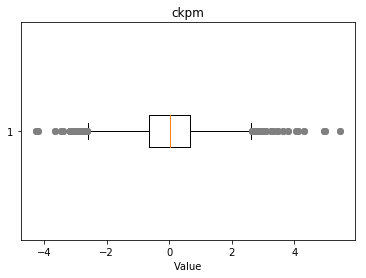

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.27, 3.25, 4.05, 3.01, 3.63, 3.46, 5.46, 4.32, 4.1, 4.98, 4.95, 3.33, -3.65, -3.4, 3.1, -3.12, -3.04, -3.45, 3.78, -4.26, 3.47, -3.17, -3.16, -4.18, -3.11}


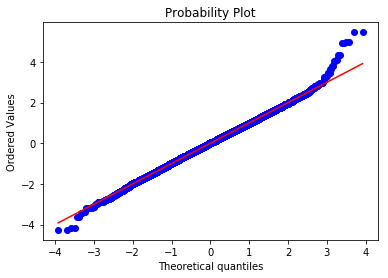

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.013
Kurtosis: 0.4093
Overview of variable:  fdtime 


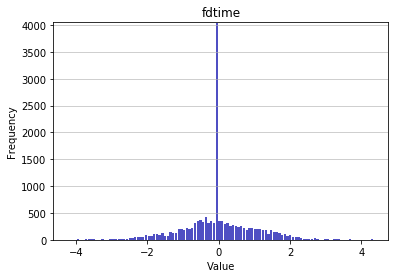

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.2033016571640145
Mean: -0.0
Standard deviation: 1.0
Median: -0.0269
Maximal value: 4.332030025115032


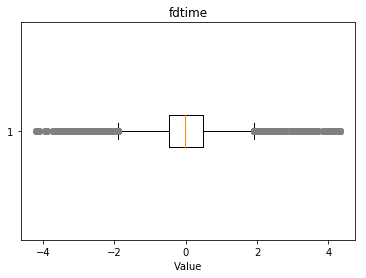

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.66, 3.07, 3.08, 3.2, 4.21, 3.68, 3.29, 3.1, 3.34, 3.59, 4.05, -3.3, 3.51, 3.09, -3.9, -3.65, -3.56, 4.16, 4.07, 4.32, -3.48, -3.44, -3.72, 3.38, 4.33, 3.41, -3.15, -3.4, -3.68, -3.93, -4.11, 3.86, -3.45, -3.04, 3.03, 3.19, -3.71, -3.63, -3.13, -3.54, -3.37, -3.12, 3.71, 3.45, 3.37, 3.3, 3.21, 4.29, -3.02, 3.88, -3.52, 3.96, -3.61, -4.16, 3.39, 3.22, -3.91, -3.0, -3.25, -3.33, -3.24, -3.49, -4.2, -3.55}


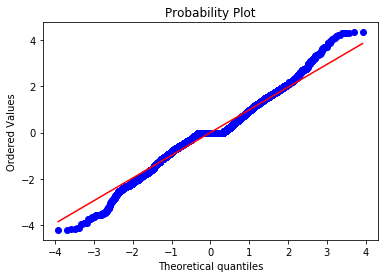

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0235
Kurtosis: 1.4484
Overview of variable:  teamdragkills 


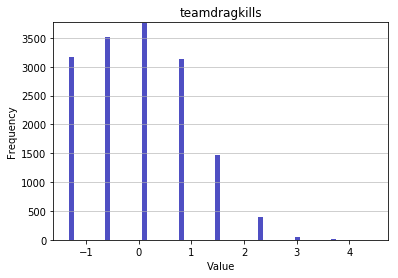

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.3420005046077406
Mean: 0.0
Standard deviation: 1.0
Median: 0.1085
Maximal value: 4.460112106501688


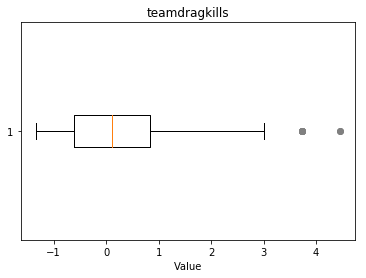

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.73, 3.01, 4.46}


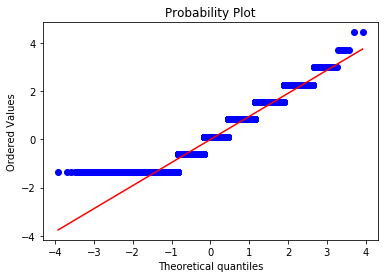

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.36
Kurtosis: -0.5456
Overview of variable:  elementals 


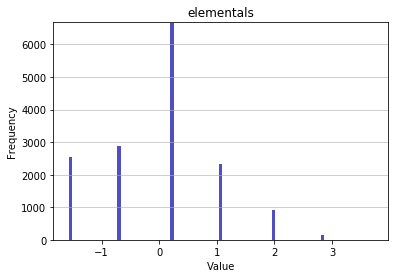

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.5782711039951216
Mean: -0.0
Standard deviation: 1.0
Median: 0.1868
Maximal value: 3.7170145909497747


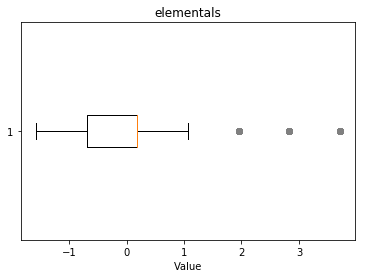

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.72}


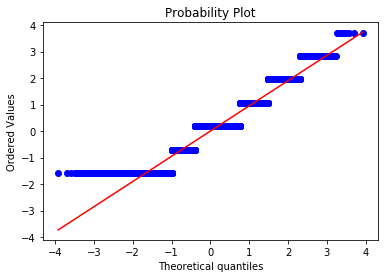

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1783
Kurtosis: -0.1264
Overview of variable:  firedrakes 


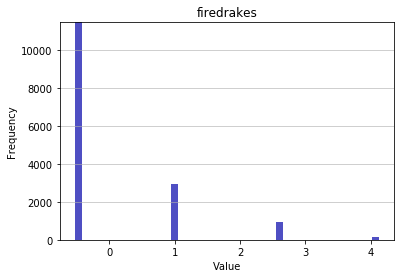

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.534741554027911
Mean: 0.0
Standard deviation: 1.0
Median: -0.5347
Maximal value: 4.135160654185795


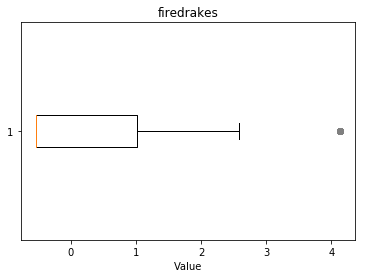

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4.14}


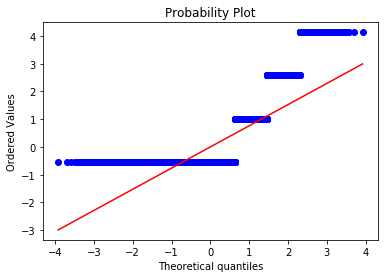

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.8975
Kurtosis: 3.1034
Overview of variable:  waterdrakes 


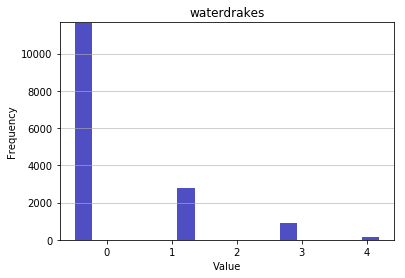

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.5162981880565256
Mean: 0.0
Standard deviation: 1.0
Median: -0.5163
Maximal value: 4.217402053001058


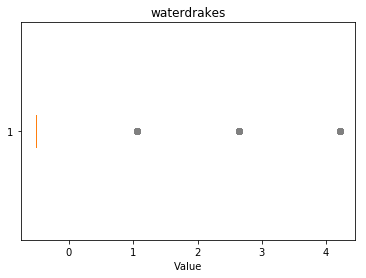

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4.22}


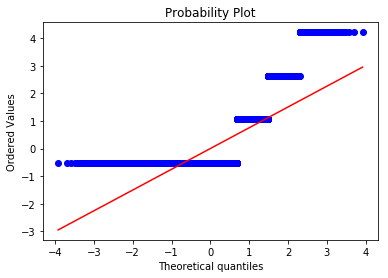

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.992
Kurtosis: 3.5237
Overview of variable:  earthdrakes 


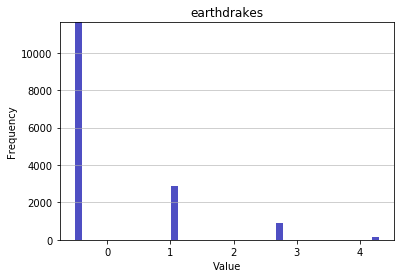

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.5236148891264768
Mean: 0.0
Standard deviation: 1.0
Median: -0.5236
Maximal value: 4.31628489685339


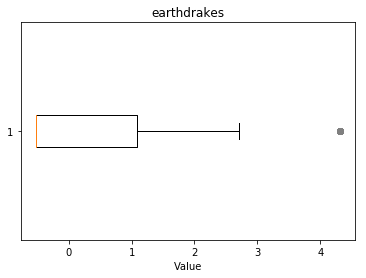

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4.32}


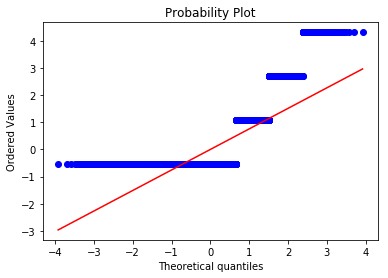

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.9462
Kurtosis: 3.3495
Overview of variable:  airdrakes 


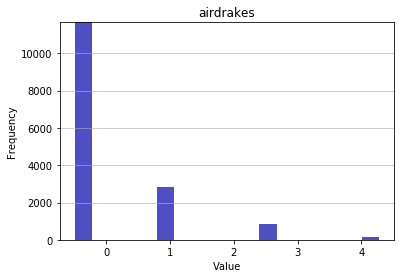

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.5187815135875238
Mean: -0.0
Standard deviation: 1.0
Median: -0.5188
Maximal value: 4.304237826804822


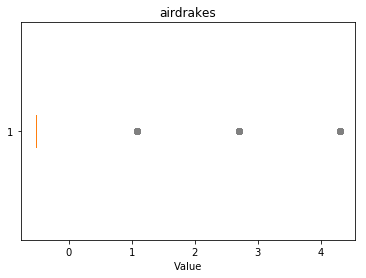

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4.3}


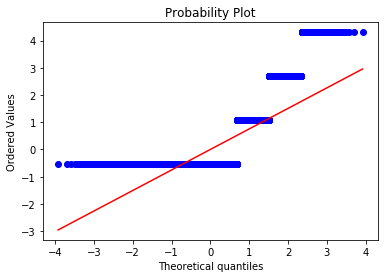

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.9798
Kurtosis: 3.5123
Overview of variable:  elders 


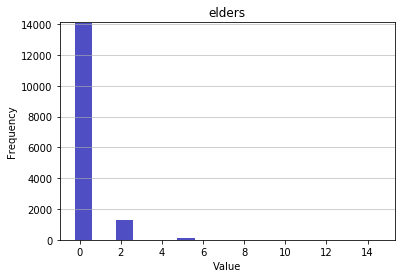

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.29771583136764795
Mean: 0.0
Standard deviation: 1.0
Median: -0.2977
Maximal value: 14.64010374637997


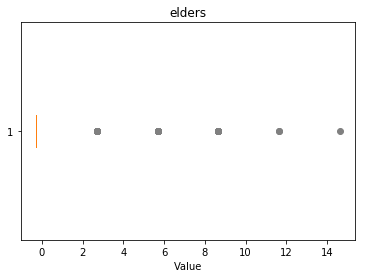

-------------------- 
Outlier detection:
 --------------------
List of outliers: {8.66, 11.65, 5.68, 14.64}


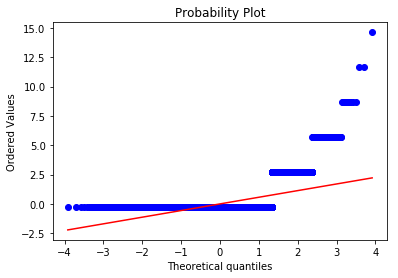

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 3.812
Kurtosis: 18.3474
Overview of variable:  heraldtime 


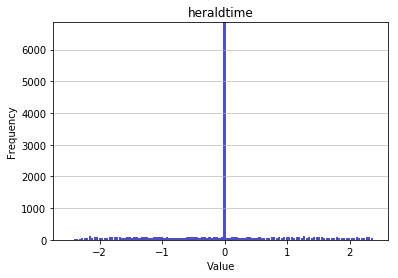

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.500095442409825
Mean: 0.0
Standard deviation: 1.0
Median: 0.0027
Maximal value: 2.37507306296054


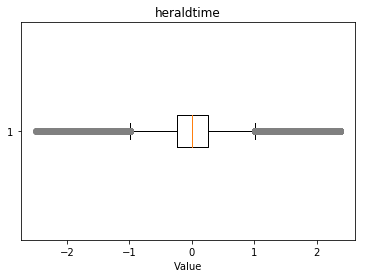

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


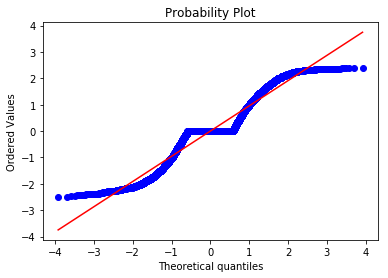

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0089
Kurtosis: 0.2465
Overview of variable:  fttime 


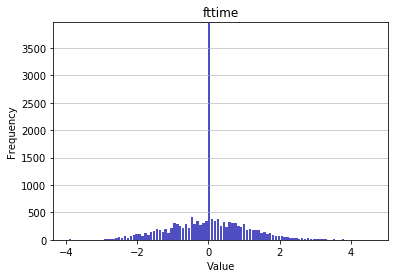

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.9306091601952224
Mean: -0.0
Standard deviation: 1.0
Median: 0.0177
Maximal value: 4.633556307118633


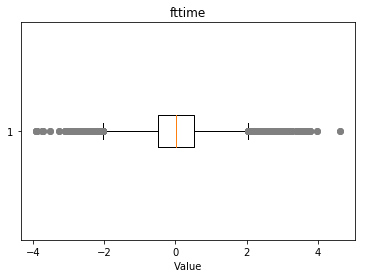

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.22, 3.08, 3.09, 3.41, 3.18, 3.21, 3.62, 3.26, 3.27, 3.51, 4.63, 3.76, -3.73, 3.16, 3.17, 3.03, -3.12, 3.69, 3.19, 3.78, 3.54, -3.11, -3.93, 3.79, 3.55, 3.13, 3.38, -3.27, 3.04, 3.71, 3.07, -3.08, -3.92, -3.76, 3.98, -3.91, -3.53}


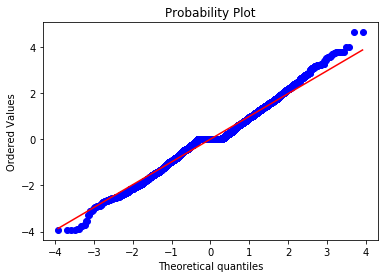

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0497
Kurtosis: 0.8503
Overview of variable:  teamtowerkills 


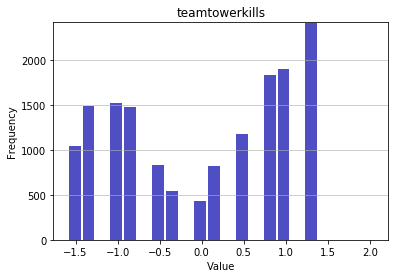

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.5937772952331564
Mean: -0.0
Standard deviation: 1.0
Median: 0.2271
Maximal value: 2.0480684210962257


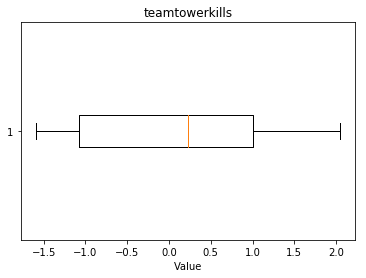

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


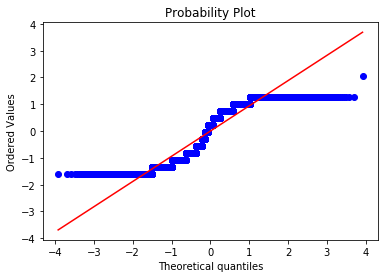

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.1799
Kurtosis: -1.5129
Overview of variable:  fbarontime 


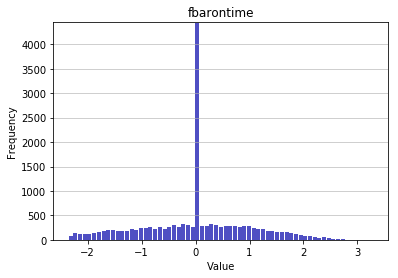

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.359427918998068
Mean: -0.0
Standard deviation: 1.0
Median: 0.0178
Maximal value: 3.2954835579282546


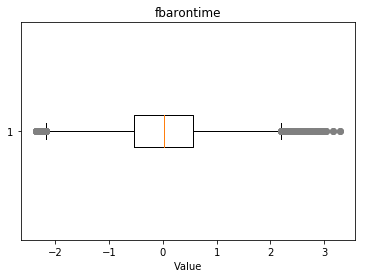

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.3, 3.04, 3.16}


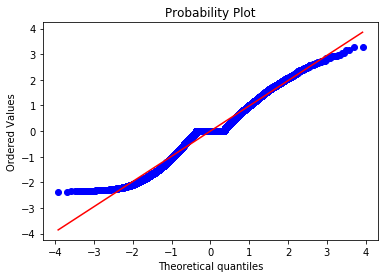

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0036
Kurtosis: 0.0513
Overview of variable:  teambaronkills 


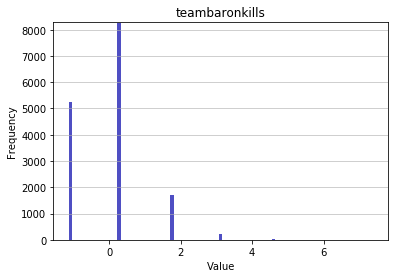

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.1490365398531182
Mean: -0.0
Standard deviation: 1.0
Median: 0.2739
Maximal value: 7.388341661688132


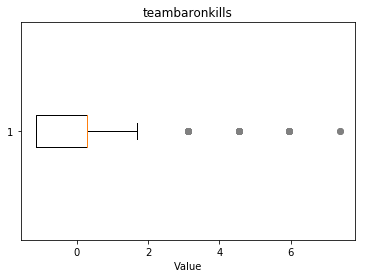

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.12, 4.54, 5.97, 7.39}


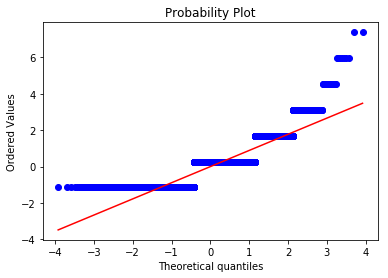

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.757
Kurtosis: 1.4315
Overview of variable:  dmgtochamps 


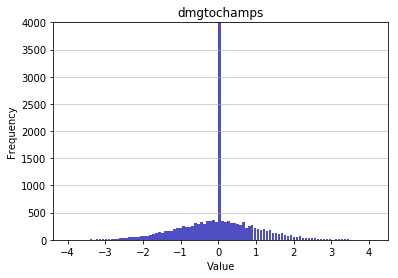

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.9789250610754916
Mean: 0.0
Standard deviation: 1.0
Median: 0.0012
Maximal value: 4.115924461659284


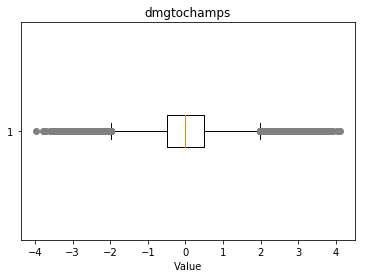

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.12, 3.25, 3.29, 3.37, 3.09, 3.42, 3.11, 3.39, 3.35, 3.71, 4.12, 3.5, -3.14, -3.07, 3.75, -3.57, 3.18, 3.86, 3.43, -3.21, 3.68, 3.93, 3.79, -3.35, -3.53, -3.78, -3.28, 4.04, -3.03, 3.4, -3.24, -3.17, 3.72, 3.47, 3.08, 3.83, 3.51, -3.31, -3.06, 3.44, -3.2, 3.19, -3.38, -3.7, 3.8, 3.62, 3.3, -3.02, 3.23, -3.59, -3.16, -3.41, -3.09, 3.34, -3.98, -3.48, -3.3, -3.12, 3.13, 3.45, -3.44, -3.19, 3.56, -3.58, -3.08, -3.51, -3.01, -3.26, 3.06, 3.17, 3.24, 3.67, -3.15, 3.49, 3.28, -3.54, -3.29, 3.1, 3.46, -3.11, -3.43, -3.36, -3.18, 3.14, -3.25, 3.32, 3.07, -3.5, -3.72}


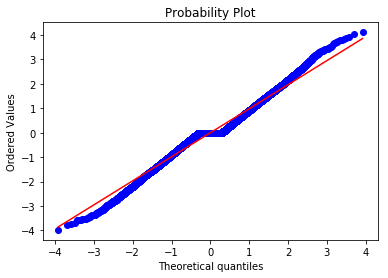

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0068
Kurtosis: 1.077
Overview of variable:  dmgtochampsperminute 


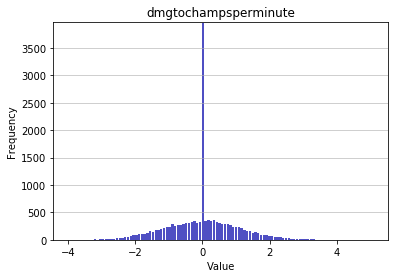

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.9905490588280967
Mean: -0.0
Standard deviation: 1.0
Median: 0.0123
Maximal value: 5.085411302602415


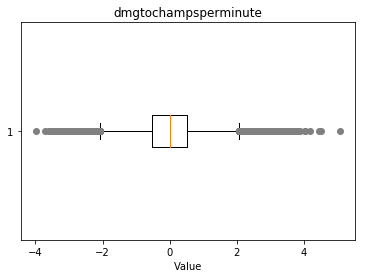

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.17, 3.55, 3.2, 3.05, 3.54, 3.27, 3.08, 4.2, 3.4, 3.62, 4.04, 3.84, 3.12, 3.34, -3.15, 3.33, 3.67, 3.16, 3.24, 3.09, 3.83, 3.26, -3.31, -3.23, -3.22, 4.51, 3.38, -3.3, 5.09, -3.01, 3.69, 3.18, -3.05, 3.1, 3.02, 3.77, 3.28, 3.53, 3.44, 3.19, -3.45, -3.58, -3.07, -3.35, -3.24, -3.49, -3.99, 3.63, 3.88, 3.21, 3.37, -3.6, 4.05, -3.44, -3.02, 3.13, -3.61, 4.45, 3.36, 3.11, -3.13, -3.52, 3.32, 3.14, -3.59, -3.41, -3.34, 3.15, 3.31, -3.16, 3.07, 3.57, -3.33, -3.19, -3.17, -3.73}


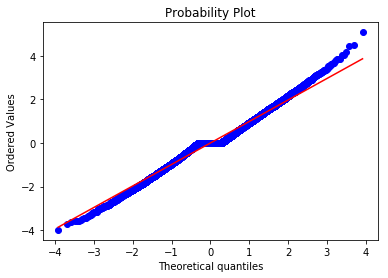

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0378
Kurtosis: 0.8939
Overview of variable:  wards 


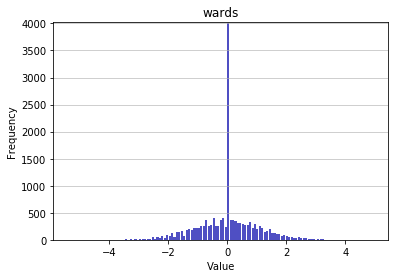

-------------------- 
Summary statistics:
 --------------------
Minimum value: -5.384054581207934
Mean: -0.0
Standard deviation: 1.0
Median: -0.0041
Maximal value: 4.948769668600151


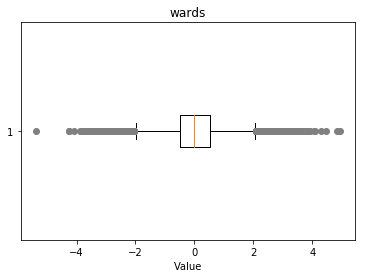

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.6, 3.74, 3.5, 3.07, 3.15, 3.06, 3.12, 3.35, 3.8, 3.4, 4.45, 3.26, -3.4, 3.42, 3.92, -3.64, 4.85, 4.08, -3.32, -3.48, -3.56, -3.9, 3.27, 3.1, 3.85, 3.28, 3.11, 3.43, 3.36, 3.2, -3.18, -3.03, 3.29, 3.04, 4.95, 3.38, 4.28, -3.1, 4.04, -3.81, -4.08, 3.23, 3.31, -3.25, 3.64, 3.89, 3.65, 3.14, -5.38, -4.27, -3.72}


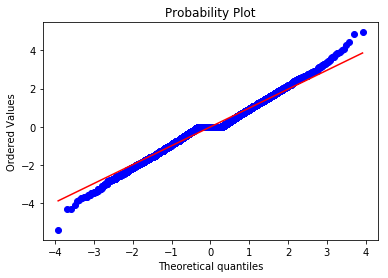

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0058
Kurtosis: 1.0106
Overview of variable:  wpm 


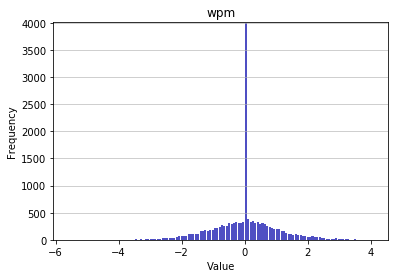

-------------------- 
Summary statistics:
 --------------------
Minimum value: -5.591107487733089
Mean: -0.0
Standard deviation: 1.0
Median: 0.013
Maximal value: 4.082891451385907


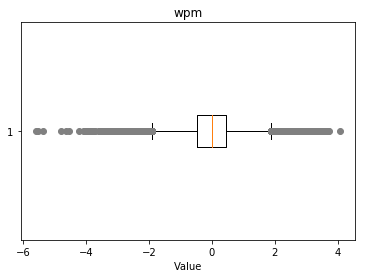

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.62, 3.07, 3.6, 3.65, 3.22, 3.12, 3.11, 3.08, 3.1, 3.46, 4.08, 3.25, -3.32, -3.89, 3.0, 3.5, -4.64, 3.18, -3.71, -3.46, 3.04, 3.29, -3.28, -3.85, -3.53, -3.1, 3.4, -3.42, -3.17, -3.99, -3.74, -3.24, 3.51, -3.06, 3.01, 3.58, -3.56, -4.06, 3.19, 3.44, -3.13, -3.45, 3.3, 3.05, -3.52, -3.02, -4.23, 3.23, -3.59, -3.09, -3.16, -3.84, 3.09, 3.16, 3.34, -3.23, -4.55, 3.02, -3.05, -3.55, 3.27, -3.87, 3.7, -3.19, -3.44, 3.13, 3.2, 3.38, -5.51, -3.01, -3.58, -3.76, -3.08, 3.74, -3.22, 3.49, -3.97, -5.36, -4.04, -4.79, 3.03, -3.29, 3.28, 3.53, 3.35, 3.21, -3.43, -3.11, -3.86, -3.36, 3.57, -3.5, 3.14, 3.64, -5.59, -4.05, -3.3}


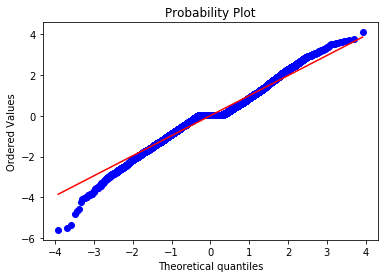

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0354
Kurtosis: 1.4385
Overview of variable:  wardkills 


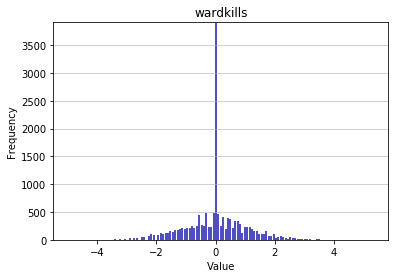

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.969826466870685
Mean: -0.0
Standard deviation: 1.0
Median: 0.0131
Maximal value: 5.32376959084332


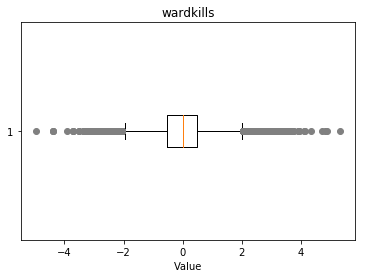

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.15, 4.11, 3.23, 3.44, 3.04, 3.12, 3.57, 3.26, 3.34, 4.88, 4.82, 5.32, 3.59, 3.76, 3.49, 3.66, 3.41, 4.33, -4.97, 3.93, -3.71, 3.02, 3.52, 3.1, 3.69, 3.18, 3.95, -3.19, -3.52, 3.21, -3.35, 3.71, 4.13, 4.72, 3.47, -3.91, 3.39, 3.64, 3.9, 3.07, -4.37, -3.04}


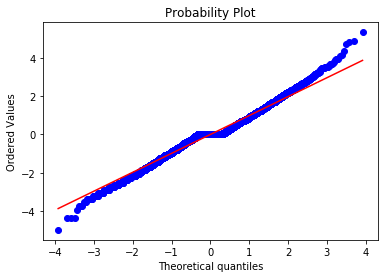

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0374
Kurtosis: 1.1512
Overview of variable:  wcpm 


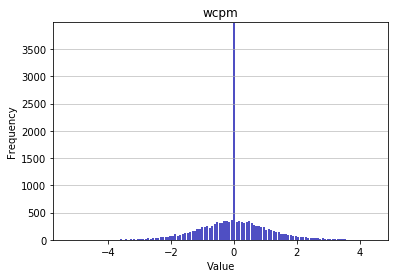

-------------------- 
Summary statistics:
 --------------------
Minimum value: -5.249220449392408
Mean: 0.0
Standard deviation: 1.0
Median: -0.0048
Maximal value: 4.424733582570522


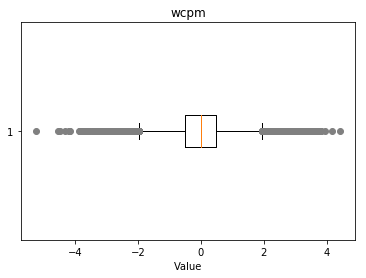

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.66, 4.42, 3.06, 3.12, 3.27, 3.73, 3.11, 3.65, 3.72, 3.42, 4.17, 3.5, -3.39, -3.89, 3.25, -4.53, 3.18, -3.21, 3.43, 3.79, -3.28, -3.03, -3.35, -3.6, -3.85, -3.1, 3.04, -3.78, 3.54, 3.22, -3.17, 3.4, -3.24, -3.42, 3.47, 3.33, -3.56, -3.81, 3.51, 3.01, 3.08, 3.26, 3.58, -4.31, 3.94, -3.7, -3.2, -3.13, 3.8, 3.55, -3.02, 3.37, 3.3, -4.48, 3.48, -3.16, -3.59, -3.09, 3.09, 3.34, -3.73, 3.16, 3.77, -3.05, -3.55, -3.37, -3.12, 3.02, 3.38, 3.2, -3.44, -3.19, -3.69, 3.31, 3.81, -3.26, 3.49, -3.15, 3.17, 3.1, -3.29, -3.79, 3.35, -3.04, 3.46, 3.21, -4.18, 3.32, 3.64, 3.57, 3.14, -3.25, -3.0, 3.07, -5.25, -4.2, -3.57}


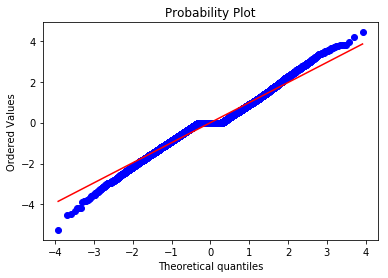

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0388
Kurtosis: 1.354
Overview of variable:  visionwards 


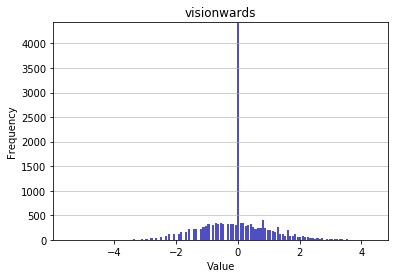

-------------------- 
Summary statistics:
 --------------------
Minimum value: -5.490273450375463
Mean: -0.0
Standard deviation: 1.0
Median: 0.0021
Maximal value: 4.388140571518724


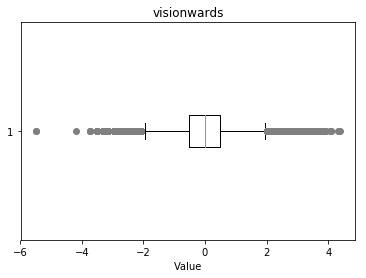

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.56, 3.51, 3.37, 3.08, 3.28, 3.03, 3.88, 3.23, 3.7, 3.18, 4.31, 3.42, -3.32, -3.73, 3.33, -3.14, 4.09, 3.92, 3.13, 3.79, 4.39, 4.05, 3.47, 3.65, -5.49, -4.19, -3.52}


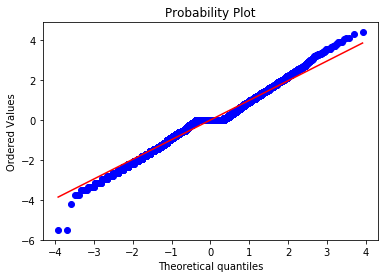

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0413
Kurtosis: 1.1165
Overview of variable:  visionwardbuys 


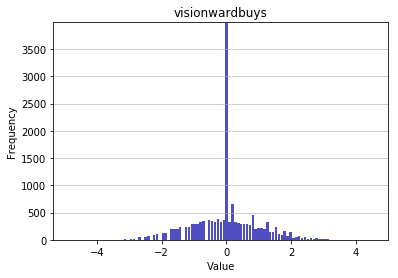

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.873206415682344
Mean: -0.0
Standard deviation: 1.0
Median: -0.0216
Maximal value: 4.537039561414206


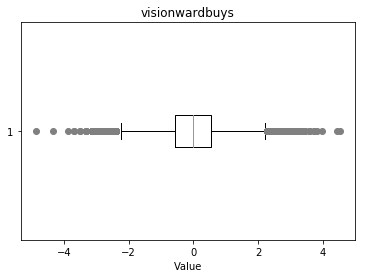

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.19, 3.08, 3.71, 3.4, 3.96, 3.35, 3.14, 4.44, 3.46, 4.54, 3.24, -3.89, -3.31, 3.03, 3.61, 3.3, -3.68, -4.34, 3.82, -3.49, 3.56, -4.87, -3.14}


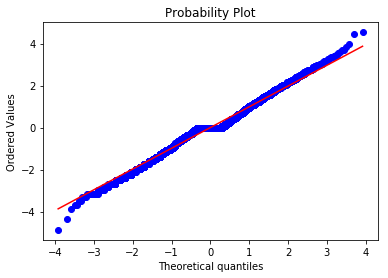

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0271
Kurtosis: 0.6833
Overview of variable:  visiblewardclearrate 


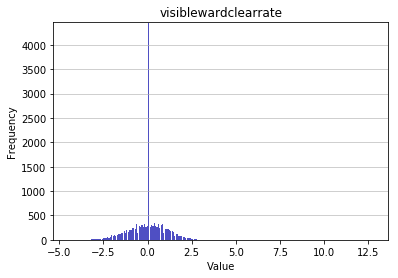

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.474554313575701
Mean: -0.0
Standard deviation: 1.0
Median: 0.043
Maximal value: 12.782409287134769


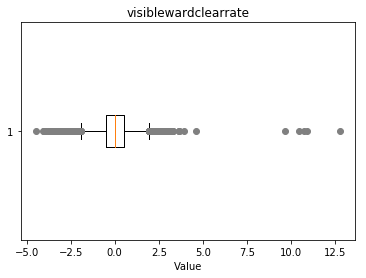

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.65, 3.18, 3.12, 3.01, 3.08, 3.95, 9.63, 4.6, 3.06, 3.32, 10.75, 12.78, 10.91, 10.44, -3.22, -3.15, -3.06, -3.31, -3.98, -3.72, -3.32, -3.47, -4.06, -4.47, 3.03, -3.21, -3.3, -3.45, -3.55, -3.37, -3.38, -3.05, -3.96, -3.2, 3.29, -3.03, -3.11, -3.19, -3.36, -3.18, -3.53, -3.27, -4.01, 3.15, -3.75, -3.17, -3.51, -3.58, -3.01, -3.24, -3.76, -4.0, -3.67}


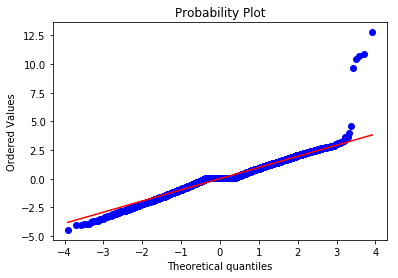

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.177
Kurtosis: 5.428
Overview of variable:  invisiblewardclearrate 


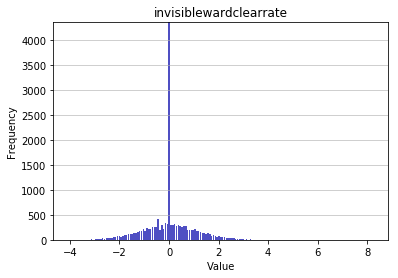

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.053070503318724
Mean: -0.0
Standard deviation: 1.0
Median: -0.0044
Maximal value: 8.234921276347764


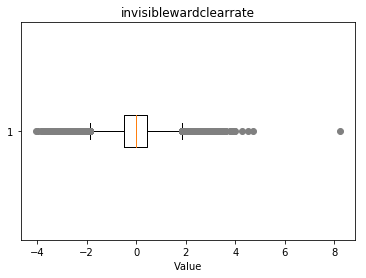

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.37, 3.91, 3.24, 4.73, 3.26, 3.02, 3.27, 3.84, 3.87, 3.1, 4.26, 3.23, 8.23, 3.49, -3.65, -3.48, 3.41, 3.09, 4.01, 4.5, 3.25, 3.08, 3.51, -3.15, 3.16, -3.4, 3.95, 3.31, 3.11, -3.54, 3.18, 3.03, -3.37, -3.13, 3.36, -3.96, 3.6, 3.28, -3.2, -3.07, 3.48, 3.29, -3.43, -3.11, -3.86, 3.3, 3.38, 3.2, 3.13, 3.45, 3.64, -3.81, -3.06, -3.28, 3.93, 3.79, 3.01, -3.27, 3.15, -3.76, -3.09, -3.25, -3.17, 3.14, -3.67, 3.56, -3.01, -3.5, 3.58, 3.44, -4.05, -3.04}


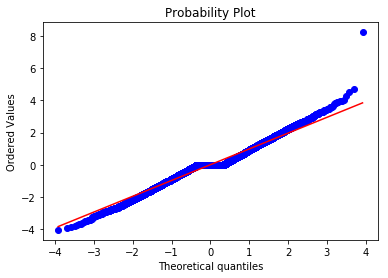

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0908
Kurtosis: 1.3614
Overview of variable:  totalgold 


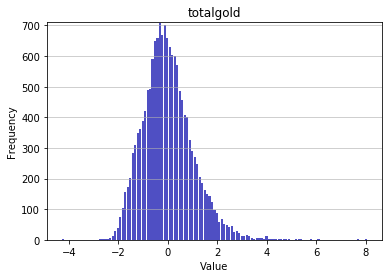

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.2687453943909786
Mean: -0.0
Standard deviation: 1.0
Median: -0.0862
Maximal value: 8.036844212975044


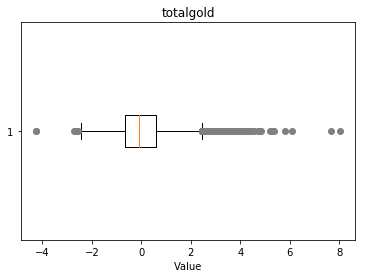

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.63, 3.33, 4.56, 3.07, 3.62, 3.06, 4.01, 3.99, 3.6, 3.16, 4.1, 6.08, 8.04, 3.17, 3.24, 3.01, 3.09, 3.74, 4.18, 4.02, 3.42, 3.26, 3.5, 4.27, 4.84, 4.35, 5.18, 3.0, 5.27, 3.91, 3.13, 4.09, 3.77, 7.66, 3.95, 3.7, 3.67, 3.03, 3.85, 3.02, 3.11, 3.27, 3.36, 3.78, 3.28, 3.19, 3.1, 3.94, 4.77, 3.55, 3.46, 3.57, 3.37, 3.12, 3.3, 3.71, 3.2, 4.03, 4.79, 4.44, 4.7, 4.37, 5.8, 4.04, 5.36, 3.61, 3.86, 3.43, 3.68, 3.25, 3.47, 3.65, 3.14, 3.23, 3.22, 3.97, 3.4, 3.72, 3.64, 3.15, 4.32, 3.08, -4.27}


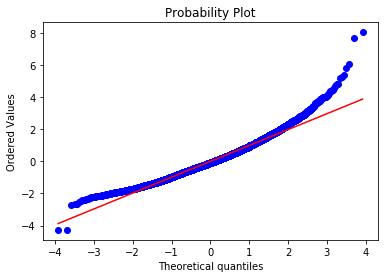

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.6847
Kurtosis: 1.4286
Overview of variable:  earnedgpm 


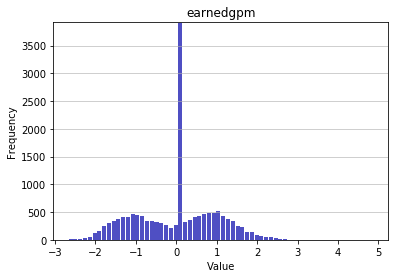

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.6688863417172892
Mean: -0.0
Standard deviation: 1.0
Median: 0.0594
Maximal value: 4.8761986421260115


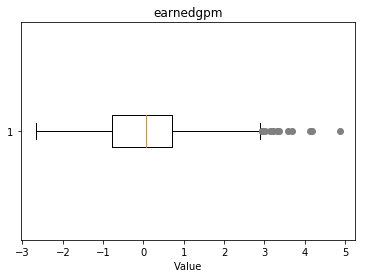

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.19, 3.14, 3.35, 4.88, 3.3, 4.14, 3.59, 3.22, 3.68, 3.02, 4.19}


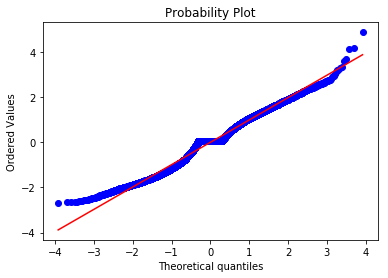

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0289
Kurtosis: -0.3958
Overview of variable:  goldspent 


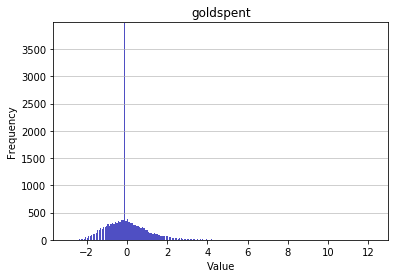

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.9014319580141543
Mean: 0.0
Standard deviation: 1.0
Median: -0.0911
Maximal value: 12.234982606232611


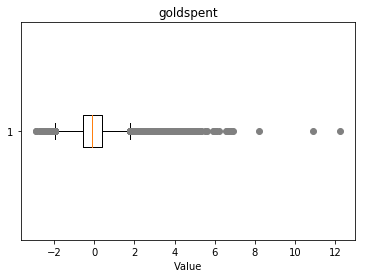

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.38, 3.22, 4.66, 3.33, 3.35, 3.15, 5.17, 5.01, 3.36, 4.33, 4.98, 5.28, 8.19, 3.0, 12.23, 10.86, 3.25, 4.68, 4.07, 4.82, 4.25, 5.93, 5.5, 5.0, 6.57, 3.93, 3.18, 3.68, 3.04, 3.54, 3.79, 4.54, 4.61, 4.47, 4.72, 5.61, 5.29, 6.04, 6.61, 6.72, 6.79, 3.72, 3.4, 3.26, 3.58, 3.01, 3.51, 3.08, 4.83, 4.15, 4.4, 3.69, 3.94, 3.19, 3.44, 3.87, 3.05, 3.8, 3.62, 3.37, 4.12, 4.05, 4.19, 3.3, 3.55, 4.3, 3.23, 3.73, 3.91, 3.66, 3.34, 3.16, 3.09, 4.27, 4.91, 4.48, 5.09, 5.98, 5.02, 6.23, 3.77, 3.52, 3.27, 3.02, 3.7, 3.95, 3.13, 3.45, 3.2, 4.45, 4.7, 4.2, 4.06, 4.38, 5.06, 4.81, 5.13, 5.31, 4.95, 6.06, 6.88, 3.06, 3.56, 3.99, 3.17, 3.92, 3.24, 3.67, 4.1, 4.42, 4.99, 4.67, 3.53, 3.78, 3.1, 3.28, 4.13, 3.46, 4.46, 4.64, 4.21, 6.64, 3.14, 3.39, 3.32}


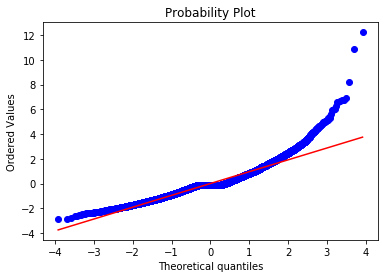

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.3098
Kurtosis: 5.8648
Overview of variable:  gspd 


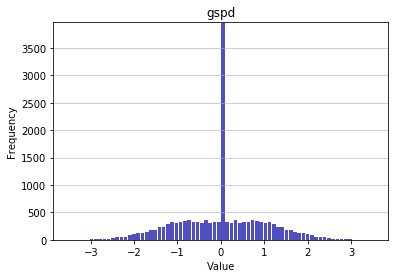

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.5164117807291424
Mean: 0.0
Standard deviation: 1.0
Median: 0.0
Maximal value: 3.5164117807291424


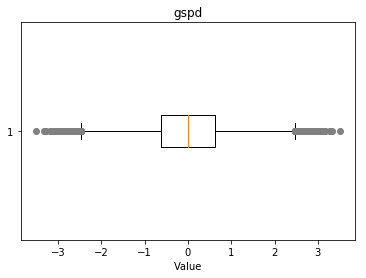

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.18, 3.01, 3.03, 3.29, 3.16, 3.28, 3.1, 3.33, 3.04, 3.52, -3.01, -3.03, -3.29, -3.16, -3.28, -3.1, -3.33, -3.04, -3.52, -3.18}


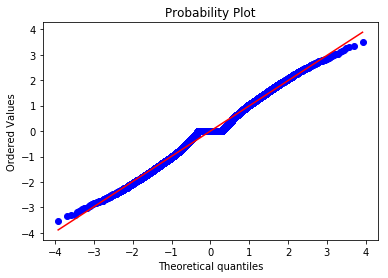

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 0.1146
Overview of variable:  minionkills 


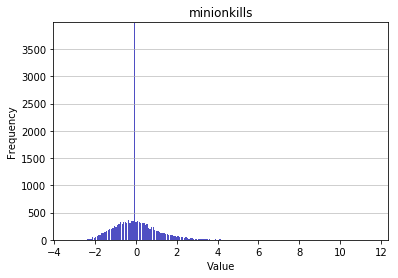

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.3091197486530364
Mean: -0.0
Standard deviation: 1.0
Median: -0.0812
Maximal value: 11.620255036922257


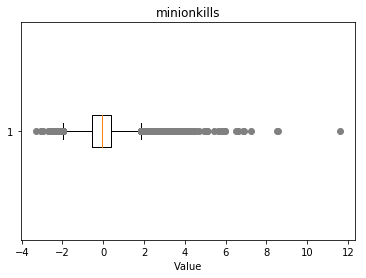

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.29, 3.12, 3.4, 4.94, 3.87, 3.66, 3.48, 3.38, 3.19, 3.3, 4.16, 5.09, 6.87, 3.75, 3.25, 11.62, 3.0, 4.0, 4.68, 4.25, 4.43, 6.0, 6.93, 3.11, 3.18, 3.43, 3.36, 3.61, 3.04, 3.54, 4.22, 4.54, 4.29, 6.61, 3.15, 3.47, 3.9, 3.58, 3.26, 3.01, 3.33, 3.08, 4.33, 4.4, 4.15, -3.31, 3.44, 3.94, 3.8, 3.55, 3.05, 3.62, 4.12, 4.19, 3.98, 3.73, 3.16, 3.41, 3.91, 3.09, 3.59, 4.23, 4.02, 4.09, 5.84, 5.77, 7.27, 3.52, 3.27, 3.88, 3.13, 3.2, 3.45, 3.7, 4.13, 5.63, 5.45, 3.06, 3.31, -3.01, 3.24, 3.49, 3.42, 4.17, 4.1, 5.99, 5.1, 6.6, 6.49, 8.56, 8.53, 3.28, 3.1, 3.03, 3.78, -3.04, 3.46, 4.39, 3.39, 3.14, 3.32, 3.89, 3.07, 3.57, 3.82, -3.03}


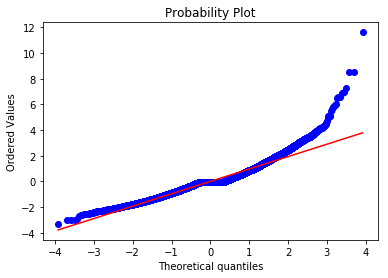

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.0893
Kurtosis: 4.4423
Overview of variable:  monsterkills 


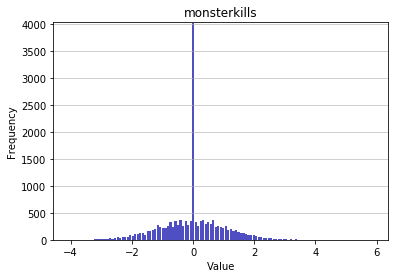

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.072646836979391
Mean: 0.0
Standard deviation: 1.0
Median: 0.0133
Maximal value: 5.887311929083835


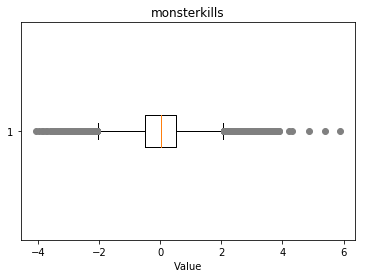

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.66, 3.09, 3.36, 4.87, 3.89, 3.71, 5.89, 3.2, 3.81, 5.4, 4.21, 3.48, 3.59, -3.4, 3.01, 3.74, 3.26, 3.5, -3.98, -3.32, 3.63, 3.86, -3.05, -3.88, -3.12, -3.2, 3.35, 3.18, 3.32, 3.12, -3.28, -3.61, -3.36, 3.55, 3.13, 3.39, 3.38, 4.3, -3.53, 3.29, 3.9, 3.56, -3.08, -3.84, -3.49, -3.75, -3.16, 3.64, 3.06, 3.07, 3.82, 3.22, -4.07, -3.7}


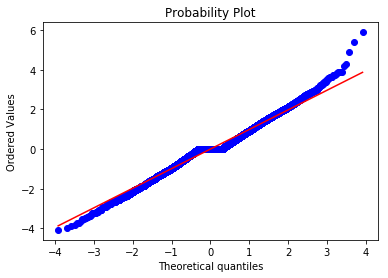

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0311
Kurtosis: 0.9394
Overview of variable:  monsterkillsownjungle 


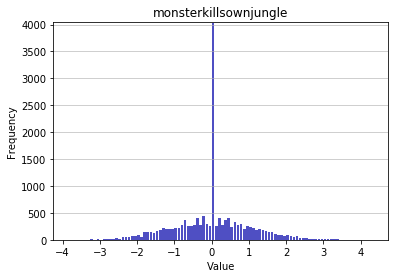

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.8433408988070052
Mean: -0.0
Standard deviation: 1.0
Median: 0.0029
Maximal value: 4.341066292297275


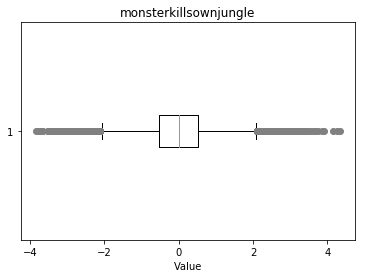

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.15, 3.68, 4.16, 3.3, 3.63, 4.26, 3.33, 3.35, 4.34, 3.1, 3.24, -3.31, -3.07, 3.74, 3.91, 3.01, 3.08, -3.64, 3.17, 3.19, -3.38, -3.13, -3.7, 3.28, 3.03, 3.85, 3.44, 3.21, -3.77, -3.19, 3.55, 3.12, 3.05, 3.39, -3.25, -3.01, -3.5, -3.84, 3.48, -3.44}


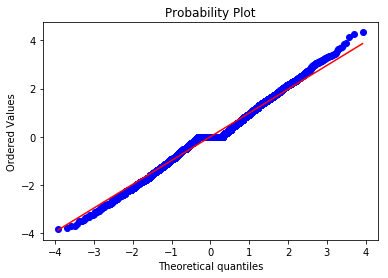

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0257
Kurtosis: 0.7168
Overview of variable:  monsterkillsenemyjungle 


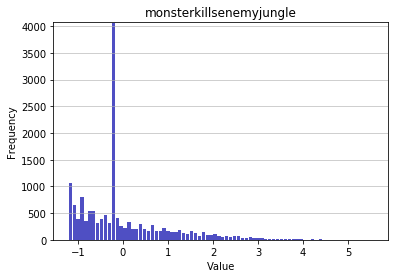

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.2109005747012915
Mean: 0.0
Standard deviation: 1.0
Median: -0.2382
Maximal value: 5.560513814288788


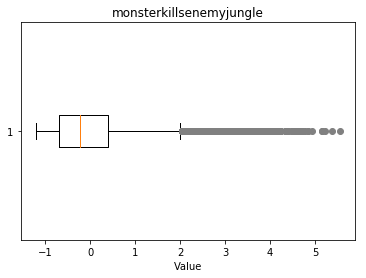

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.13, 3.32, 5.15, 4.21, 3.24, 3.02, 4.48, 4.77, 3.39, 3.62, 4.51, 5.22, 4.33, 3.91, 3.99, 3.09, 3.17, 3.84, 4.18, 3.58, 3.5, 4.4, 3.76, 4.25, 4.1, 4.74, 4.92, 4.66, 4.59, 3.69, 3.35, 3.43, 3.28, 4.85, 3.8, 3.95, 3.05, 3.2, 3.54, 4.36, 4.14, 3.88, 4.7, 4.63, 4.55, 4.06, 4.03, 5.56, 5.37, 3.65, 3.47, 3.73}


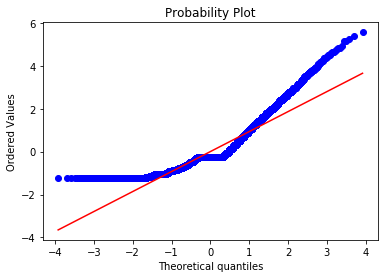

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.4228
Kurtosis: 2.1914
Overview of variable:  cspm 


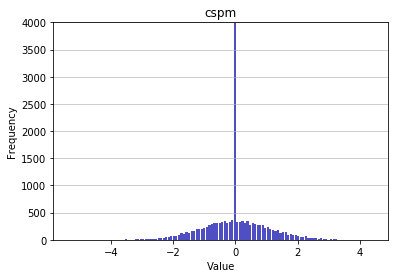

-------------------- 
Summary statistics:
 --------------------
Minimum value: -5.356462021899558
Mean: 0.0
Standard deviation: 1.0
Median: -0.0104
Maximal value: 4.424918533817415


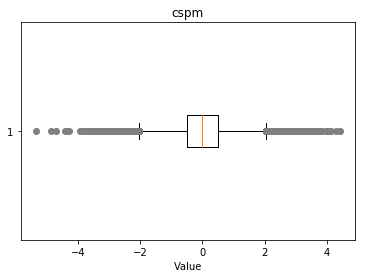

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.74, 4.42, 3.5, 3.16, 3.15, 3.1, 3.21, 3.51, 4.29, 3.18, 4.07, 3.8, 3.12, 3.17, -3.15, -3.07, -3.23, -3.06, -3.72, 4.0, 3.67, 4.15, 3.08, 3.27, 3.41, 3.02, -3.76, -3.65, 3.09, -3.34, 3.7, 3.31, 3.06, 3.28, -4.72, 3.36, -3.05, -3.04, -3.12, -3.21, -3.3, -3.55, -3.46, -3.54, -3.8, -3.29, 3.39, 3.24, 3.85, 3.05, 3.47, 3.97, 3.64, -3.1, -3.19, -3.35, -3.69, -3.93, -3.03, -3.11, -3.53, -3.85, 3.61, 3.11, 3.43, 3.54, 3.4, -4.85, -4.34, -4.27, 3.22, -3.41, -3.01, -3.33, -3.0, -3.25, -3.59, -3.09, -3.08, -3.49, -3.51, -5.36, -4.4, -3.18}


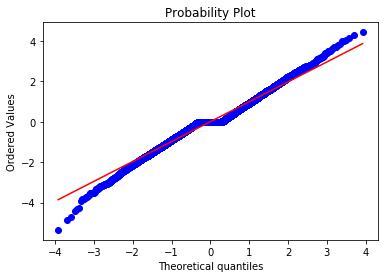

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0043
Kurtosis: 1.135
Overview of variable:  goldat10 


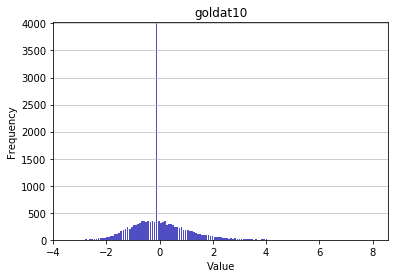

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.4272250166152496
Mean: 0.0
Standard deviation: 1.0
Median: -0.0879
Maximal value: 8.021749121794242


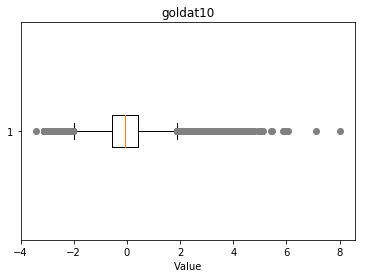

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.09, 3.23, 5.92, 4.49, 3.13, 3.31, 3.42, 3.24, 4.32, 3.74, 4.56, 5.14, 7.11, 3.25, 3.5, 4.5, 4.0, 4.68, 5.93, 3.61, 3.68, 3.18, 3.36, 3.86, 3.43, 3.29, -3.1, 3.04, 4.29, 4.04, 4.61, 4.36, 3.65, 3.22, 3.97, 3.15, 3.47, 3.83, 3.01, 3.26, 3.33, 3.08, 4.26, -3.06, 5.9, 3.94, -3.13, 3.05, -3.02, 3.87, 3.12, 3.55, 4.19, 4.12, 3.3, 3.37, 3.62, 5.87, 4.55, 3.48, 3.73, 3.34, 3.59, 3.41, 3.16, 3.66, 4.23, 4.02, 4.16, 4.77, 5.48, 8.02, 3.27, -3.12, 3.77, 3.63, 3.38, 3.7, 3.45, 3.2, 4.2, 4.38, 5.06, 6.06, 3.81, -3.01, 3.06, 3.92, 3.17, 3.67, 3.49, 4.1, 4.92, 4.24, 5.42, 3.6, 3.28, 3.1, -3.04, 3.03, 3.35, 3.46, 3.96, 4.03, 4.71, 4.78, 5.03, 3.14, 3.82, 3.07, 3.39, -3.43}


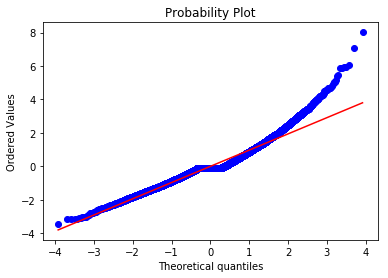

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.87
Kurtosis: 2.6545
Overview of variable:  gdat10 


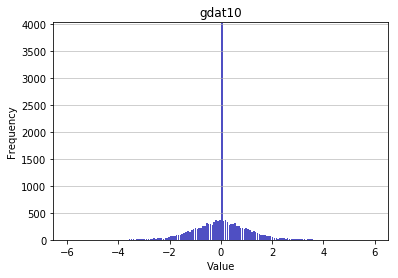

-------------------- 
Summary statistics:
 --------------------
Minimum value: -5.936761999939597
Mean: 0.0
Standard deviation: 1.0
Median: 0.0
Maximal value: 5.936761999939597


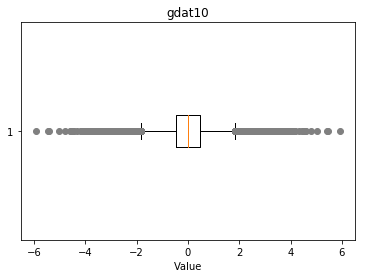

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.52, 3.17, 5.94, 4.16, 3.3, 3.51, 3.43, 4.03, 3.36, 4.33, 4.48, 5.03, 3.5, -3.39, -3.64, 3.0, -3.89, -3.07, 3.25, 4.57, 3.75, -5.03, -4.46, -4.03, 3.11, 3.61, -3.46, 3.54, -3.35, -3.78, -3.03, -3.85, -3.1, -3.28, 3.29, -5.42, 3.22, -3.92, 3.15, -3.17, -3.42, 3.4, -3.24, 3.47, 3.97, -3.49, 3.58, 3.08, 3.26, 3.33, 3.01, 4.01, 4.08, 3.94, -3.2, -3.45, -3.13, -3.95, 3.44, -3.7, -3.38, 3.37, -3.02, -3.52, 3.05, 3.55, 4.19, 4.8, -5.48, -4.16, -4.48, -4.52, -4.59, 3.23, -3.41, -3.59, -3.16, -3.66, 3.48, 3.59, 3.16, 3.41, 3.66, -3.48, 4.52, 4.59, 4.09, 5.48, -4.19, -4.8, 3.02, -3.3, -3.37, -3.05, -3.55, 3.13, 3.2, 3.45, -3.94, 3.95, 4.06, -3.44, 3.7, 3.38, -4.33, -4.01, -4.08, -3.26, -3.51, -3.58, -3.08, -3.33, -3.01, 3.42, -3.15, 3.92, -3.22, -3.4, 3.24, -3.47, -3.97, 3.49, 5.42, 3.78, -3.54, 3.03, 3.85, 3.1, 3.35, 3.28, -3.29, 3.46, -3.43, -3.36, -3.11, -3.61, 4.46, -4.09, -4.57, 3.64, 3.39, -3.5, -3.0, 3.89, 

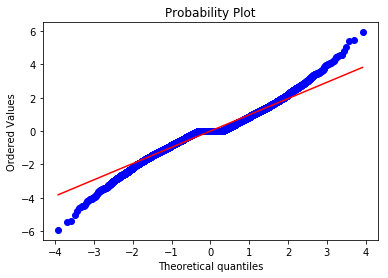

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 2.2954
Overview of variable:  goldat15 


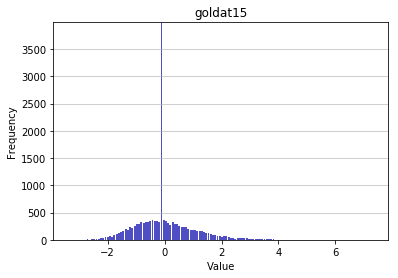

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.3749394859029387
Mean: 0.0
Standard deviation: 1.0
Median: -0.0897
Maximal value: 7.3272149523433106


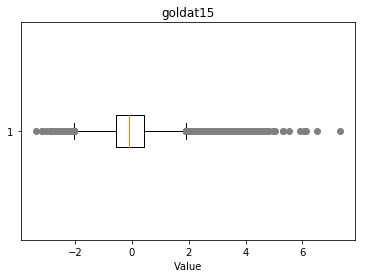

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.85, 4.23, 3.5, 4.75, 4.14, 4.01, 3.3, 3.39, 3.13, 3.18, 5.31, 7.33, 6.05, -3.14, 4.18, 4.43, 4.07, 4.68, 3.11, 3.36, 3.61, 3.93, 3.68, 3.04, 3.54, 3.79, 4.22, 4.54, 5.04, 3.65, 3.4, 3.22, 3.72, 3.15, 3.01, 3.76, 3.26, 3.33, 3.08, 4.51, 4.4, 3.51, 6.51, 3.69, 3.94, 3.44, 3.19, 3.62, 3.37, -3.02, 3.12, 3.05, 4.37, 4.55, 4.44, 3.23, -3.16, 3.48, 3.66, 3.16, 3.34, 3.09, 4.59, 4.34, 4.16, 4.98, 4.84, 5.52, 4.77, 3.77, 3.02, 3.27, 3.45, 3.63, 3.2, 4.2, 3.81, 3.31, 3.49, 3.74, 3.67, 3.42, 3.99, 3.24, 5.92, 3.28, 3.53, 3.03, 3.78, 3.1, 3.71, 3.96, 3.46, 4.46, 4.53, 4.71, 6.14, 3.57, 3.14, 3.82, -3.37}


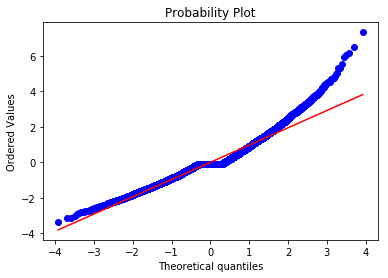

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8323
Kurtosis: 2.2146
Overview of variable:  gdat15 


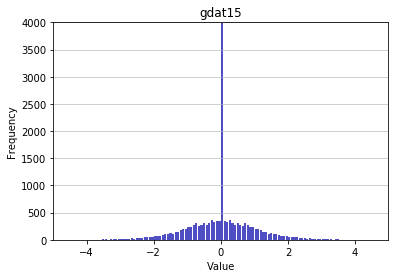

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.537534651874203
Mean: 0.0
Standard deviation: 1.0
Median: 0.0
Maximal value: 4.537534651874203


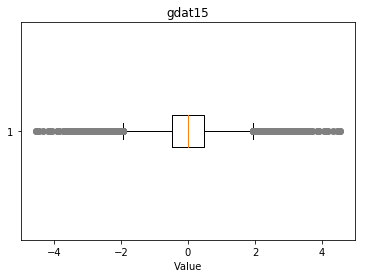

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.06, 3.13, 4.45, 3.01, 3.15, 3.58, 3.31, 3.29, 4.5, 4.19, 4.07, 3.25, -3.32, -3.07, -3.14, -3.64, -3.89, -3.39, -3.57, 3.0, 3.5, -4.53, 3.11, -3.46, -3.71, 3.04, -3.35, -3.03, -3.1, -3.53, 4.54, 3.9, -3.24, -3.17, -3.42, 3.22, 3.47, 3.4, 3.26, -3.31, -3.06, 3.51, 3.83, 4.51, -4.45, -4.31, 3.19, -3.13, -3.2, -3.7, -3.63, -3.88, 3.05, -3.27, -3.02, 3.3, 4.12, 3.23, -3.09, 3.09, -3.23, -4.12, 3.27, -3.05, 3.02, -3.3, 3.63, 3.7, 3.2, -3.19, 3.88, 4.31, -4.51, -3.51, -3.58, -3.26, -3.01, -3.83, 3.42, -3.9, -3.22, 3.17, 3.24, -3.47, -3.4, -4.54, 3.35, -3.29, -3.04, 3.03, 3.1, 3.53, 3.46, -3.11, 3.71, 4.53, -4.07, -4.5, 3.89, 3.32, -3.25, 3.07, 3.14, 3.64, 3.39, 3.57, -3.0, -3.5, -4.19, -3.15}


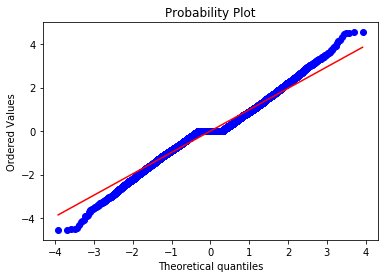

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.4767
Overview of variable:  xpat10 


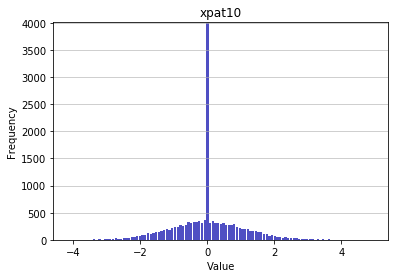

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.137872033108025
Mean: -0.0
Standard deviation: 1.0
Median: -0.0085
Maximal value: 4.947528950988392


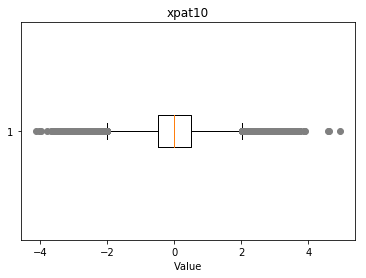

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.59, 3.03, 3.9, 3.87, 3.26, 3.3, 3.35, 3.09, 3.42, 3.6, 4.58, 3.25, -3.39, 3.5, 3.0, -4.14, 3.43, -3.21, 3.18, 3.54, -3.35, -3.53, -3.28, 3.04, 4.61, 3.29, 3.47, -3.24, -3.42, 3.15, 3.65, 3.72, 3.76, -3.06, 3.08, 3.58, 3.44, -3.13, -3.2, -3.38, 3.62, 3.55, 3.05, -3.52, -3.02, 3.12, 3.73, -3.09, -3.41, 3.16, -3.23, -3.98, 3.66, 3.02, -3.05, -3.62, -3.3, -3.8, 3.63, 3.45, -3.19, 3.2, 3.13, 4.95, 3.31, -3.08, -3.01, 3.06, 3.74, -3.22, -3.65, -3.15, -3.4, 3.28, 3.1, -3.04, -3.29, 3.71, -3.68, -3.18, 3.14, 3.32, -3.0, -3.5, -4.05, -3.57}


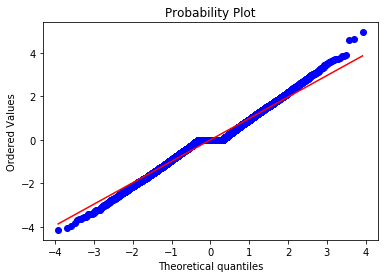

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0541
Kurtosis: 1.0056
Overview of variable:  xpdat10 


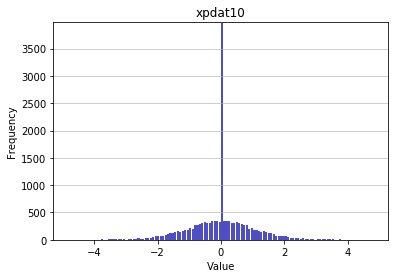

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.811336554771536
Mean: 0.0
Standard deviation: 1.0
Median: 0.0
Maximal value: 4.811336554771536


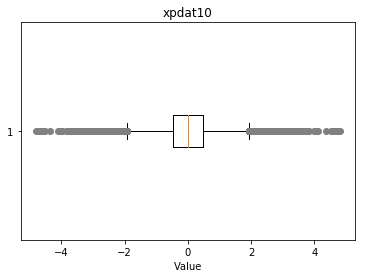

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.29, 3.5, 3.03, 4.6, 4.03, 3.42, 3.07, 3.41, 3.52, 3.09, 4.69, 3.25, -3.57, -3.32, -3.64, -4.03, 3.68, 3.11, -3.21, -3.46, 3.61, 3.36, 3.54, -3.03, -3.78, 4.11, 4.36, -4.6, -4.74, 3.65, -3.99, -3.67, 3.15, -3.42, 3.4, 3.22, -3.17, -3.74, 3.76, -3.56, 3.33, 3.08, 3.26, -3.31, 3.51, -4.81, 3.19, -3.13, 3.44, 3.55, -3.52, 3.3, 3.37, 3.05, 3.12, -3.77, 3.62, -4.66, -4.52, -4.02, 3.73, -3.41, -3.09, -3.16, -3.84, -3.59, 3.16, 3.84, 3.59, -3.73, 4.66, 4.52, 4.02, 3.77, -3.55, -3.3, -3.37, -3.05, -3.12, -3.62, 3.13, -3.19, -3.44, 4.81, 3.56, -3.76, -3.33, -3.08, -3.26, 3.31, -3.51, 3.67, -3.15, -3.4, -3.65, -3.22, 4.74, 3.99, 3.17, 3.74, -4.11, -4.36, 3.78, -3.29, -3.54, 3.21, -3.61, 3.46, -3.68, -3.11, -3.36, 3.57, -3.25, -3.5, 3.32, 3.64, -4.69, -3.07}


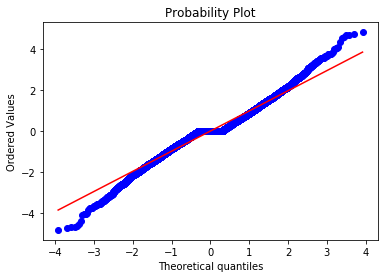

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.7043
Overview of variable:  csat10 


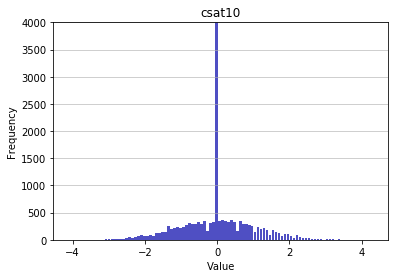

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.117647742911232
Mean: -0.0
Standard deviation: 1.0
Median: -0.013
Maximal value: 4.320204154118391


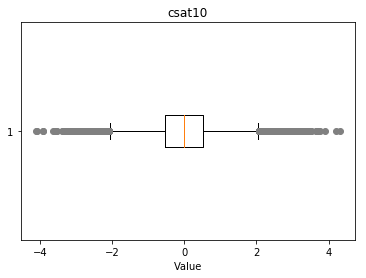

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.65, 3.15, 3.2, 3.4, 3.7, 3.5, 3.35, 3.0, 4.22, 3.25, 4.32, 3.91, -3.56, -3.22, -3.32, 3.75, -3.39, 3.1, -3.04, -3.29, -3.63, 3.05, -3.18, -3.36, -3.11, 3.3, 3.45, -3.53, -4.09, -3.92, -3.59, -3.25, -3.01, -4.12, -3.08}


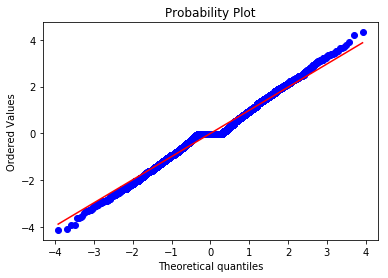

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0297
Kurtosis: 0.6983
Overview of variable:  csdat10 


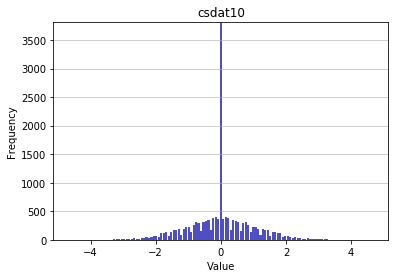

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.6804291562884925
Mean: 0.0
Standard deviation: 1.0
Median: 0.0
Maximal value: 4.6804291562884925


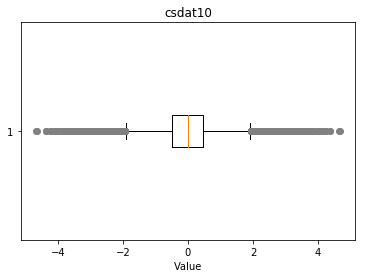

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.81, 3.08, 4.38, 3.21, 3.12, 3.68, 3.64, 3.03, 3.25, 3.29, 4.07, 3.51, -3.64, 3.16, 3.42, 3.34, 4.68, 3.99, -3.47, -3.9, 4.25, -4.2, -4.12, -4.03, -4.64, 3.77, -3.21, -3.12, -3.29, -3.55, 3.6, 3.55, -3.68, -3.03, -3.77, -3.6, 4.2, 4.12, 4.03, 4.64, -4.07, -4.68, -4.25, 3.47, -3.25, -3.51, -3.08, -3.16, -3.42, -3.34, -3.99, 3.9, -4.38, -3.81}


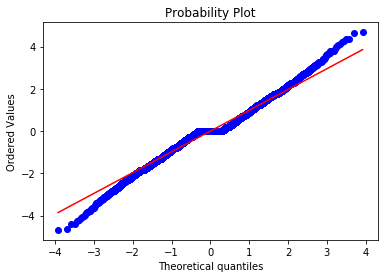

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.2415
Overview of variable:  csat15 


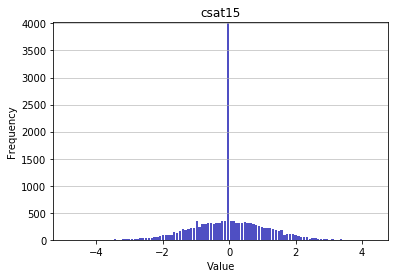

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.839395654820991
Mean: 0.0
Standard deviation: 1.0
Median: -0.0139
Maximal value: 4.3401972039628385


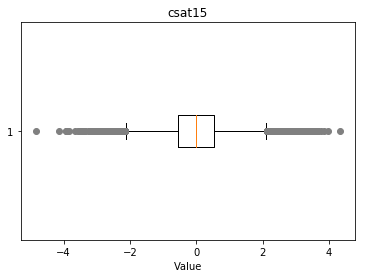

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.25, 3.16, 3.34, 3.07, 3.97, 3.52, 3.61, 3.1, 3.67, 3.28, 4.34, 3.58, -3.06, -3.22, -3.14, -3.48, 3.76, 3.49, 3.01, -3.9, -3.4, 3.19, -3.04, -3.55, -3.45, -3.37, 3.85, 3.43, 3.37, -3.19, -3.93, -3.27, -3.53, 3.04, 3.55, 3.46, -3.35, -4.15, 3.31, -3.42, -3.17, -3.09, -3.83, -3.01, -3.5, 3.22, 3.64, -4.84, -3.65}


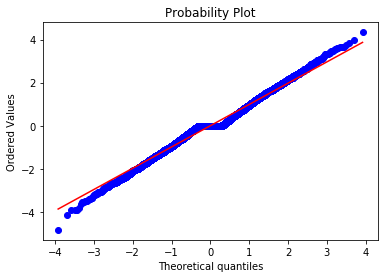

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0245
Kurtosis: 0.7586
Overview of variable:  csdat15 


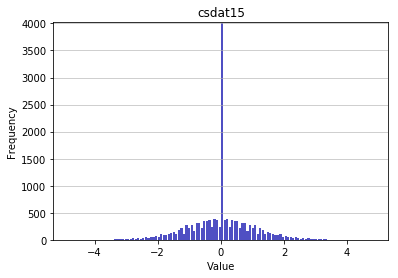

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.826122405436522
Mean: 0.0
Standard deviation: 1.0
Median: 0.0
Maximal value: 4.826122405436522


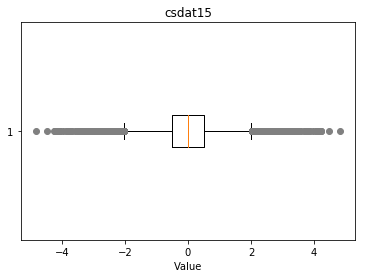

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.26, 3.08, 4.12, 3.79, 4.06, 3.11, 3.2, 3.85, 3.32, 3.17, 4.15, 3.58, -3.32, -3.82, -3.73, -3.14, 3.67, 3.49, 3.76, 4.23, -3.23, 4.09, 3.88, 4.83, 3.7, -4.12, -4.47, -4.2, -3.97, 3.52, -3.79, -3.2, -3.38, -3.29, -3.46, -3.05, 3.43, 3.35, 3.02, -3.7, 3.38, -3.11, -3.85, 3.29, 3.46, 3.05, -3.52, -3.43, 4.47, -3.35, 4.2, -4.83, -3.88, -4.15, -4.23, -3.02, -4.09, 3.82, -3.17, -3.08, 3.73, 3.14, -3.58, -3.67, -3.49, -3.76, 3.23, 3.97, -4.06, -3.26}


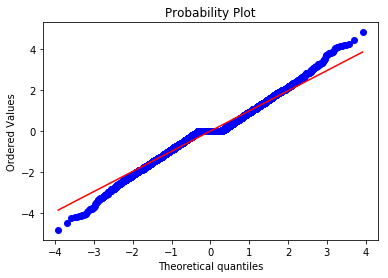

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.2776
Overview of variable:  datediff 


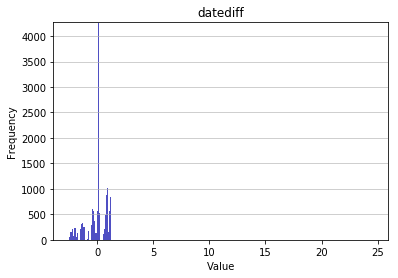

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.572308528456935
Mean: -0.0
Standard deviation: 1.0
Median: 0.1156
Maximal value: 24.60338015804534


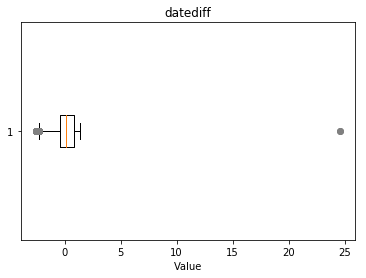

-------------------- 
Outlier detection:
 --------------------
List of outliers: {24.6}


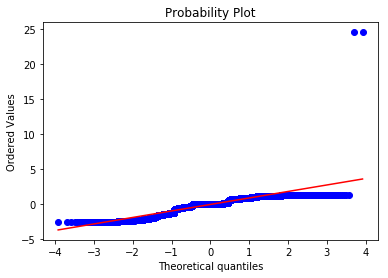

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.1978
Kurtosis: 46.8433
Overview of variable:  Encoded_league 


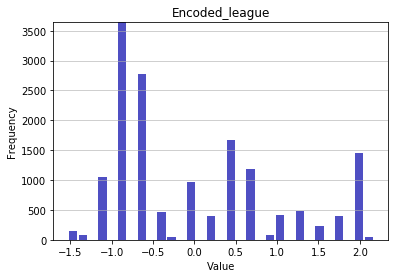

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.5289244057984925
Mean: -0.0
Standard deviation: 1.0
Median: -0.441
Maximal value: 2.169863527779885


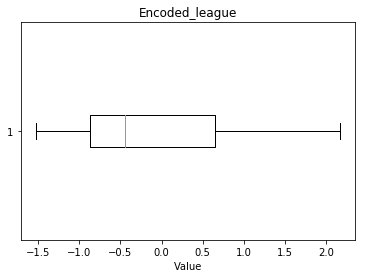

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


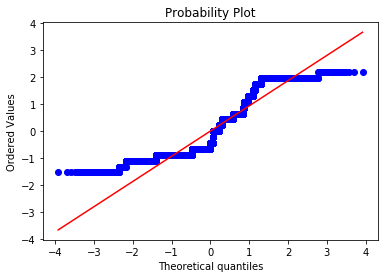

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7069
Kurtosis: -0.775
Overview of variable:  Encoded_game 


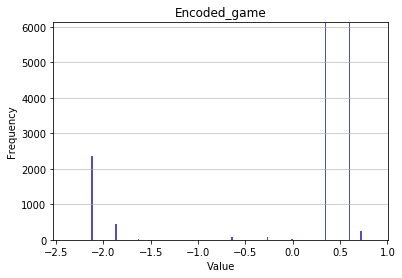

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.370571958440799
Mean: -0.0
Standard deviation: 1.0
Median: 0.3535
Maximal value: 0.8487355196959117


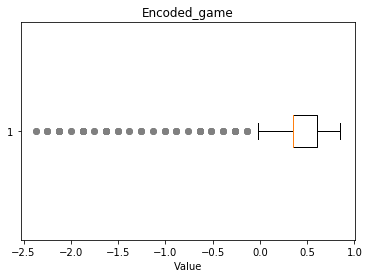

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


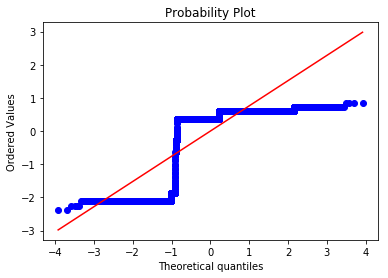

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -1.5581
Kurtosis: 0.5481
Overview of variable:  Encoded_side 


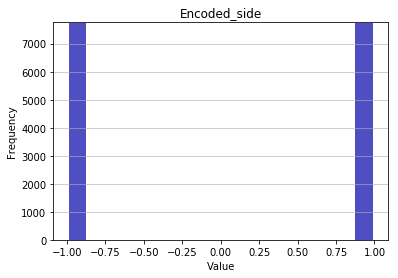

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.0
Mean: 0.0
Standard deviation: 1.0
Median: 0.0
Maximal value: 1.0


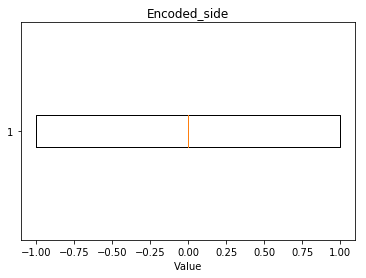

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


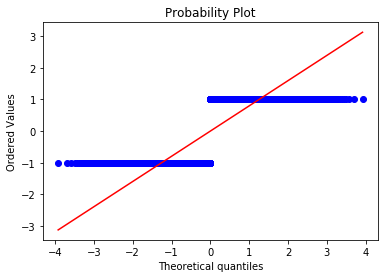

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -2.0
Overview of variable:  Encoded_ban1 


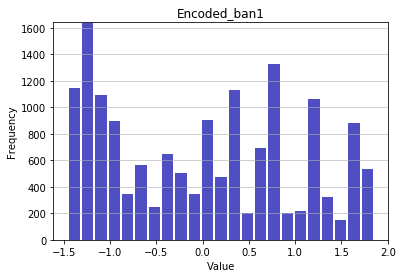

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.4563938677115957
Mean: 0.0
Standard deviation: 1.0
Median: 0.0426
Maximal value: 1.8518239434993602


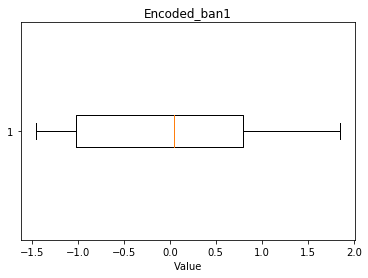

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


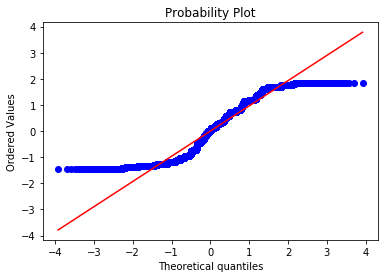

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1798
Kurtosis: -1.2391
Overview of variable:  Encoded_ban2 


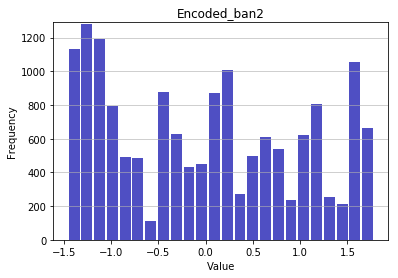

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.4586187668048527
Mean: 0.0
Standard deviation: 1.0
Median: -0.0133
Maximal value: 1.7809310895255037


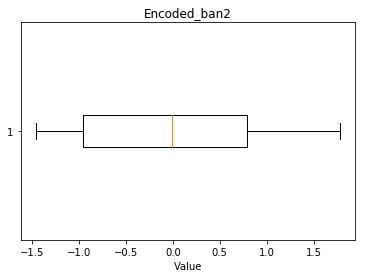

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


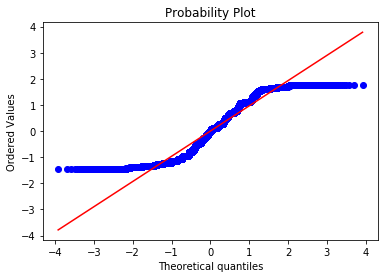

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2085
Kurtosis: -1.2392
Overview of variable:  Encoded_ban3 


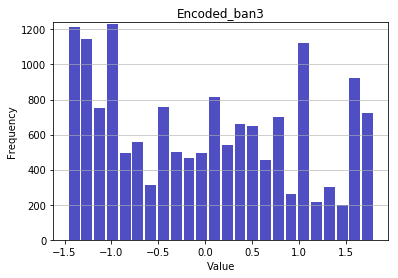

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.4659663052043173
Mean: 0.0
Standard deviation: 1.0
Median: 0.0057
Maximal value: 1.7961570395209359


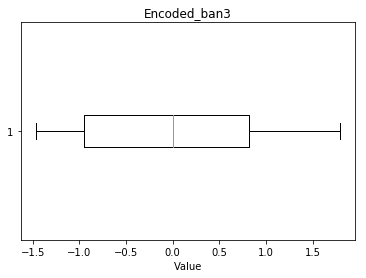

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


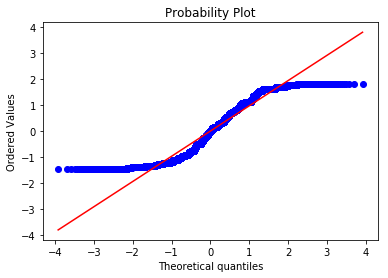

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1917
Kurtosis: -1.246
Overview of variable:  Encoded_ban4 


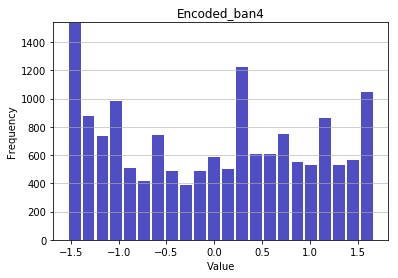

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.5313634186001406
Mean: -0.0
Standard deviation: 1.0
Median: 0.0907
Maximal value: 1.6664843356789725


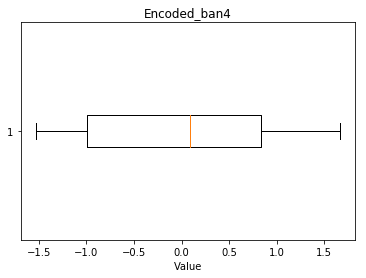

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


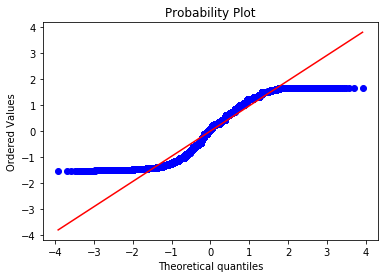

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0443
Kurtosis: -1.3027
Overview of variable:  Encoded_ban5 


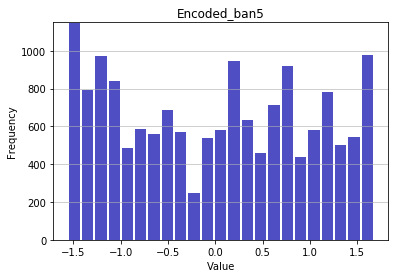

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.5612741517264634
Mean: -0.0
Standard deviation: 1.0
Median: 0.0452
Maximal value: 1.675257212451049


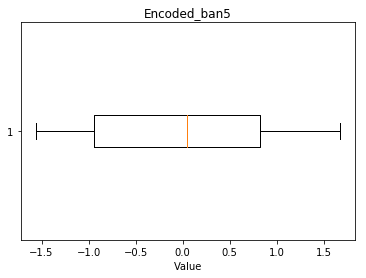

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


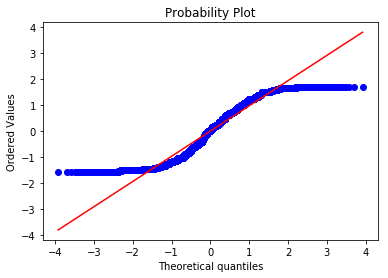

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0467
Kurtosis: -1.2919
Overview of variable:  Encoded_result 


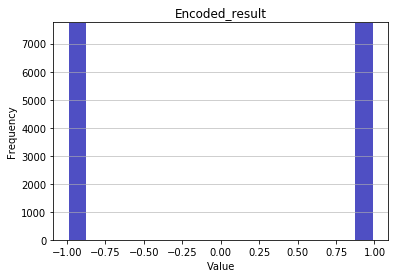

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.0
Mean: 0.0
Standard deviation: 1.0
Median: 0.0
Maximal value: 1.0


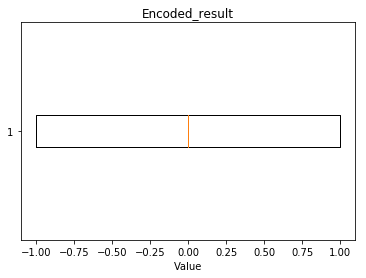

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


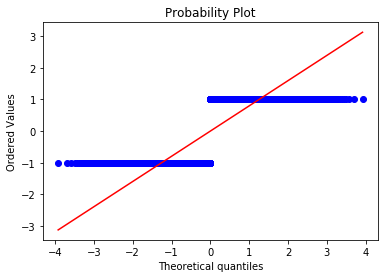

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -2.0
Overview of variable:  Encoded_fb 


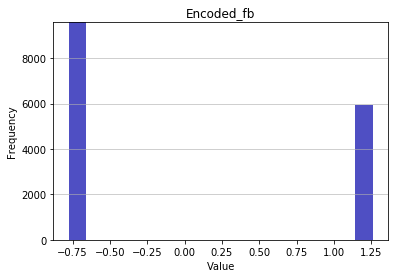

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.7869032406736979
Mean: -0.0
Standard deviation: 1.0
Median: -0.7869
Maximal value: 1.2708042721286315


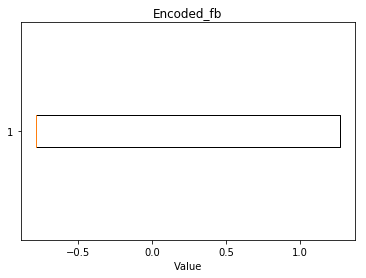

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


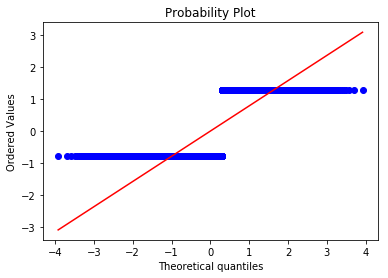

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4839
Kurtosis: -1.7658
Overview of variable:  Encoded_fbassist 


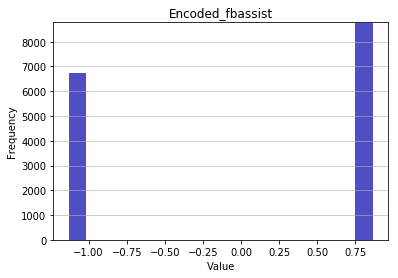

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.1418032712567432
Mean: 0.0
Standard deviation: 1.0
Median: 0.8758
Maximal value: 0.875807615176417


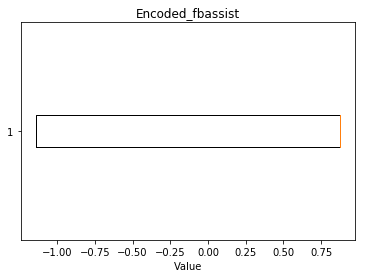

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


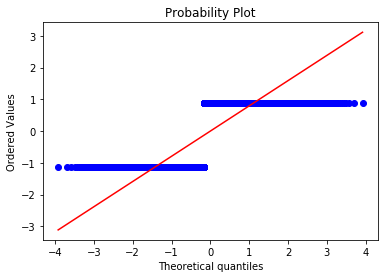

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.266
Kurtosis: -1.9292
Overview of variable:  Encoded_fbvictim 


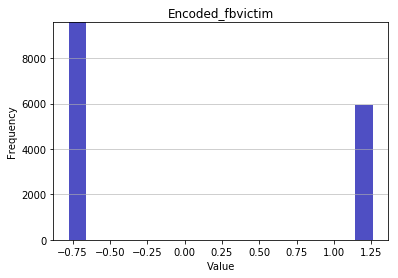

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.7869032406736979
Mean: -0.0
Standard deviation: 1.0
Median: -0.7869
Maximal value: 1.2708042721286315


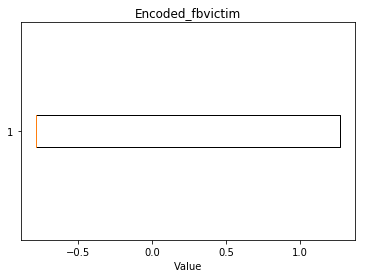

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


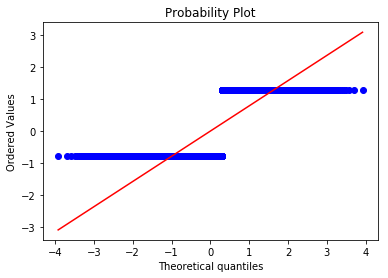

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4839
Kurtosis: -1.7658
Overview of variable:  Encoded_fd 


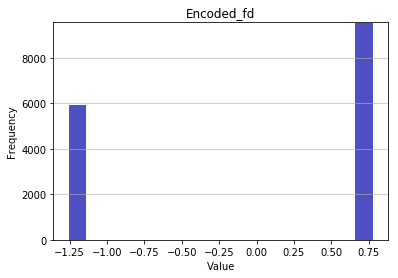

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.2682052472392504
Mean: 0.0
Standard deviation: 1.0
Median: 0.7885
Maximal value: 0.7885158984926888


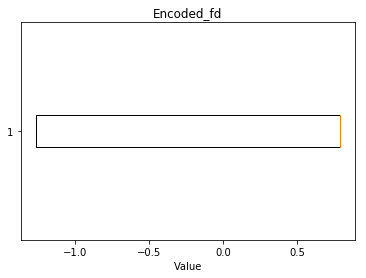

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


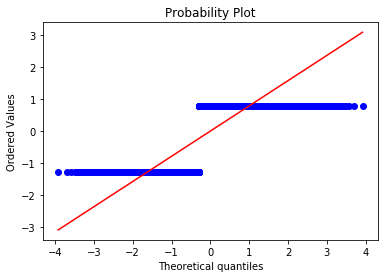

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.4797
Kurtosis: -1.7699
Overview of variable:  Encoded_herald 


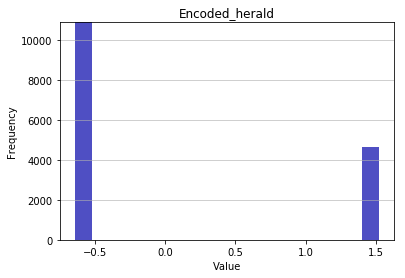

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.6523220751583336
Mean: -0.0
Standard deviation: 1.0
Median: -0.6523
Maximal value: 1.532985066858694


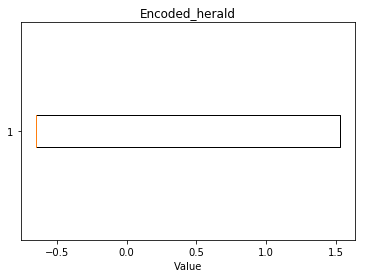

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


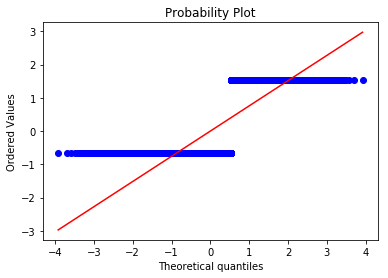

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8807
Kurtosis: -1.2244
Overview of variable:  Encoded_ft 


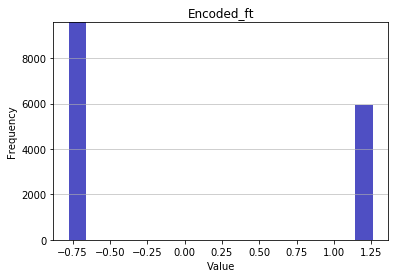

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.7869032406736979
Mean: -0.0
Standard deviation: 1.0
Median: -0.7869
Maximal value: 1.2708042721286315


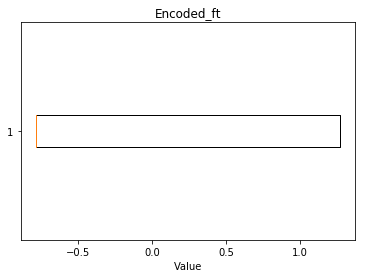

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


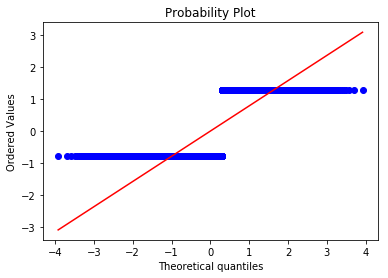

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4839
Kurtosis: -1.7658
Overview of variable:  Encoded_firstmidouter 


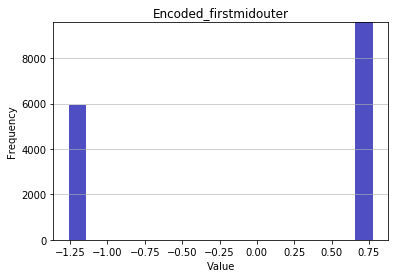

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.270630760492977
Mean: 0.0
Standard deviation: 1.0
Median: 0.787
Maximal value: 0.7870106966496088


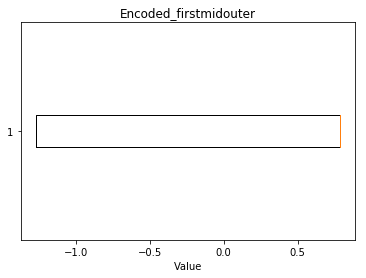

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


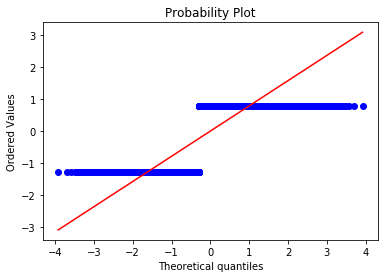

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.4836
Kurtosis: -1.7661
Overview of variable:  Encoded_firsttothreetowers 


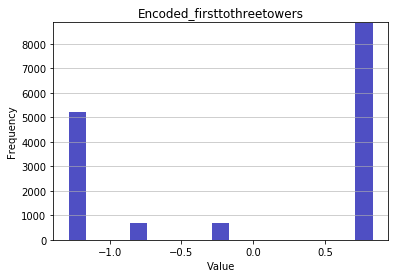

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.2959258820775743
Mean: -0.0
Standard deviation: 1.0
Median: 0.8415
Maximal value: 0.8414677910407695


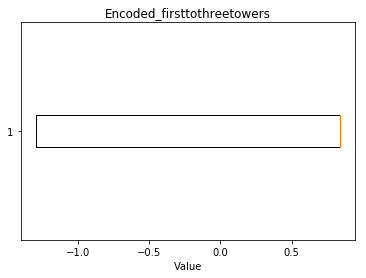

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


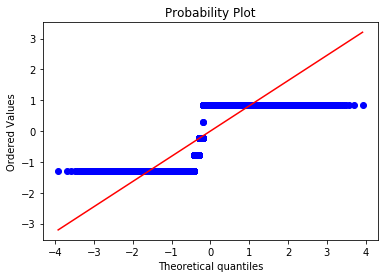

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.4133
Kurtosis: -1.7468
Overview of variable:  Encoded_fbaron 


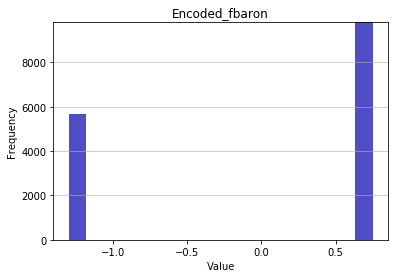

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.3122157263040064
Mean: -0.0
Standard deviation: 1.0
Median: 0.7621
Maximal value: 0.7620698182124408


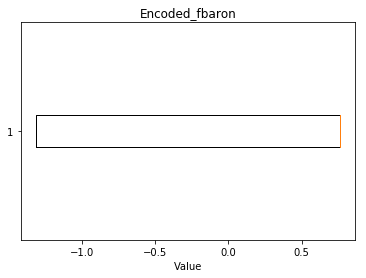

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


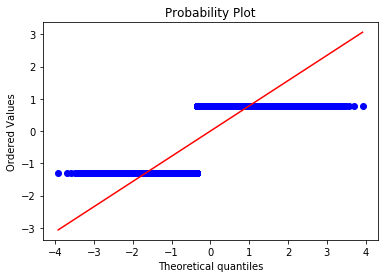

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.5501
Kurtosis: -1.6973
Overview of variable:  Encoded_Year 


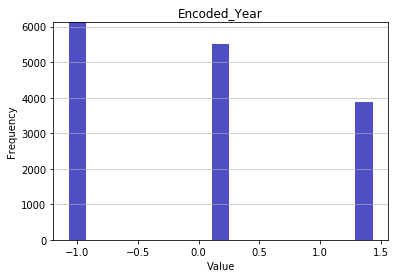

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.0831441071775643
Mean: 0.0
Standard deviation: 1.0
Median: 0.1829
Maximal value: 1.4489828888540146


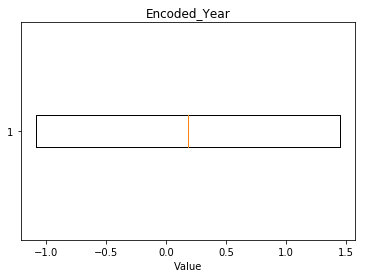

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


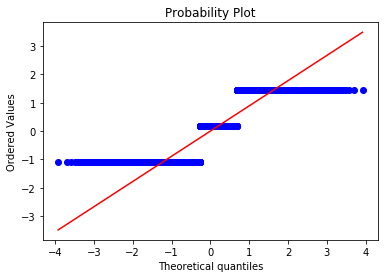

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2617
Kurtosis: -1.3539
Overview of variable:  Encoded_culture 


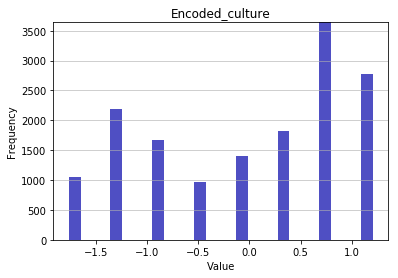

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.7727474792783493
Mean: 0.0
Standard deviation: 1.0
Median: 0.3618
Maximal value: 1.2155526423569012


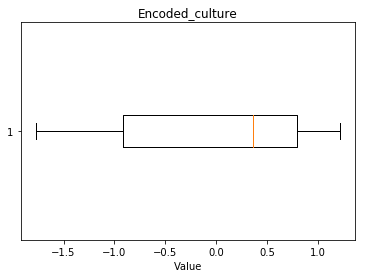

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


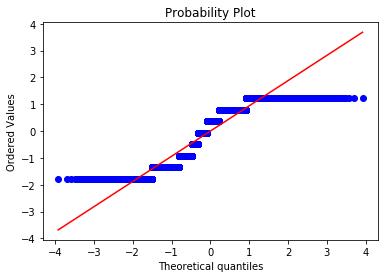

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.3692
Kurtosis: -1.3066


<Figure size 432x288 with 0 Axes>

In [23]:
# Loop through all numerical variables and visualize data
for num_variable in numerical_variables:
    SummaryNumericVar(transformed_data_df[num_variable], num_variable)

### 2.3 Conclusion univariate analysis

In [24]:
# Check whether all features in the dataset are numeric
set(transformed_data_df.dtypes)

{dtype('float64'), dtype('O')}

In [25]:
# Short intermediate summary
print("The transformed dataset captures information from", len(transformed_data_df.columns), "features.")
print("In total, there are", len(transformed_data_df), "observations present in the dataframe, capturing the information from",
      int(len(transformed_data_df)/2), "games.")
print("\nThe following features are captured by the dataset:\n\n", list(transformed_data_df.columns))

The transformed dataset captures information from 74 features.
In total, there are 15504 observations present in the dataframe, capturing the information from 7752 games.

The following features are captured by the dataset:

 ['split', 'patchno', 'gamelength', 'k', 'd', 'a', 'teamkills', 'fbtime', 'kpm', 'ckpm', 'fdtime', 'teamdragkills', 'elementals', 'firedrakes', 'waterdrakes', 'earthdrakes', 'airdrakes', 'elders', 'heraldtime', 'fttime', 'teamtowerkills', 'fbarontime', 'teambaronkills', 'dmgtochamps', 'dmgtochampsperminute', 'wards', 'wpm', 'wardkills', 'wcpm', 'visionwards', 'visionwardbuys', 'visiblewardclearrate', 'invisiblewardclearrate', 'totalgold', 'earnedgpm', 'goldspent', 'gspd', 'minionkills', 'monsterkills', 'monsterkillsownjungle', 'monsterkillsenemyjungle', 'cspm', 'goldat10', 'gdat10', 'goldat15', 'gdat15', 'xpat10', 'xpdat10', 'csat10', 'csdat10', 'csat15', 'csdat15', 'datediff', 'Encoded_league', 'Encoded_game', 'Encoded_side', 'Encoded_ban1', 'Encoded_ban2', 'Encod

---------------------------------------------------------------------------------------------------- 
Overview of variable:  result 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



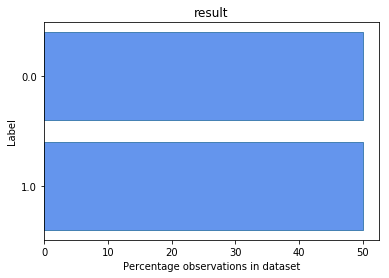

<Figure size 432x288 with 0 Axes>

In [26]:
# Refactoring encoding of target feature
transformed_data_df['result'] = [x if x > 0 else 0 for x in transformed_data_df['Encoded_result']]
transformed_data_df = transformed_data_df.drop(['Encoded_result'], axis = 1)

# Visualization properties target
SummaryCategoricalVar(transformed_data_df['result'], 'result')

In [27]:
# Save the transformed data
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + saved_filename + '.pickle', 'wb') as f:
    pickle.dump(transformed_data_df, f)

In [28]:
# Save the file containing the column name and matching box-cox
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + saved_filename + '_optimizers.pickle', 'wb') as f:
    pickle.dump(optimiser_dict, f)

## 3. Multivariate analysis
* Correlation plot (remove variables that are highly correlated)
* Boxplot/ scatterpot/ wrapped plot to visualize important relationships between variables
* t-test to assess difference between categories

### 3.1 Collinearity exploration

##### Investigate correlation between features

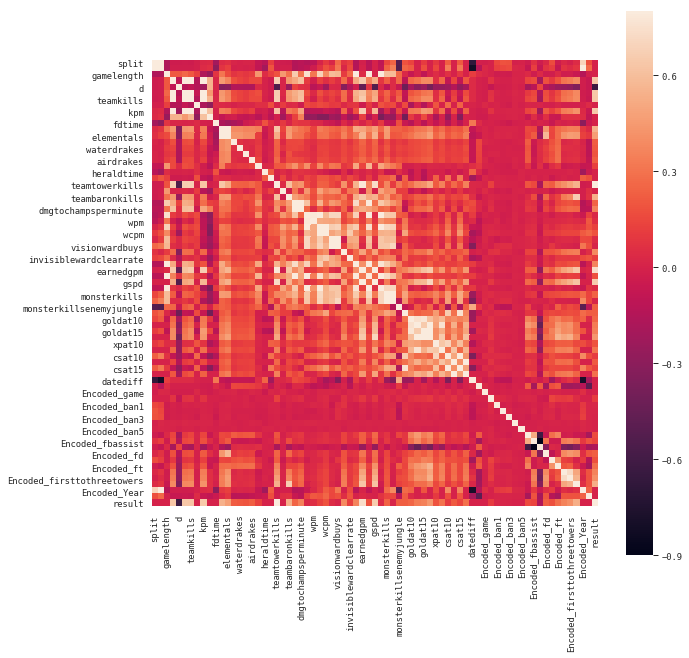

In [29]:
# Create corrplot
sns.set(context = "paper", font = "monospace")
corrmat = transformed_data_df.corr()
f, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(corrmat, vmax = .8, square = True) 
plt.show()

In [30]:
# Print list with highest correlated features
corrmap_abs = transformed_data_df.corr().abs()
corrmap_abs_sorted = corrmap_abs.unstack().sort_values(kind = "quicksort", ascending = False)
corrmap_abs_sorted.iloc[(len(transformed_data_df.columns) + 3):(len(transformed_data_df.columns) + 1) + 20,]

a                 teamkills           0.931848
teamkills         a                   0.931848
k                 a                   0.931848
a                 k                   0.931848
k                 kpm                 0.912315
kpm               teamkills           0.912315
teamkills         kpm                 0.912315
kpm               k                   0.912315
wcpm              wardkills           0.898746
wardkills         wcpm                0.898746
Encoded_fbvictim  Encoded_fbassist    0.898489
Encoded_fbassist  Encoded_fbvictim    0.898489
goldspent         minionkills         0.889413
minionkills       goldspent           0.889413
result            teamtowerkills      0.882811
teamtowerkills    result              0.882811
csat10            csat15              0.880808
csat15            csat10              0.880808
dtype: float64

In [31]:
# Short intermediate summary
print("The percentage of correlations (autocorrelations excluded) higher than 0.5 in absolute value: ",
      str(sum([x for x in list(corrmap_abs_sorted) if x >= 0.5])/len(corrmap_abs_sorted)*100))

The percentage of correlations (autocorrelations excluded) higher than 0.5 in absolute value:  5.794637040109629


##### Calculate variance inflation factor
This is purely out of interest, although we expect penelized regression methods to be able to cope with collinearity between the features.

In [32]:
# Extract dataset containing only the numeric features
transformed_data_numeric_df = transformed_data_df.copy()
transformed_data_numeric_df = transformed_data_numeric_df.drop(labels = ['team'], axis=1)

In [33]:
# Calculate the variance inflation factor for the different features
X = add_constant(transformed_data_numeric_df)
vif_columns = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index = X.columns)

In [34]:
# Print the top 20 features with the highest VIF
vif_columns_sorted = vif_columns.sort_values(kind = "quicksort", ascending = False)
vif_columns_sorted[:20]

earthdrakes                    inf
airdrakes                      inf
waterdrakes                    inf
firedrakes                     inf
elementals                     inf
Encoded_fb                     inf
Encoded_fbvictim               inf
teamkills                      inf
k                              inf
wardkills               678.017794
wards                   353.928818
wcpm                    329.822860
dmgtochamps             234.479055
dmgtochampsperminute    115.247708
wpm                     108.973734
minionkills             104.706024
totalgold                47.594165
goldspent                43.964780
kpm                      41.871129
patchno                  39.233699
dtype: float64

### 3.2 Some visualizations

In [35]:
data_preparation.columns

Index(['gameid', 'league', 'split', 'game', 'patchno', 'side', 'ban1', 'ban2',
       'ban3', 'ban4', 'ban5', 'gamelength', 'result', 'k', 'd', 'a',
       'teamkills', 'fb', 'fbassist', 'fbvictim', 'fbtime', 'kpm', 'ckpm',
       'fd', 'fdtime', 'teamdragkills', 'elementals', 'firedrakes',
       'waterdrakes', 'earthdrakes', 'airdrakes', 'elders', 'herald',
       'heraldtime', 'ft', 'fttime', 'firstmidouter', 'firsttothreetowers',
       'teamtowerkills', 'fbaron', 'fbarontime', 'teambaronkills',
       'dmgtochamps', 'dmgtochampsperminute', 'wards', 'wpm', 'wardshare',
       'wardkills', 'wcpm', 'visionwards', 'visionwardbuys',
       'visiblewardclearrate', 'invisiblewardclearrate', 'totalgold',
       'earnedgpm', 'goldspent', 'gspd', 'minionkills', 'monsterkills',
       'monsterkillsownjungle', 'monsterkillsenemyjungle', 'cspm', 'goldat10',
       'gdat10', 'goldat15', 'gdat15', 'xpat10', 'xpdat10', 'csat10',
       'csdat10', 'csat15', 'csdat15', 'Year', 'team', 'culture', 'd

NameError: name 'dog' is not defined

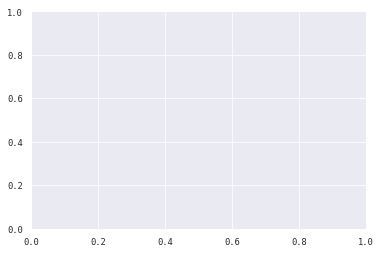

In [36]:
fig, ax = plt.subplots()
ax.plot(data_preparation.league, dog, label="dog")
ax.plot(data_preparation.league, cat, label="cat")
ax.legend()

In [ ]:
# Visualize a summarization of the accuracy metrics for the different ML methods
fig, ax = plt.subplots()
ax.plot(list(data_preparation.index), model_summary_table.sensitivity, '--', label="sensitivity", color='lightskyblue')
ax.plot(list(data_preparation.index), model_summary_table.specificity, '--', label="specificity", color='lightblue')
ax.plot(list(model_summary_table.index), model_summary_table.accuracy, label="accuracy", color='royalblue')
plt.title("Sensitivity, specificity and accuracy regularization models")
ax.legend(loc ="best", fontsize = 8)